In [167]:
import pandas as pd

# Load the CSV file
file_path = r"C:\Users\Chris\Downloads\BITSTAMP_BTCUSD, 1D.csv"
df = pd.read_csv(file_path)

# Convert 'time' column to datetime (replace 'time' with the exact column name if different)
df['time'] = pd.to_datetime(df['time'], unit='s')

num_rows = len(df)
print("Number of rows:", num_rows)

# Show the result
print(df.head())
print(df.tail())

Number of rows: 4980
        time   open   high    low  close    Volume
0 2011-08-18  10.90  10.90  10.90  10.90  0.489908
1 2011-08-19  11.85  11.85  11.15  11.69  1.926578
2 2011-08-20  11.70  11.70  11.70  11.70  0.085470
3 2011-08-21  11.70  11.70  11.70  11.70  0.085470
4 2011-08-22  11.70  11.70  11.70  11.70  0.028632
           time     open      high      low     close       Volume
4975 2025-05-04  95850.0   96295.0  94162.0   94316.0   562.773176
4976 2025-05-05  94301.0   95198.0  93550.0   94725.0   933.925785
4977 2025-05-06  94725.0   96895.0  93376.0   96814.0  1074.635037
4978 2025-05-07  96815.0   97717.0  95823.0   97054.0  1333.272379
4979 2025-05-08  97059.0  101711.0  96907.0  101313.0  1668.381966


In [2]:
# Calculate return as a percentage
df['return_percent'] = ((df['close'] - df['open']) / df['open']) * 100

# Show the first few rows
print(df.head(5))
print(df.tail(5))

        time   open   high    low  close    Volume  return_percent
0 2011-08-18  10.90  10.90  10.90  10.90  0.489908        0.000000
1 2011-08-19  11.85  11.85  11.15  11.69  1.926578       -1.350211
2 2011-08-20  11.70  11.70  11.70  11.70  0.085470        0.000000
3 2011-08-21  11.70  11.70  11.70  11.70  0.085470        0.000000
4 2011-08-22  11.70  11.70  11.70  11.70  0.028632        0.000000
           time     open      high      low     close       Volume  \
4975 2025-05-04  95850.0   96295.0  94162.0   94316.0   562.773176   
4976 2025-05-05  94301.0   95198.0  93550.0   94725.0   933.925785   
4977 2025-05-06  94725.0   96895.0  93376.0   96814.0  1074.635037   
4978 2025-05-07  96815.0   97717.0  95823.0   97054.0  1333.272379   
4979 2025-05-08  97059.0  101711.0  96907.0  101313.0  1668.381966   

      return_percent  
4975       -1.600417  
4976        0.449624  
4977        2.205331  
4978        0.246863  
4979        4.382901  


In [3]:
def add_bitcoin_cycle_year(df):
    """
    Adds a 'cycle_year' column to the dataframe that indicates where each year falls
    in Bitcoin's 4-year cycle, based on the pattern provided:
    
    2011: Year 3
    2012: Year 4
    2013: Year 1
    ...and so on.
    """
    # Ensure we have a datetime column
    if 'time' not in df.columns:
        df['time'] = pd.to_datetime(df['time'], unit='s')
    elif not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    # Extract the year
    df['year'] = df['time'].dt.year
    
    # Map years to cycle years based on the pattern
    # The pattern is 2013, 2017, 2021, 2025 = Year 1
    df['cycle_year'] = df['year'].apply(lambda y: f"Year{1 + ((y - 2013) % 4)}")
    
    # Return the modified dataframe
    return df

# Example usage:
# df = pd.read_csv("your_bitcoin_data.csv")
df = add_bitcoin_cycle_year(df)
print(df[['time', 'open', 'close', 'year', 'cycle_year']].head())
print(df[['time', 'open', 'close', 'year', 'cycle_year']].tail())
#print(df)

        time   open  close  year cycle_year
0 2011-08-18  10.90  10.90  2011      Year3
1 2011-08-19  11.85  11.69  2011      Year3
2 2011-08-20  11.70  11.70  2011      Year3
3 2011-08-21  11.70  11.70  2011      Year3
4 2011-08-22  11.70  11.70  2011      Year3
           time     open     close  year cycle_year
4975 2025-05-04  95850.0   94316.0  2025      Year1
4976 2025-05-05  94301.0   94725.0  2025      Year1
4977 2025-05-06  94725.0   96814.0  2025      Year1
4978 2025-05-07  96815.0   97054.0  2025      Year1
4979 2025-05-08  97059.0  101313.0  2025      Year1


In [4]:
import pandas as pd

def analyze_half_month_returns(df):
    # Ensure 'time' is datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Create 'half_month' and 'year_month' labels
    df['half_month'] = df['time'].apply(lambda x: f"{'1H' if x.day <= 15 else '2H'}_{x.strftime('%B')}")
    df['year_month_half'] = df['time'].apply(lambda x: f"{x.year}_{x.month}_{'1H' if x.day <= 15 else '2H'}")
    
    # Sort by time to ensure proper ordering
    df = df.sort_values('time')
    
    # Find first and last records for each period
    period_data = []
    for period, group in df.groupby('year_month_half'):
        first_day = group.iloc[0]
        last_day = group.iloc[-1]
        period_return = ((last_day['close'] - first_day['open']) / first_day['open']) * 100
        period_data.append({
            'year_month_half': period,
            'half_month': group['half_month'].iloc[0],
            'start_date': first_day['time'],
            'end_date': last_day['time'],
            'period_return': period_return
        })
    
    # Convert to DataFrame and group by half-month
    period_df = pd.DataFrame(period_data)
    result = period_df.groupby('half_month')['period_return'].mean().reset_index()
    
    # Sort by average return descending
    result = result.sort_values(by='period_return', ascending=False).reset_index(drop=True)
    result.rename(columns={'period_return': 'return_percent'}, inplace=True)
    
    return result

analyze_half_month_returns(df)

,half_month,return_percent
0,2H_November,17.905316
1,2H_July,10.436121
2,2H_April,9.747998
3,1H_November,9.253198
4,2H_October,8.557055
5,1H_February,8.069189
6,2H_May,6.640945
7,2H_March,6.157628
8,1H_October,6.086251
9,1H_January,6.074730


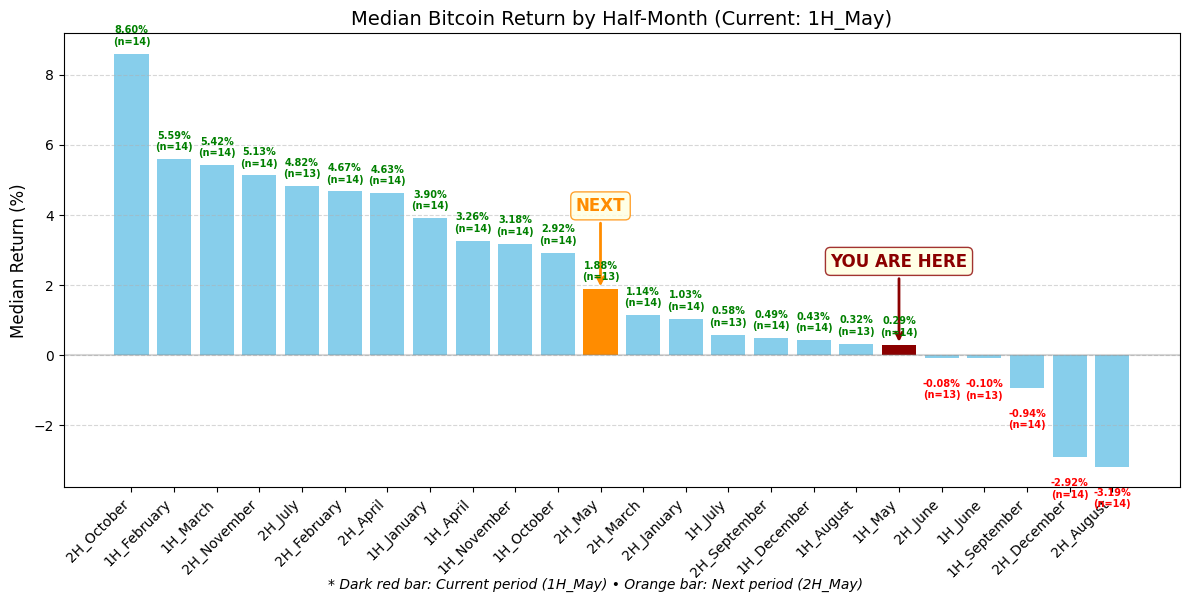


Analysis includes 330 periods from 15 years

Median Returns by Half-Month (Sorted):
1. 2H_October: 8.60% (n=14)
2. 1H_February: 5.59% (n=14)
3. 1H_March: 5.42% (n=14)
4. 2H_November: 5.13% (n=14)
5. 2H_July: 4.82% (n=13)
6. 2H_February: 4.67% (n=14)
7. 2H_April: 4.63% (n=14)
8. 1H_January: 3.90% (n=14)
9. 1H_April: 3.26% (n=14)
10. 1H_November: 3.18% (n=14)
11. 1H_October: 2.92% (n=14)
12. 2H_May: 1.88% (n=13)
13. 2H_March: 1.14% (n=14)
14. 2H_January: 1.03% (n=14)
15. 1H_July: 0.58% (n=13)
16. 2H_September: 0.49% (n=14)
17. 1H_December: 0.43% (n=14)
18. 1H_August: 0.32% (n=13)
19. 1H_May: 0.29% (n=14)
20. 2H_June: -0.08% (n=13)
21. 1H_June: -0.10% (n=13)
22. 1H_September: -0.94% (n=14)
23. 2H_December: -2.92% (n=14)
24. 2H_August: -3.19% (n=14)


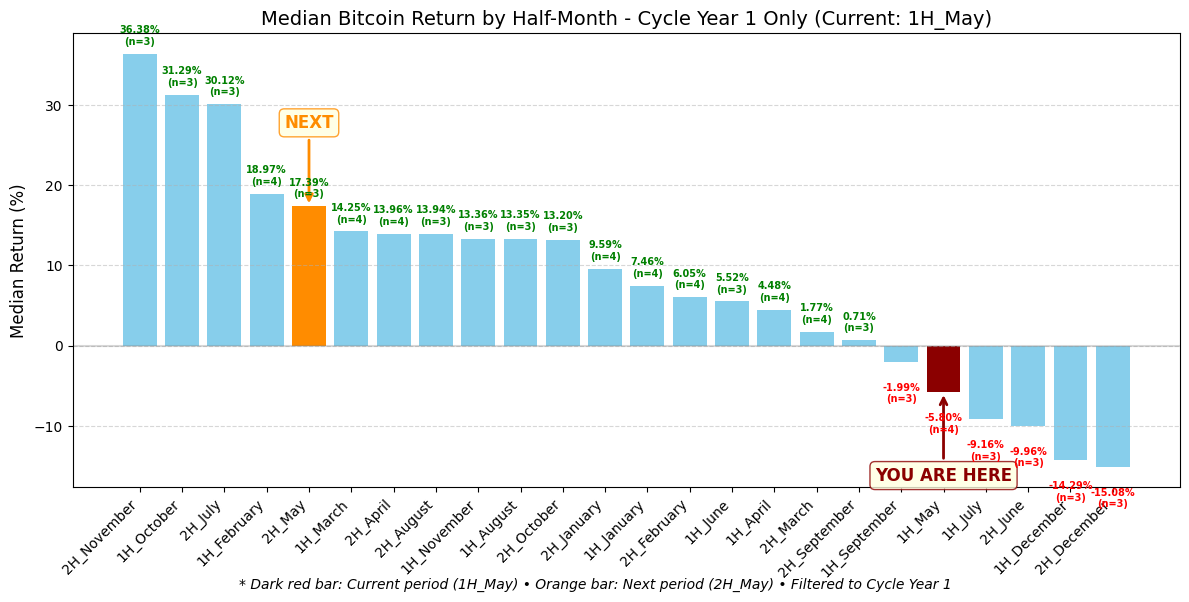


Analysis includes 81 periods from 4 years matching cycle Year 1

Median Returns by Half-Month (Sorted):
1. 2H_November: 36.38% (n=3)
2. 1H_October: 31.29% (n=3)
3. 2H_July: 30.12% (n=3)
4. 1H_February: 18.97% (n=4)
5. 2H_May: 17.39% (n=3)
6. 1H_March: 14.25% (n=4)
7. 2H_April: 13.96% (n=4)
8. 2H_August: 13.94% (n=3)
9. 1H_November: 13.36% (n=3)
10. 1H_August: 13.35% (n=3)
11. 2H_October: 13.20% (n=3)
12. 2H_January: 9.59% (n=4)
13. 1H_January: 7.46% (n=4)
14. 2H_February: 6.05% (n=4)
15. 1H_June: 5.52% (n=3)
16. 1H_April: 4.48% (n=4)
17. 2H_March: 1.77% (n=4)
18. 2H_September: 0.71% (n=3)
19. 1H_September: -1.99% (n=3)
20. 1H_May: -5.80% (n=4)
21. 1H_July: -9.16% (n=3)
22. 2H_June: -9.96% (n=3)
23. 1H_December: -14.29% (n=3)
24. 2H_December: -15.08% (n=3)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_half_month_returns(df, use_median=False, cycle_year_filter=None):
    """
    Analyzes half-month returns with options for using median and filtering by Bitcoin cycle year.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing price data with 'time', 'open', and 'close' columns
    use_median : bool, default=False
        If True, calculates median returns. If False, calculates average returns.
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4).
        Can be a single integer or a list of integers.
        If None, all years are included.
    """
    # Ensure 'time' is datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Add year column
    df['year'] = df['time'].dt.year
    
    # Add cycle year column (based on the 4-year Bitcoin cycle)
    # 2013, 2017, 2021, 2025 = Year 1
    # 2014, 2018, 2022 = Year 2
    # 2015, 2019, 2023 = Year 3
    # 2016, 2020, 2024 = Year 4
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Apply cycle year filter if specified
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
                
        # Filter the dataframe
        df = df[df['cycle_year'].isin(cycle_year_filter)].copy()
    
    # Create 'half_month' and 'year_month_half' labels
    df['half_month'] = df['time'].apply(lambda x: f"{'1H' if x.day <= 15 else '2H'}_{x.strftime('%B')}")
    df['year_month_half'] = df['time'].apply(lambda x: f"{x.year}_{x.month}_{'1H' if x.day <= 15 else '2H'}")
    
    # Sort by time to ensure proper ordering
    df = df.sort_values('time')
    
    # Find first and last records for each period
    period_data = []
    for period, group in df.groupby('year_month_half'):
        first_day = group.iloc[0]
        last_day = group.iloc[-1]
        period_return = ((last_day['close'] - first_day['open']) / first_day['open']) * 100
        period_data.append({
            'year_month_half': period,
            'half_month': group['half_month'].iloc[0],
            'year': first_day['time'].year,
            'cycle_year': 1 + ((first_day['time'].year - 2013) % 4),
            'start_date': first_day['time'],
            'end_date': last_day['time'],
            'period_return': period_return
        })
    
    # Convert to DataFrame
    period_df = pd.DataFrame(period_data)
    
    # Calculate statistics by half-month using either mean or median
    if use_median:
        result = period_df.groupby('half_month')['period_return'].median().reset_index()
        stat_type = 'Median'
    else:
        result = period_df.groupby('half_month')['period_return'].mean().reset_index()
        stat_type = 'Average'
    
    # Sort by return descending
    result = result.sort_values(by='period_return', ascending=False).reset_index(drop=True)
    result.rename(columns={'period_return': 'return_percent'}, inplace=True)
    
    # Add count of periods for each half-month (for sample size display)
    half_month_counts = period_df.groupby('half_month').size().reset_index(name='count')
    result = pd.merge(result, half_month_counts, on='half_month')
    
    return result, period_df, stat_type

def plot_half_month_returns(df_grouped, period_details, stat_type, cycle_year_filter=None):
    """
    Plot half-month returns with options for showing sample size and filtering by cycle year.
    
    Parameters:
    -----------
    df_grouped : pandas DataFrame
        DataFrame with half-month statistics
    period_details : pandas DataFrame
        DataFrame with detailed period data
    stat_type : str
        String indicating whether "Average" or "Median" statistic is being shown
    cycle_year_filter : int or list, optional
        The cycle year filter that was used for the analysis
    """
    plt.figure(figsize=(12, 6))
    
    # Get current half-month label
    today = datetime.now()
    current_half_month = f"{'1H' if today.day <= 15 else '2H'}_{today.strftime('%B')}"
    
    # Determine next half-month
    if today.day <= 15:
        # If we're in first half, next is second half of same month
        next_half_month = f"2H_{today.strftime('%B')}"
    else:
        # If we're in second half, next is first half of next month
        next_month = today.month + 1
        if next_month > 12:
            next_month = 1  # Handle December to January transition
        next_month_name = datetime(today.year, next_month, 1).strftime('%B')
        next_half_month = f"1H_{next_month_name}"
    
    # Create bar colors, highlighting current and next periods
    colors = []
    for x in df_grouped['half_month']:
        if x == current_half_month:
            colors.append('darkred')
        elif x == next_half_month:
            colors.append('darkorange')
        else:
            colors.append('skyblue')
    
    # Create bar chart
    bars = plt.bar(df_grouped['half_month'], df_grouped['return_percent'], color=colors)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Create title based on filter and statistic type
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        title = f'{stat_type} Bitcoin Return by Half-Month - Cycle {cycle_years_str} Only'
    else:
        title = f'{stat_type} Bitcoin Return by Half-Month'
        
    # Add current period info to title
    title += f' (Current: {current_half_month})'
    
    # Style the chart
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel(f'{stat_type} Return (%)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Annotate values on bars with different colors based on value
    for i, bar in enumerate(bars):
        height = bar.get_height()
        value_color = 'green' if height >= 0 else 'red'
        
        half_month = df_grouped['half_month'].iloc[i]
        sample_size = df_grouped['count'].iloc[i]
        
        # Add "You Are Here" arrow for current half-month
        if half_month == current_half_month:
            # Calculate arrow position and properties
            arrow_direction = 1 if height >= 0 else -1
            
            # Add "YOU ARE HERE" text with increased distance
            plt.annotate("YOU ARE HERE", 
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 60 * arrow_direction),
                         textcoords='offset points',
                         ha='center', va='center',
                         color='darkred', fontweight='bold', fontsize=12,
                         bbox=dict(boxstyle="round,pad=0.3", fc='lightyellow', ec="darkred", alpha=0.8),
                         arrowprops=dict(arrowstyle="->", 
                                         connectionstyle="arc3", 
                                         color='darkred',
                                         lw=2))
                                         
        # Add "NEXT" arrow for next half-month
        elif half_month == next_half_month:
            # Calculate arrow position and properties
            arrow_direction = 1 if height >= 0 else -1
            
            # Add "NEXT" text with increased distance
            plt.annotate("NEXT", 
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 60 * arrow_direction),
                         textcoords='offset points',
                         ha='center', va='center',
                         color='darkorange', fontweight='bold', fontsize=12,
                         bbox=dict(boxstyle="round,pad=0.3", fc='lightyellow', ec="darkorange", alpha=0.8),
                         arrowprops=dict(arrowstyle="->", 
                                         connectionstyle="arc3", 
                                         color='darkorange',
                                         lw=2))
        
        # Add value and sample size annotation
        plt.annotate(f'{height:.2f}%\n(n={sample_size})', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5 if height >= 0 else -15),
                     textcoords='offset points',
                     ha='center', va='bottom' if height >= 0 else 'top',
                     color=value_color, fontweight='bold',
                     fontsize=7)  # Adjustable font size
    
    # Create legend text based on filter
    if cycle_year_filter is not None:
        filter_text = f" • Filtered to Cycle {cycle_years_str}"
    else:
        filter_text = ""
    
    # Add legend for color coding
    plt.figtext(0.5, 0.01, 
                f"* Dark red bar: Current period ({current_half_month}) • Orange bar: Next period ({next_half_month}){filter_text}",
                ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for reference
    total_periods = len(period_details)
    if cycle_year_filter is not None:
        filtered_years = period_details['year'].nunique()
        print(f"\nAnalysis includes {total_periods} periods from {filtered_years} years matching cycle {cycle_years_str}")
    else:
        print(f"\nAnalysis includes {total_periods} periods from {period_details['year'].nunique()} years")
    
    print(f"\n{stat_type} Returns by Half-Month (Sorted):")
    for i, row in df_grouped.iterrows():
        half = row['half_month']
        ret = row['return_percent']
        count = row['count']
        print(f"{i+1}. {half}: {ret:.2f}% (n={count})")

# Example usage:
# Load data
# file_path = "BITSTAMP_BTCUSD, 1D.csv"
# df = pd.read_csv(file_path)

# Analyze and plot with default parameters (average returns, all cycle years)
# grouped_df, period_details, stat_type = analyze_half_month_returns(df)
# plot_half_month_returns(grouped_df, period_details, stat_type)

# Analyze and plot with median returns
grouped_df, period_details, stat_type = analyze_half_month_returns(df, use_median=True)
plot_half_month_returns(grouped_df, period_details, stat_type)

# Analyze and plot with cycle year 1 only
#grouped_df, period_details, stat_type = analyze_half_month_returns(df, cycle_year_filter=1)
#plot_half_month_returns(grouped_df, period_details, stat_type, cycle_year_filter=1)

# Analyze and plot with median returns and multiple cycle years
#grouped_df, period_details, stat_type = analyze_half_month_returns(df, use_median=True, cycle_year_filter=[1, 3])
#plot_half_month_returns(grouped_df, period_details, stat_type, cycle_year_filter=[1, 3])

# Analyze and plot with median returns and one multiple cycle year
grouped_df, period_details, stat_type = analyze_half_month_returns(df, use_median=True, cycle_year_filter=[1])
plot_half_month_returns(grouped_df, period_details, stat_type, cycle_year_filter=[1])

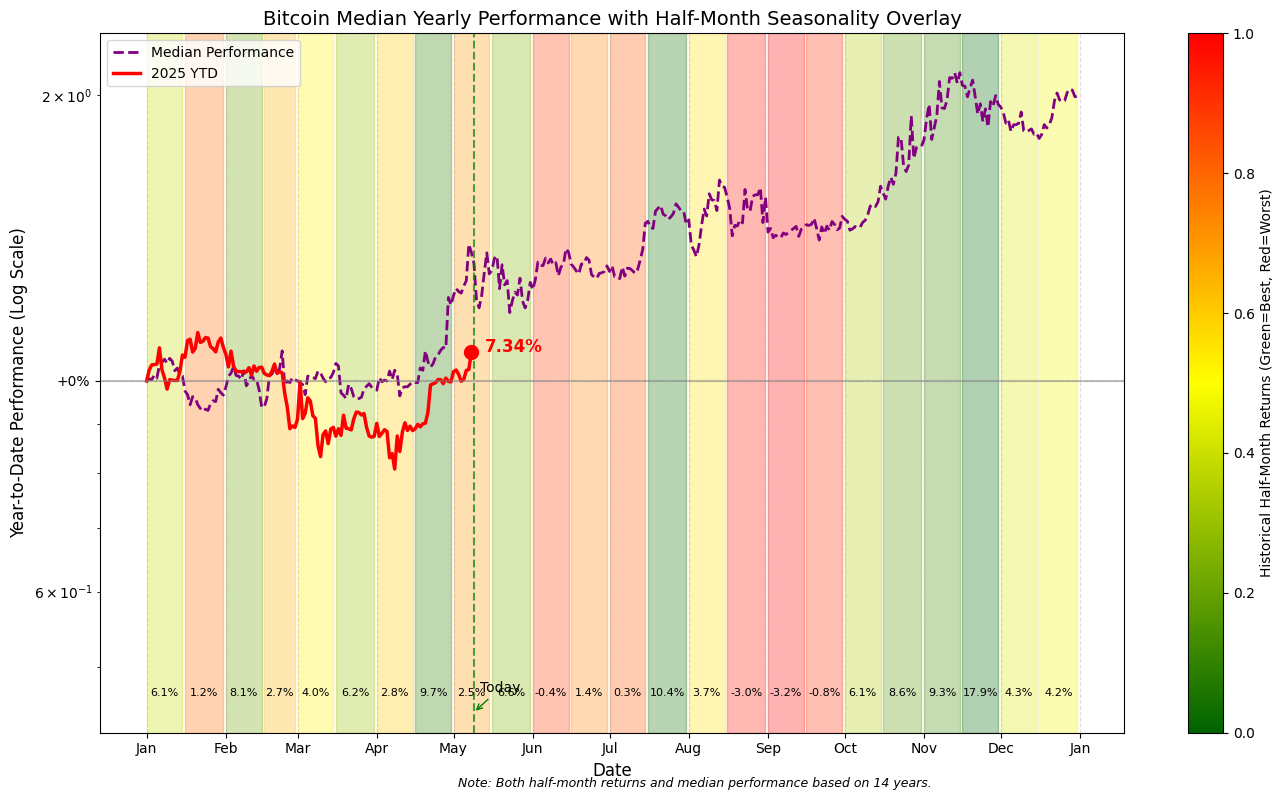

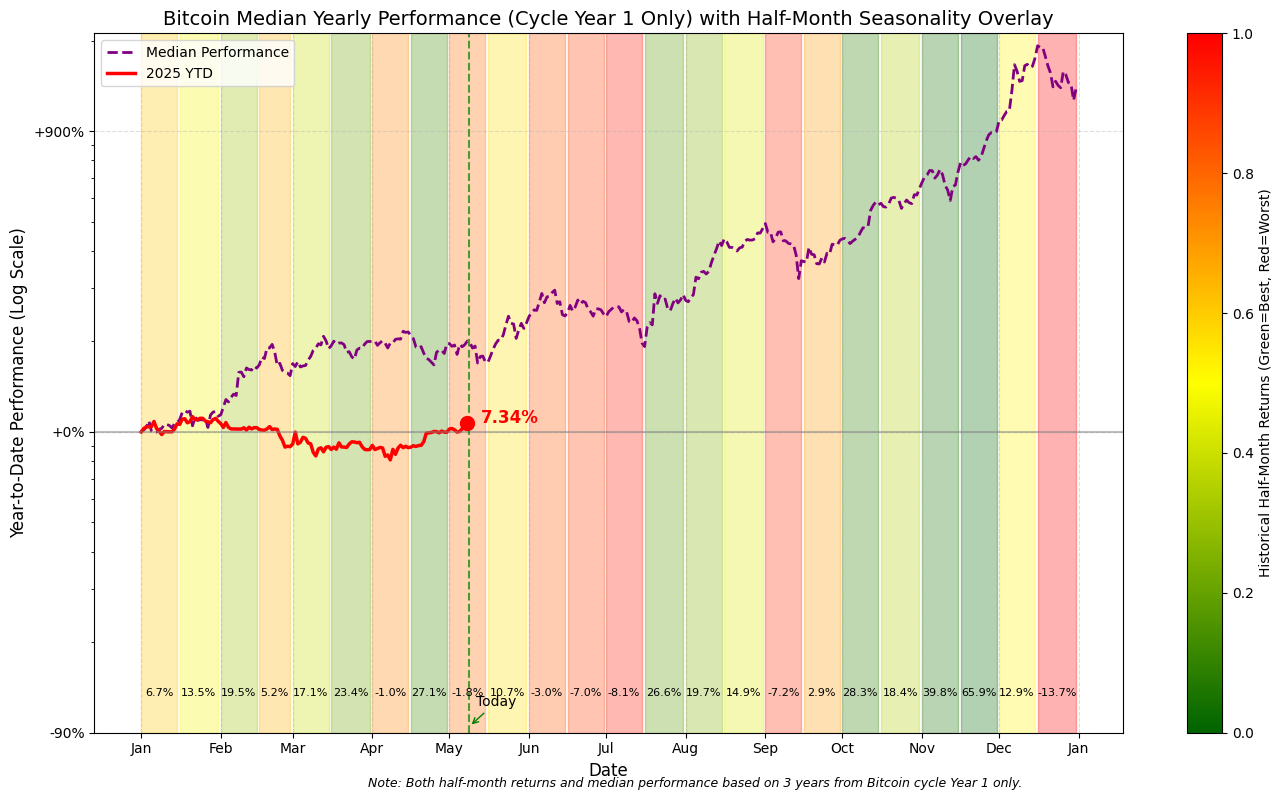

,half_month,return_mean,return_median,count,years_spanned,rank,rank_norm
0,2H_November,65.894338,36.381546,3,3,1,0.000000
1,1H_November,39.815261,13.362262,3,3,2,0.043478
2,1H_October,28.340994,31.289455,3,3,3,0.086957
3,2H_April,27.079617,13.958803,4,4,4,0.130435
4,2H_July,26.623236,30.121434,3,3,5,0.173913
5,2H_March,23.359985,1.765370,4,4,6,0.217391
6,1H_August,19.728072,13.350813,3,3,7,0.260870
7,1H_February,19.507309,18.968256,4,4,8,0.304348
8,2H_October,18.409213,13.200221,3,3,9,0.347826
9,1H_March,17.101333,14.246913,4,4,10,0.391304


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime

def analyze_half_month_returns(df, cycle_year_filter=None):
    """
    Analyze returns for each half-month period with optional cycle year filtering.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing price data
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
    """
    # Create a copy of the dataframe
    df = df.copy()
    
    # Ensure 'time' is datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Add year and cycle year columns
    df['year'] = df['time'].dt.year
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Apply cycle year filter if specified
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
        
        # Filter the dataframe
        df = df[df['cycle_year'].isin(cycle_year_filter)].copy()
    
    # Create 'half_month' and 'year_month_half' labels
    df['half_month'] = df['time'].apply(lambda x: f"{'1H' if x.day <= 15 else '2H'}_{x.strftime('%B')}")
    df['year_month_half'] = df['time'].apply(lambda x: f"{x.year}_{x.month}_{'1H' if x.day <= 15 else '2H'}")
    
    # Sort by time to ensure proper ordering
    df = df.sort_values('time')
    
    # Find first and last records for each period
    period_data = []
    for period, group in df.groupby('year_month_half'):
        first_day = group.iloc[0]
        last_day = group.iloc[-1]
        period_return = ((last_day['close'] - first_day['open']) / first_day['open']) * 100
        period_data.append({
            'year_month_half': period,
            'half_month': group['half_month'].iloc[0],
            'year': first_day['time'].year,
            'cycle_year': first_day['cycle_year'],
            'start_date': first_day['time'],
            'end_date': last_day['time'],
            'period_return': period_return
        })
    
    # Convert to DataFrame
    period_df = pd.DataFrame(period_data)
    
    # Calculate both mean and median for each half-month
    result = period_df.groupby('half_month').agg({
        'period_return': ['mean', 'median', 'count'],
        'year': lambda x: pd.Series(x).nunique()  # Count unique years
    }).reset_index()
    
    # Flatten the multi-index columns
    result.columns = ['half_month', 'return_mean', 'return_median', 'count', 'years_spanned']
    
    # Sort by average return descending
    result = result.sort_values(by='return_mean', ascending=False).reset_index(drop=True)
    
    # Add rank (1 = best, n = worst)
    result['rank'] = range(1, len(result) + 1)
    
    # Normalize rank from best (0) to worst (1) for color mapping
    result['rank_norm'] = result['return_mean'].rank(ascending=False, method='first')
    result['rank_norm'] = (result['rank_norm'] - 1) / (len(result) - 1)
    
    return result, period_df

def calculate_yearly_performance(df, cycle_year_filter=None):
    """
    Calculate yearly performance metrics with optional cycle year filtering.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing price data
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
        Can be a single integer or a list of integers.
        If None, all years are included.
    """
    # Ensure time is datetime
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Add year column
    df['year'] = df['time'].dt.year
    
    # Add cycle year column (based on the 4-year Bitcoin cycle)
    # 2013, 2017, 2021, 2025 = Year 1
    # 2014, 2018, 2022 = Year 2
    # 2015, 2019, 2023 = Year 3
    # 2016, 2020, 2024 = Year 4
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Apply cycle year filter if specified
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
        
        # Filter the dataframe
        filtered_df = df[df['cycle_year'].isin(cycle_year_filter)].copy()
    else:
        filtered_df = df.copy()
    
    # Get current year
    current_year = datetime.now().year
    
    # Create dataframe to store yearly performance data
    all_years_data = []
    
    # Get unique years excluding current year
    past_years = sorted(filtered_df[filtered_df['year'] < current_year]['year'].unique())
    
    # Process each past year
    for year in past_years:
        # Get data for this year
        year_data = filtered_df[filtered_df['year'] == year].copy()
        
        # Skip if not enough data
        if len(year_data) < 2:
            continue
        
        # Get the first trading day's close price
        first_close = year_data.iloc[0]['close']
        
        # Calculate percentage change from first day
        year_data['pct_change'] = ((year_data['close'] - first_close) / first_close) * 100
        
        # Create a date column that's normalized to the current year for comparison
        year_data['normalized_date'] = year_data['time'].apply(
            lambda x: safe_date_replace(x, 2025)
        )
        
        # Add to our collection
        all_years_data.append(year_data)
    
    # Process current year data
    current_year_data = df[df['year'] == current_year].copy()
    if not current_year_data.empty:
        # Get the first trading day's close price
        first_close = current_year_data.iloc[0]['close']
        
        # Calculate percentage change from first day
        current_year_data['pct_change'] = ((current_year_data['close'] - first_close) / first_close) * 100
        
        # Normalize date for overlay
        current_year_data['normalized_date'] = current_year_data['time'].apply(
            lambda x: safe_date_replace(x, 2025)
        )
    
    # Combine all past years
    if all_years_data:
        past_years_df = pd.concat(all_years_data)
        
        # Calculate median for each calendar day
        median_performance = past_years_df.groupby('normalized_date')['pct_change'].median().reset_index()
        
        # Calculate average for each calendar day
        average_performance = past_years_df.groupby('normalized_date')['pct_change'].mean().reset_index()
        
        return median_performance, average_performance, current_year_data, past_years
    
    return None, None, current_year_data, past_years

def plot_2025_with_overlay(df, show_average=False, show_median=True, cycle_year_filter=None):
    """
    Plot 2025 performance with seasonal overlay.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing price data
    show_average : bool, default=False
        Whether to show the average performance line
    show_median : bool, default=True
        Whether to show the median performance line
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
        Can be a single integer or a list of integers.
        If None, all years are included.
    """
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df_2025 = df[df['time'].dt.year == 2025]
    if df_2025.empty:
        print("No data found for 2025.")
        return
    
    # Process half-month data with the same cycle year filter
    half_month_data, period_details = analyze_half_month_returns(df, cycle_year_filter)
    
    # Calculate yearly performance metrics with the same cycle year filter
    median_performance, average_performance, current_year_data, past_years = calculate_yearly_performance(df, cycle_year_filter)
    
    # Create figure with primary y-axis only for performance metrics
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    # Set logarithmic scale for the y-axis
    ax.set_yscale('log')
    
    # Color map from green (good) to red (bad)
    cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['darkgreen', 'yellow', 'red'])
    
    # Plot background rectangles
    for month in range(1, 13):
        for half in [1, 2]:
            label = f"{'1H' if half == 1 else '2H'}_{pd.to_datetime(f'2025-{month:02d}-01').strftime('%B')}"
            match = half_month_data[half_month_data['half_month'] == label]
            if not match.empty:
                norm_rank = match.iloc[0]['rank_norm']
                mean_return = match.iloc[0]['return_mean']
                median_return = match.iloc[0]['return_median']
                count = match.iloc[0]['count']
                color = cmap(norm_rank)
                
                start_day = 1 if half == 1 else 16
                end_day = 15 if half == 1 else pd.to_datetime(f'2025-{month:02d}-01').days_in_month
                start = pd.to_datetime(f'2025-{month:02d}-{start_day}')
                end = pd.to_datetime(f'2025-{month:02d}-{end_day}')
                
                rect = ax.axvspan(start, end, color=color, alpha=0.3)
                
                # Add text annotation in the middle of each half-month
                mid_date = start + (end - start) / 2
                ax.text(mid_date, 0.05, f"{mean_return:.1f}%", 
                       ha="center", va="bottom", 
                       color='black', fontsize=8,
                       transform=ax.get_xaxis_transform())
    
    # Plot yearly performance metrics
    if median_performance is not None and show_median:
        # Plot median performance
        ax.plot(median_performance['normalized_date'], 
                median_performance['pct_change'].apply(lambda x: (100 + x) / 100), 
                color='purple', 
                linewidth=2, 
                linestyle='--',
                label='Median Performance')
    
    if average_performance is not None and show_average:
        # Plot average performance
        ax.plot(average_performance['normalized_date'], 
                average_performance['pct_change'].apply(lambda x: (100 + x) / 100), 
                color='blue', 
                linewidth=2, 
                linestyle=':',
                label='Average Performance')
        
    # Plot current year performance
    if not current_year_data.empty:
        ax.plot(current_year_data['normalized_date'], 
               current_year_data['pct_change'].apply(lambda x: (100 + x) / 100), 
               color='red', 
               linewidth=2.5,
               label=f'{datetime.now().year} YTD')
        
        # Add a dot at the last point of current year
        last_point = current_year_data.iloc[-1]
        ax.scatter(last_point['normalized_date'], 
                  (100 + last_point['pct_change']) / 100, 
                  color='red', 
                  s=100, 
                  zorder=5)
        
        # Add annotation for current position
        ax.annotate(f"{last_point['pct_change']:.2f}%", 
                   xy=(last_point['normalized_date'], (100 + last_point['pct_change']) / 100),
                   xytext=(10, 0),
                   textcoords="offset points",
                   fontsize=12,
                   fontweight='bold',
                   color='red')
    
    # Add horizontal line at 1.0 (no change)
    ax.axhline(y=1.0, color='gray', linestyle='-', alpha=0.5)
    
    # Create a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Historical Half-Month Returns (Green=Best, Red=Worst)')
    
    # Format y-axis as multiples
    from matplotlib.ticker import FuncFormatter
    def price_ratio_formatter(y, pos):
        # Convert price ratio to percentage change
        pct_change = (y - 1) * 100
        if pct_change >= 0:
            return f"+{pct_change:.0f}%"
        else:
            return f"{pct_change:.0f}%"
    
    ax.yaxis.set_major_formatter(FuncFormatter(price_ratio_formatter))
    
    # Set y-axis limits for better visualization
    y_vals = []
    if median_performance is not None and show_median:
        y_vals.extend((100 + median_performance['pct_change']) / 100)
    if average_performance is not None and show_average:
        y_vals.extend((100 + average_performance['pct_change']) / 100)
    if not current_year_data.empty:
        y_vals.extend((100 + current_year_data['pct_change']) / 100)
    
    if y_vals:
        max_ratio = max(y_vals)
        min_ratio = min(y_vals)
        
        # Ensure we include 1.0 in the view
        max_ratio = max(max_ratio, 1.0)
        min_ratio = min(min_ratio, 1.0)
        
        # Make it symmetrical in percentage terms
        max_pct_change = (max_ratio - 1)
        min_pct_change = (min_ratio - 1)
        
        # If max change is larger in absolute terms, set min limit based on max
        if abs(max_pct_change) > abs(min_pct_change):
            inverse_max = 1 / (1 + max_pct_change)
            plt.ylim(max(0.1, inverse_max * 0.9), max_ratio * 1.1)
        # If min change is larger in absolute terms, set max limit based on min
        else:
            inverse_min = 1 / (1 + min_pct_change)
            plt.ylim(min_ratio * 0.9, min(10, inverse_min * 1.1))
    
    # Create title based on shown metrics and cycle filter
    title_parts = []
    
    if show_median and show_average:
        title_parts.append("Bitcoin Yearly Performance")
    elif show_median:
        title_parts.append("Bitcoin Median Yearly Performance")
    elif show_average:
        title_parts.append("Bitcoin Average Yearly Performance")
    else:
        title_parts.append("Bitcoin Current Year Performance")
    
    # Add cycle year information to title if filtered
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        title_parts.append(f"(Cycle {cycle_years_str} Only)")
    
    title = " ".join(title_parts) + " with Half-Month Seasonality Overlay"
    
    # Formatting
    plt.title(title, fontsize=14)
    plt.ylabel("Year-to-Date Performance (Log Scale)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    
    # Format x-axis to show months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Add today's date marker
    today_normalized = safe_date_replace(datetime.now(), 2025)
    plt.axvline(x=today_normalized, color='green', linestyle='--', alpha=0.7)
    plt.annotate('Today', 
                xy=(today_normalized, plt.gca().get_ylim()[0] * 1.05),
                xytext=(5, 15),
                textcoords="offset points",
                fontsize=10,
                arrowprops=dict(arrowstyle="->", color='green'))
    
    # Add legend
    plt.legend(loc='upper left')
    
    # Create metrics description
    metrics_desc = []
    if show_median:
        metrics_desc.append("median")
    if show_average:
        metrics_desc.append("average")
    
    metrics_text = " and ".join(metrics_desc)
    
    # Add cycle year information to footer
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        cycle_info = f" from Bitcoin cycle {cycle_years_str} only"
    else:
        cycle_info = ""
    
    # Add note about the calculation method
    plt.figtext(0.5, 0.01, 
                f"Note: Both half-month returns and {metrics_text} performance based on {len(past_years)} years{cycle_info}.",
                ha="center", fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    return half_month_data

# Helper function to safely handle date replacement, especially for leap years
def safe_date_replace(dt, new_year):
    """
    Safely replace the year of a datetime, handling leap years correctly.
    If February 29 is being converted to a non-leap year, it returns February 28.
    """
    try:
        return dt.replace(year=new_year)
    except ValueError:
        # This will happen with Feb 29 in leap years
        if dt.month == 2 and dt.day == 29:
            return datetime(new_year, 2, 28, 
                          dt.hour, dt.minute, dt.second, 
                          dt.microsecond, dt.tzinfo)
        else:
            raise  # Re-raise for any other ValueError

# Example usage:
# Load data
# file_path = "BITSTAMP_BTCUSD, 1D.csv"
# df = pd.read_csv(file_path)

# Create visualization with median performance for all cycle years
plot_2025_with_overlay(df, show_median=True)

# Create visualization with median performance for cycle year 1 only
plot_2025_with_overlay(df, show_median=True, cycle_year_filter=1)

# Create visualization with median performance for cycle years 1 and 3
# plot_2025_with_overlay(df, show_median=True, cycle_year_filter=[1, 3])

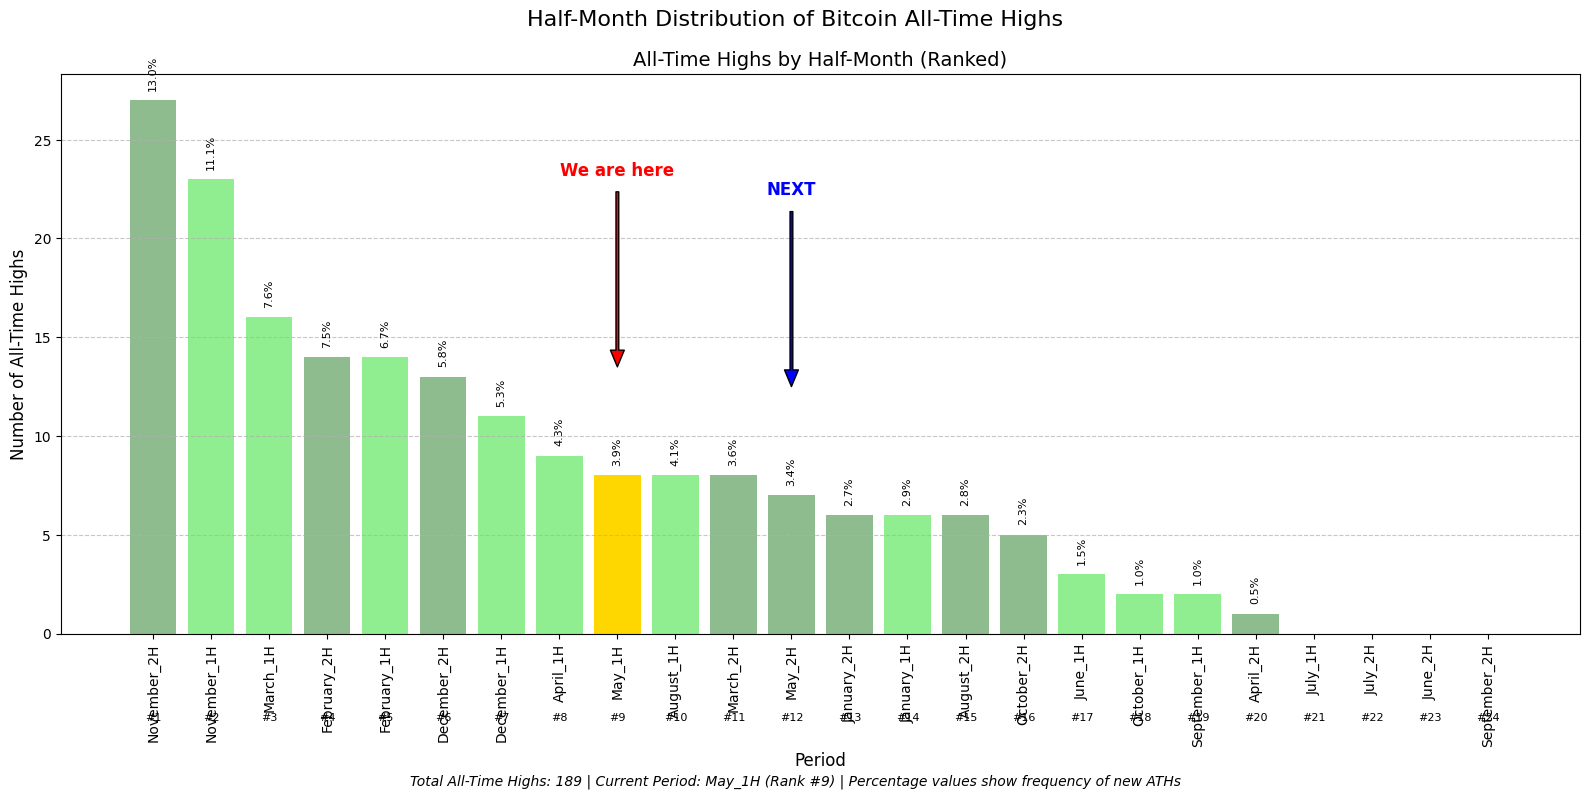


Half-Month All-Time High Rankings:

Rank Period              ATH Count   % of Days   Unique Years
------------------------------------------------------------
1    November_2H         27          12.98%      5           
2    November_1H         23          11.11%      4           
3    March_1H            16          7.62%      4           
4    February_2H         14          7.53%      3           
5    February_1H         14          6.67%      2           
6    December_2H         13          5.83%      3           
7    December_1H         11          5.29%      3           
8    April_1H            9           4.29%      2           
9    May_1H              8           3.94%      1            <-- WE ARE HERE
10   August_1H           8           4.10%      1           
11   March_2H            8           3.57%      1           
12   May_2H              7           3.37%      1            <-- NEXT
13   January_2H          6           2.68%      2           
14   January_1H     

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import datetime

def analyze_monthly_all_time_highs(df, cycle_year_filter=None, use_half_months=True):
    """
    Analyzes the frequency of new all-time highs by month and ranks them.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Bitcoin price data with columns 'time', 'high'
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
    use_half_months : bool, default=True
        If True, analyze by half-months (1st-15th and 16th-end of month)
    
    Returns:
    --------
    ranked_ath : pandas DataFrame
        DataFrame with monthly all-time high statistics, ranked
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    # Sort data by time to ensure correct order
    df = df.sort_values('time')
    
    # Add year and cycle year columns
    df['year'] = df['time'].dt.year
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Add month columns
    df['month'] = df['time'].dt.month
    df['month_name'] = df['time'].dt.strftime('%B')
    
    # Add half-month column (1H = 1st-15th, 2H = 16th-end)
    df['day'] = df['time'].dt.day
    df['half_month'] = df['day'].apply(lambda d: '1H' if d <= 15 else '2H')
    
    # Create a combined period identifier
    if use_half_months:
        # Format: "January_1H" for first half, "January_2H" for second half
        df['period'] = df['month_name'] + '_' + df['half_month']
        df['period_num'] = (df['month'] * 2) - (2 - df['half_month'].apply(lambda h: 1 if h == '1H' else 2))
    else:
        # Just use month if not using half-months
        df['period'] = df['month_name']
        df['period_num'] = df['month']
    
    # Apply cycle year filter if specified
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
                
        # Filter the dataframe
        df = df[df['cycle_year'].isin(cycle_year_filter)].copy()
    
    # Calculate running all-time high prices
    df['ath'] = df['high'].cummax()
    
    # Identify when new all-time highs are made
    df['new_ath'] = df['high'] > df['ath'].shift(1)
    df.loc[df.index[0], 'new_ath'] = True  # First day is by definition an ATH
    
    # Count new all-time highs by period
    period_ath = df[df['new_ath']].groupby(['period', 'period_num']).size().reset_index()
    period_ath.columns = ['period', 'period_num', 'new_ath_count']
    
    # Count total number of days per period in the dataset
    period_days = df.groupby(['period', 'period_num']).size().reset_index()
    period_days.columns = ['period', 'period_num', 'total_days']
    
    # Merge counts with days
    period_ath = pd.merge(period_ath, period_days, on=['period', 'period_num'], how='outer')
    
    # Fill any missing values with 0
    period_ath['new_ath_count'] = period_ath['new_ath_count'].fillna(0).astype(int)
    
    # Calculate percentage of days with new ATHs
    period_ath['ath_percentage'] = (period_ath['new_ath_count'] / period_ath['total_days']) * 100
    
    # Count unique years where ATHs occurred in each period
    ath_years = df[df['new_ath']].groupby(['period', 'period_num'])['year'].nunique().reset_index()
    ath_years.columns = ['period', 'period_num', 'unique_years']
    
    # Merge with period_ath
    period_ath = pd.merge(period_ath, ath_years, on=['period', 'period_num'], how='left')
    period_ath['unique_years'] = period_ath['unique_years'].fillna(0).astype(int)
    
    # Ensure all periods are present
    if use_half_months:
        # Create all possible half-month periods
        all_periods = []
        for m in range(1, 13):
            month_name = calendar.month_name[m]
            all_periods.append({'period': f"{month_name}_1H", 'period_num': (m * 2) - 1})
            all_periods.append({'period': f"{month_name}_2H", 'period_num': m * 2})
        all_periods_df = pd.DataFrame(all_periods)
    else:
        # Create all possible month periods
        all_periods = [{'period': calendar.month_name[m], 'period_num': m} for m in range(1, 13)]
        all_periods_df = pd.DataFrame(all_periods)
    
    # Merge to ensure all periods are present
    period_ath = pd.merge(all_periods_df, period_ath, on=['period', 'period_num'], how='left')
    
    # Fill missing values for periods with no ATHs
    period_ath['new_ath_count'] = period_ath['new_ath_count'].fillna(0).astype(int)
    period_ath['ath_percentage'] = period_ath['ath_percentage'].fillna(0)
    period_ath['unique_years'] = period_ath['unique_years'].fillna(0).astype(int)
    period_ath['total_days'] = period_ath['total_days'].fillna(0).astype(int)
    
    # Add month and half columns for easier analysis
    if use_half_months:
        period_ath['month'] = period_ath['period'].apply(lambda p: p.split('_')[0])
        period_ath['half'] = period_ath['period'].apply(lambda p: p.split('_')[1])
    else:
        period_ath['month'] = period_ath['period']
        period_ath['half'] = ''
    
    # Sort by count in descending order (highest first)
    ranked_ath = period_ath.sort_values('new_ath_count', ascending=False).reset_index(drop=True)
    
    # Add rank (1 = most ATHs)
    ranked_ath['rank'] = range(1, len(ranked_ath) + 1)
    
    # Get current period
    now = datetime.now()
    current_month = calendar.month_name[now.month]
    current_half = '1H' if now.day <= 15 else '2H'
    
    if use_half_months:
        current_period = f"{current_month}_{current_half}"
    else:
        current_period = current_month
    
    # Visualize the results
    visualize_ranked_ath(ranked_ath, current_period, cycle_year_filter, use_half_months)
    
    return ranked_ath

def visualize_ranked_ath(ranked_ath, current_period, cycle_year_filter=None, use_half_months=True):
    """
    Visualizes the distribution of all-time highs by period in ranked order.
    
    Parameters:
    -----------
    ranked_ath : pandas DataFrame
        DataFrame with period all-time high statistics, ranked
    current_period : str
        Current period (e.g., "May_1H" or "May")
    cycle_year_filter : int or list, optional
        Filter used for cycle years
    use_half_months : bool, default=True
        If True, analyze by half-months (1st-15th and 16th-end of month)
    """
    # Set up figure size based on whether using half-months
    plt_width = 16 if use_half_months else 14
    plt_height = 8 if use_half_months else 7
    
    # Create plot
    fig, ax = plt.subplots(figsize=(plt_width, plt_height))
    
    # Prepare data for plotting
    periods = ranked_ath['period'].tolist()
    ath_counts = ranked_ath['new_ath_count'].tolist()
    percentages = ranked_ath['ath_percentage'].tolist()
    
    # Generate colors based on half-month and highlight current period
    if use_half_months:
        colors = []
        for period in periods:
            half = period.split('_')[1]
            if period == current_period:
                colors.append('gold')  # Highlight current period
            elif half == '1H':
                colors.append('lightgreen')  # First half in green
            else:
                colors.append('darkseagreen')  # Second half in darker green
    else:
        colors = []
        for period in periods:
            if period == current_period:
                colors.append('gold')  # Highlight current period
            else:
                colors.append('lightgreen')
    
    # Plot ranked data
    bars = ax.bar(periods, ath_counts, color=colors)
    
    # Add percentage on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Only add text for non-zero bars
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f"{percentages[i]:.1f}%",
                   ha='center', va='bottom', fontsize=8, rotation=90 if use_half_months else 0)
    
    # Find current period in the ranking
    current_period_idx = periods.index(current_period) if current_period in periods else -1
    
    # Add "We are here" indicator for current period
    if current_period_idx >= 0:
        bar = bars[current_period_idx]
        height = bar.get_height()
        ax.annotate('We are here', 
                   xy=(current_period_idx, height + 5),
                   xytext=(current_period_idx, height + 15),
                   ha='center',
                   va='bottom',
                   fontsize=12,
                   fontweight='bold',
                   color='red',
                   arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10))
        
        # NEW CODE: Calculate and add "NEXT" label for the next period
        if use_half_months:
            # Parse current period to get month and half
            current_month, current_half = current_period.split('_')
            
            # Get month index (1-12)
            current_month_idx = list(calendar.month_name).index(current_month)
            
            # Calculate next period
            if current_half == '1H':
                # If we're in first half, next is second half of same month
                next_month_idx = current_month_idx
                next_half = '2H'
            else:
                # If we're in second half, next is first half of next month
                next_month_idx = current_month_idx + 1 if current_month_idx < 12 else 1
                next_half = '1H'
            
            next_month = calendar.month_name[next_month_idx]
            next_period = f"{next_month}_{next_half}"
        else:
            # For monthly analysis
            current_month_idx = list(calendar.month_name).index(current_period)
            next_month_idx = current_month_idx + 1 if current_month_idx < 12 else 1
            next_period = calendar.month_name[next_month_idx]
        
        # Find next period index in the plotted data
        if next_period in periods:
            next_period_idx = periods.index(next_period)
            # Add "NEXT" annotation to the next period
            bar = bars[next_period_idx]
            height = bar.get_height()
            ax.annotate('NEXT', 
                       xy=(next_period_idx, height + 5),
                       xytext=(next_period_idx, height + 15),
                       ha='center',
                       va='bottom',
                       fontsize=12,
                       fontweight='bold',
                       color='blue',
                       arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=10))
    
    # Set title and labels
    title = 'All-Time Highs by Half-Month (Ranked)' if use_half_months else 'All-Time Highs by Month (Ranked)'
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Period', fontsize=12)
    ax.set_ylabel('Number of All-Time Highs', fontsize=12)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=90 if use_half_months else 45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add ranking numbers below x-axis
    if use_half_months:
        pad = 0.1
        for i, period in enumerate(periods):
            ax.text(i, -4, f"#{i+1}", ha='center', va='top', fontsize=8)
    else:
        for i, period in enumerate(periods):
            ax.text(i, -2, f"#{i+1}", ha='center', va='top', fontsize=9)
            
    # Create title based on filter and period type
    period_type = "Half-Month" if use_half_months else "Monthly"
    main_title = f"{period_type} Distribution of Bitcoin All-Time Highs"
    
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        main_title += f" (Bitcoin Cycle {cycle_years_str} Only)"
    
    plt.suptitle(main_title, fontsize=16)
    
    # Add subtitle with total ATH count
    total_aths = ranked_ath['new_ath_count'].sum()
    current_rank = ranked_ath[ranked_ath['period'] == current_period]['rank'].values[0] if current_period in ranked_ath['period'].values else "N/A"
    
    plt.figtext(0.5, 0.01, 
                f"Total All-Time Highs: {int(total_aths)} | Current Period: {current_period} (Rank #{current_rank}) | Percentage values show frequency of new ATHs",
                ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.2)
    plt.show()
    
    # Print tabular summary
    period_type = "Half-Month" if use_half_months else "Month"
    print(f"\n{period_type} All-Time High Rankings:\n")
    
    if use_half_months:
        header = f"{'Rank':<5}{'Period':<20}{'ATH Count':<12}{'% of Days':<12}{'Unique Years':<12}"
    else:
        header = f"{'Rank':<5}{'Month':<15}{'ATH Count':<12}{'% of Days':<12}{'Unique Years':<12}"
    
    print(header)
    print("-" * 60)
    
    for i, row in ranked_ath.iterrows():
        period_str = row['period']
        current_marker = " <-- WE ARE HERE" if period_str == current_period else ""
        
        # Add NEXT marker for next period
        if use_half_months:
            # Extract month and half
            month, half = current_period.split('_')
            month_idx = list(calendar.month_name).index(month)
            
            next_period = ""
            if half == '1H':
                # Next is 2H of same month
                next_period = f"{month}_2H"
            else:
                # Next is 1H of next month
                next_month_idx = month_idx + 1 if month_idx < 12 else 1
                next_period = f"{calendar.month_name[next_month_idx]}_1H"
        else:
            # Monthly case
            month_idx = list(calendar.month_name).index(current_period)
            next_month_idx = month_idx + 1 if month_idx < 12 else 1
            next_period = calendar.month_name[next_month_idx]
        
        next_marker = " <-- NEXT" if period_str == next_period else ""
        
        if use_half_months:
            print(f"{row['rank']:<5}{period_str:<20}{int(row['new_ath_count']):<12}{row['ath_percentage']:.2f}%{' ':<6}{int(row['unique_years']):<12}{current_marker}{next_marker}")
        else:
            print(f"{row['rank']:<5}{period_str:<15}{int(row['new_ath_count']):<12}{row['ath_percentage']:.2f}%{' ':<6}{int(row['unique_years']):<12}{current_marker}{next_marker}")
    
    print("\nTotal All-Time Highs:", int(total_aths))
    print(f"Current Period: {current_period} (Rank #{current_rank})")

# Example usage:
# df = pd.read_csv("BITSTAMP_BTCUSD, 1D.csv")
# df['time'] = pd.to_datetime(df['time'], unit='s')

# Analyze by half-months (default)
monthly_ath = analyze_monthly_all_time_highs(df)

# Analyze by regular months
# monthly_ath = analyze_monthly_all_time_highs(df, use_half_months=False)

# Analyze by half-months for cycle year 1 only
# monthly_ath = analyze_monthly_all_time_highs(df, cycle_year_filter=1)

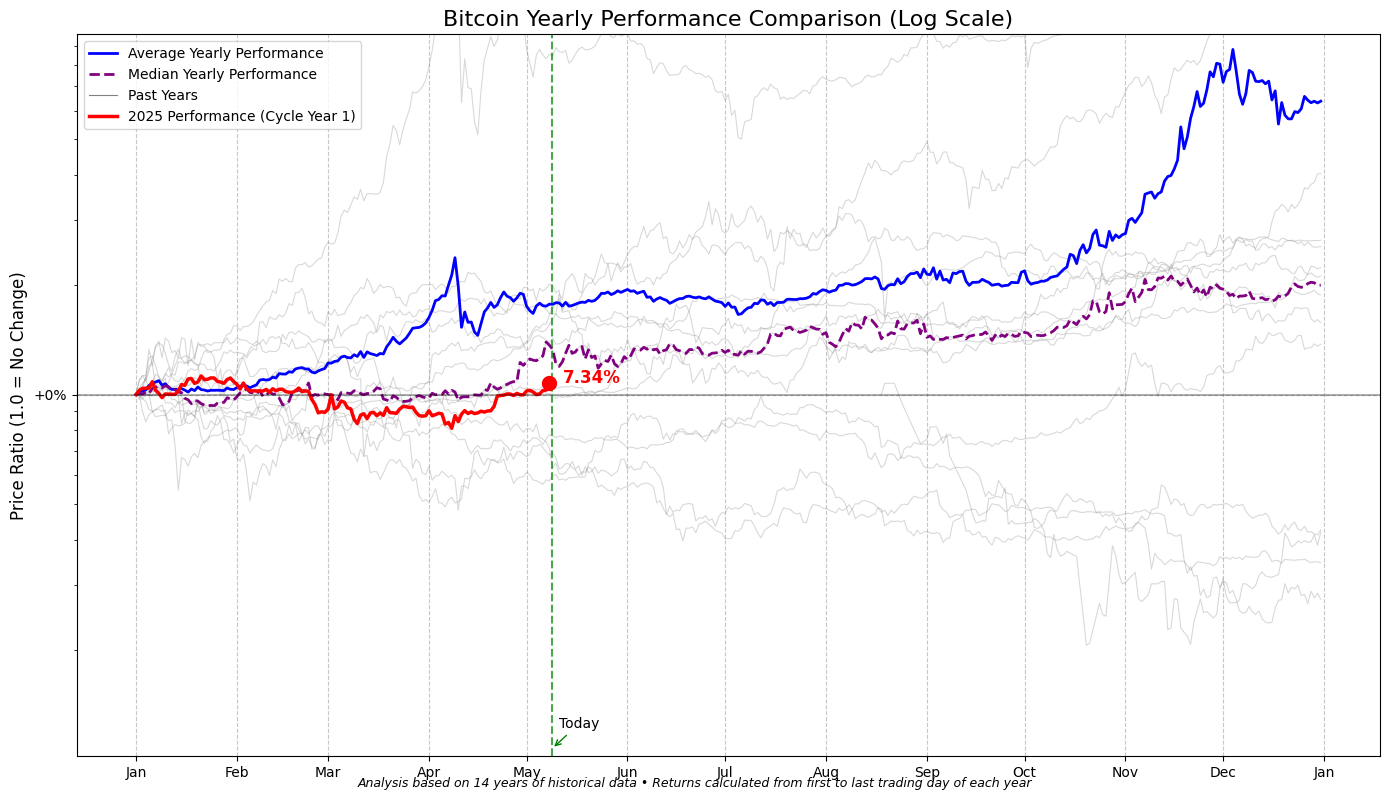

Analysis includes data from 14 years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024

Historical Year-End Returns (Full Year):
2013 (Cycle Year 1): +5437.07%
2017 (Cycle Year 1): +1291.13%
2020 (Cycle Year 4): +303.87%
2012 (Cycle Year 4): +164.80%
2023 (Cycle Year 3): +154.34%
2016 (Cycle Year 4): +122.74%
2024 (Cycle Year 4): +111.33%
2019 (Cycle Year 3): +87.48%
2021 (Cycle Year 1): +57.18%
2015 (Cycle Year 3): +37.31%
2014 (Cycle Year 2): -57.44%
2011 (Cycle Year 3): -57.98%
2022 (Cycle Year 2): -65.41%
2018 (Cycle Year 2): -72.53%

Average Year-End Return: +536.71%
Median Year-End Return: +111.33%

Returns by Cycle Year:
Cycle Year 1 (years: 2013, 2017, 2021):
  Average: +2261.79%
  Sample size: 3 years
Cycle Year 2 (years: 2014, 2022, 2018):
  Average: -65.12%
  Sample size: 3 years
Cycle Year 3 (years: 2023, 2019, 2015, 2011):
  Average: +55.29%
  Sample size: 4 years
Cycle Year 4 (years: 2020, 2012, 2016, 2024):
  Average: +175.69%
  Sample s

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

def plot_yearly_performance_comparison(df, cycle_year_filter=None):
    """
    Plot yearly performance comparison with optional filtering by Bitcoin cycle year.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing price data
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4).
        Can be a single integer or a list of integers.
        If None, all years are included.
    """
    # Ensure time is datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Add year column
    df['year'] = df['time'].dt.year
    
    # Add cycle year column (based on the 4-year Bitcoin cycle)
    # 2013, 2017, 2021, 2025 = Year 1
    # 2014, 2018, 2022 = Year 2
    # 2015, 2019, 2023 = Year 3
    # 2016, 2020, 2024 = Year 4
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Get current year
    current_year = datetime.now().year
    
    # Convert cycle_year_filter to list if it's a single integer
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
        
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
    
    # Get unique years excluding current year
    past_years = sorted(df[df['year'] < current_year]['year'].unique())
    
    # Filter past years by cycle year if specified
    if cycle_year_filter is not None:
        filtered_years = []
        for year in past_years:
            cycle_year = 1 + ((year - 2013) % 4)
            if cycle_year in cycle_year_filter:
                filtered_years.append(year)
        past_years = filtered_years
    
    # Create dataframe to store yearly performance data
    all_years_data = []
    
    # Process each past year
    for year in past_years:
        # Get data for this year
        year_data = df[df['year'] == year].copy()
        
        # Get the first trading day's close price
        if not year_data.empty:
            first_close = year_data.iloc[0]['close']
            
            # Calculate percentage change from first day
            year_data['pct_change'] = ((year_data['close'] - first_close) / first_close) * 100
            
            # Create a date column that's normalized to the current year for comparison
            year_data['normalized_date'] = year_data['time'].apply(
                lambda x: safe_date_replace(x, 2025)
            )
            
            # Add to our collection
            all_years_data.append(year_data)
    
    # Process current year data
    current_year_data = df[df['year'] == current_year].copy()
    
    # Only include current year if it matches the cycle year filter
    include_current_year = True
    if cycle_year_filter is not None:
        current_cycle_year = 1 + ((current_year - 2013) % 4)
        if current_cycle_year not in cycle_year_filter:
            include_current_year = False
    
    if not current_year_data.empty and include_current_year:
        # Get the first trading day's close price
        first_close = current_year_data.iloc[0]['close']
        
        # Calculate percentage change from first day
        current_year_data['pct_change'] = ((current_year_data['close'] - first_close) / first_close) * 100
        
        # Normalize date for overlay
        current_year_data['normalized_date'] = current_year_data['time'].apply(
            lambda x: safe_date_replace(x, 2025)
        )
    else:
        current_year_data = pd.DataFrame(columns=['normalized_date', 'pct_change'])
    
    # Combine all past years
    if all_years_data:
        past_years_df = pd.concat(all_years_data)
        
        # Calculate average for each calendar day
        avg_performance = past_years_df.groupby('normalized_date')['pct_change'].mean().reset_index()
        
        # Calculate median for each calendar day
        median_performance = past_years_df.groupby('normalized_date')['pct_change'].median().reset_index()
    else:
        past_years_df = pd.DataFrame(columns=['normalized_date', 'pct_change', 'year'])
        avg_performance = pd.DataFrame(columns=['normalized_date', 'pct_change'])
        median_performance = pd.DataFrame(columns=['normalized_date', 'pct_change'])
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot individual past years (thin gray lines)
    for year in past_years:
        year_data = past_years_df[past_years_df['year'] == year]
        cycle_year = 1 + ((year - 2013) % 4)
        plt.semilogy(year_data['normalized_date'], 
                 year_data['pct_change'].apply(lambda x: (100 + x) / 100), 
                 color='gray', 
                 alpha=0.3, 
                 linewidth=0.8, 
                 label=f'{year} (Cycle Year {cycle_year})' if year == past_years[0] else "")
    
    # Plot average performance
    if not avg_performance.empty:
        plt.semilogy(avg_performance['normalized_date'], 
                 avg_performance['pct_change'].apply(lambda x: (100 + x) / 100), 
                 color='blue', 
                 linewidth=2, 
                 label='Average Yearly Performance')
    
    # Plot median performance
    if not median_performance.empty:
        plt.semilogy(median_performance['normalized_date'], 
                 median_performance['pct_change'].apply(lambda x: (100 + x) / 100), 
                 color='purple', 
                 linewidth=2, 
                 linestyle='--',
                 label='Median Yearly Performance')
    
    # Plot current year performance if it matches filter
    if not current_year_data.empty and include_current_year:
        current_cycle_year = 1 + ((current_year - 2013) % 4)
        plt.semilogy(current_year_data['normalized_date'], 
                 current_year_data['pct_change'].apply(lambda x: (100 + x) / 100), 
                 color='red', 
                 linewidth=2.5, 
                 label=f'{current_year} Performance (Cycle Year {current_cycle_year})')
        
        # Add a dot at the last point of current year
        last_point = current_year_data.iloc[-1]
        plt.scatter(last_point['normalized_date'], 
                    (100 + last_point['pct_change']) / 100, 
                    color='red', 
                    s=100, 
                    zorder=5)
        
        # Add annotation for current position
        plt.annotate(f"{last_point['pct_change']:.2f}%", 
                     xy=(last_point['normalized_date'], (100 + last_point['pct_change']) / 100),
                     xytext=(10, 0),
                     textcoords="offset points",
                     fontsize=12,
                     fontweight='bold',
                     color='red')
    
    # Add horizontal line at 1.0 (no change)
    plt.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)
    
    # Create title based on cycle year filter
    if cycle_year_filter is not None:
        cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        title = f"Bitcoin Yearly Performance Comparison - Cycle {cycle_years_str} Only (Log Scale)"
    else:
        title = f"Bitcoin Yearly Performance Comparison (Log Scale)"
    
    # Format the chart
    plt.title(title, fontsize=16)
    plt.ylabel("Price Ratio (1.0 = No Change)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format y-axis as multiples
    from matplotlib.ticker import FuncFormatter
    def price_ratio_formatter(y, pos):
        # Convert price ratio to percentage change
        pct_change = (y - 1) * 100
        if pct_change >= 0:
            return f"+{pct_change:.0f}%"
        else:
            return f"{pct_change:.0f}%"
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(price_ratio_formatter))
    
    # Set y-axis limits to be symmetrical in terms of percentage change
    y_vals = []
    if not avg_performance.empty:
        y_vals.extend((100 + avg_performance['pct_change']) / 100)
    if not median_performance.empty:
        y_vals.extend((100 + median_performance['pct_change']) / 100)
    if not current_year_data.empty and include_current_year:
        y_vals.extend((100 + current_year_data['pct_change']) / 100)
    if y_vals:
        max_ratio = max(y_vals)
        min_ratio = min(y_vals)
        
        # Ensure we include 1.0 in the view
        max_ratio = max(max_ratio, 1.0)
        min_ratio = min(min_ratio, 1.0)
        
        # Make it symmetrical in percentage terms
        max_pct_change = (max_ratio - 1)
        min_pct_change = (min_ratio - 1)
        
        # If max change is larger in absolute terms, set min limit based on max
        if abs(max_pct_change) > abs(min_pct_change):
            inverse_max = 1 / (1 + max_pct_change)
            plt.ylim(max(0.1, inverse_max * 0.9), max_ratio * 1.1)
        # If min change is larger in absolute terms, set max limit based on min
        else:
            inverse_min = 1 / (1 + min_pct_change)
            plt.ylim(min_ratio * 0.9, min(10, inverse_min * 1.1))
    
    # Format x-axis to show months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Add today's date marker
    today_normalized = safe_date_replace(datetime.now(), 2025)
    plt.axvline(x=today_normalized, color='green', linestyle='--', alpha=0.7)
    plt.annotate('Today', 
                 xy=(today_normalized, plt.gca().get_ylim()[0] * 1.05),
                 xytext=(5, 15),
                 textcoords="offset points",
                 fontsize=10,
                 arrowprops=dict(arrowstyle="->", color='green'))
    
    # Create legend with all needed entries
    legend_entries = []
    
    # Add individual entries in the order we want them
    if not avg_performance.empty:
        legend_entries.append(('Average Yearly Performance', 'blue', '-', 2))
    
    if not median_performance.empty:
        legend_entries.append(('Median Yearly Performance', 'purple', '--', 2))
    
    if past_years:
        # Create legend label that includes cycle years if filtered
        if cycle_year_filter is not None:
            past_years_label = f'Past Years (Cycle {cycle_years_str})'
        else:
            past_years_label = 'Past Years'
        legend_entries.append((past_years_label, 'gray', '-', 0.8))
    
    if not current_year_data.empty and include_current_year:
        current_cycle_year = 1 + ((current_year - 2013) % 4)
        legend_entries.append((f'{current_year} Performance (Cycle Year {current_cycle_year})', 'red', '-', 2.5))
    
    # Create custom legend handles
    custom_lines = []
    custom_labels = []
    
    for label, color, style, width in legend_entries:
        line = plt.Line2D([0], [0], color=color, linewidth=width, linestyle=style)
        custom_lines.append(line)
        custom_labels.append(label)
    
    plt.legend(custom_lines, custom_labels, loc='best')
    
    # Add additional information
    num_years = len(past_years)
    
    # Create footer text based on cycle year filter
    if cycle_year_filter is not None:
        cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        filtered_text = f" (Filtered to Cycle {cycle_years_str} only)"
    else:
        filtered_text = ""
    
    plt.figtext(0.5, 0.01, 
                f"Analysis based on {num_years} years of historical data{filtered_text} • Returns calculated from first to last trading day of each year",
                ha="center", fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    if cycle_year_filter is not None:
        print(f"Analysis includes {num_years} years matching cycle year(s) {cycle_years_str}: {', '.join(map(str, past_years))}")
    else:
        print(f"Analysis includes data from {num_years} years: {', '.join(map(str, past_years))}")
    
    # Map years to cycle years for display
    year_to_cycle = {year: 1 + ((year - 2013) % 4) for year in past_years}
    
    # Calculate year-end returns for historical context
    if all_years_data:
        year_end_returns = []
        for year in past_years:
            year_data = df[df['year'] == year].copy().sort_values('time')
            if not year_data.empty:
                first_price = year_data.iloc[0]['close']
                last_price = year_data.iloc[-1]['close']
                year_return = ((last_price - first_price) / first_price) * 100
                cycle_year = year_to_cycle[year]
                year_end_returns.append((year, cycle_year, year_return))
        
        # Sort by return
        year_end_returns.sort(key=lambda x: x[2], reverse=True)
        
        print("\nHistorical Year-End Returns (Full Year):")
        for year, cycle_year, ret in year_end_returns:
            print(f"{year} (Cycle Year {cycle_year}): {ret:+.2f}%")
        
        # Calculate statistics
        returns_only = [r for _, _, r in year_end_returns]
        avg_return = sum(returns_only) / len(returns_only)
        median_return = sorted(returns_only)[len(returns_only) // 2]
        
        if cycle_year_filter is not None:
            print(f"\nAverage Year-End Return (Cycle {cycle_years_str}): {avg_return:+.2f}%")
            print(f"Median Year-End Return (Cycle {cycle_years_str}): {median_return:+.2f}%")
        else:
            print(f"\nAverage Year-End Return: {avg_return:+.2f}%")
            print(f"Median Year-End Return: {median_return:+.2f}%")
        
        # Group returns by cycle year and display stats
        cycle_returns = {}
        for year, cycle_year, ret in year_end_returns:
            if cycle_year not in cycle_returns:
                cycle_returns[cycle_year] = []
            cycle_returns[cycle_year].append(ret)
        
        print("\nReturns by Cycle Year:")
        for cycle_year in sorted(cycle_returns.keys()):
            returns = cycle_returns[cycle_year]
            avg = sum(returns) / len(returns)
            years_str = ", ".join([str(year) for year, cy, _ in year_end_returns if cy == cycle_year])
            print(f"Cycle Year {cycle_year} (years: {years_str}):")
            print(f"  Average: {avg:+.2f}%")
            print(f"  Sample size: {len(returns)} years")

# Helper function to safely handle date replacement, especially for leap years
def safe_date_replace(dt, new_year):
    """
    Safely replace the year of a datetime, handling leap years correctly.
    If February 29 is being converted to a non-leap year, it returns February 28.
    """
    try:
        return dt.replace(year=new_year)
    except ValueError:
        # This will happen with Feb 29 in leap years
        if dt.month == 2 and dt.day == 29:
            return datetime(new_year, 2, 28, 
                           dt.hour, dt.minute, dt.second, 
                           dt.microsecond, dt.tzinfo)
        else:
            raise  # Re-raise for any other ValueError

# Example usage:
# Load data
# file_path = "BITSTAMP_BTCUSD, 1D.csv"
# df = pd.read_csv(file_path)

# Run the analysis for all cycle years
plot_yearly_performance_comparison(df)

# Run the analysis for cycle year 1 only
#plot_yearly_performance_comparison(df, cycle_year_filter=1)

# Run the analysis for cycle years 1 and 3
# plot_yearly_performance_comparison(df, cycle_year_filter=[1, 3])

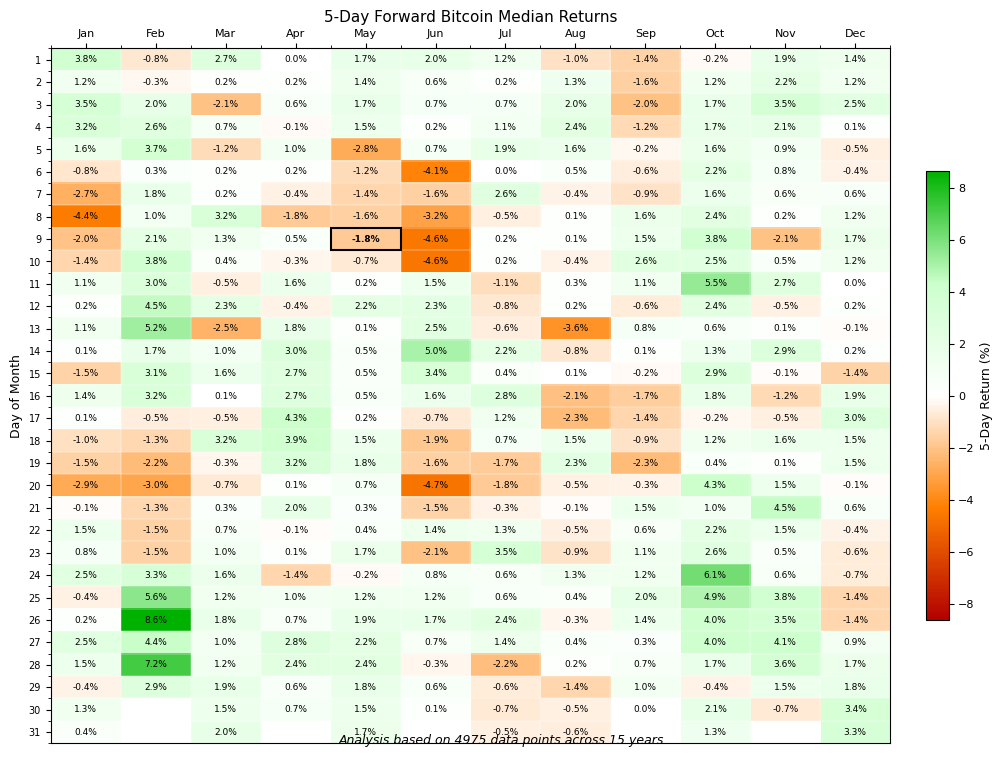

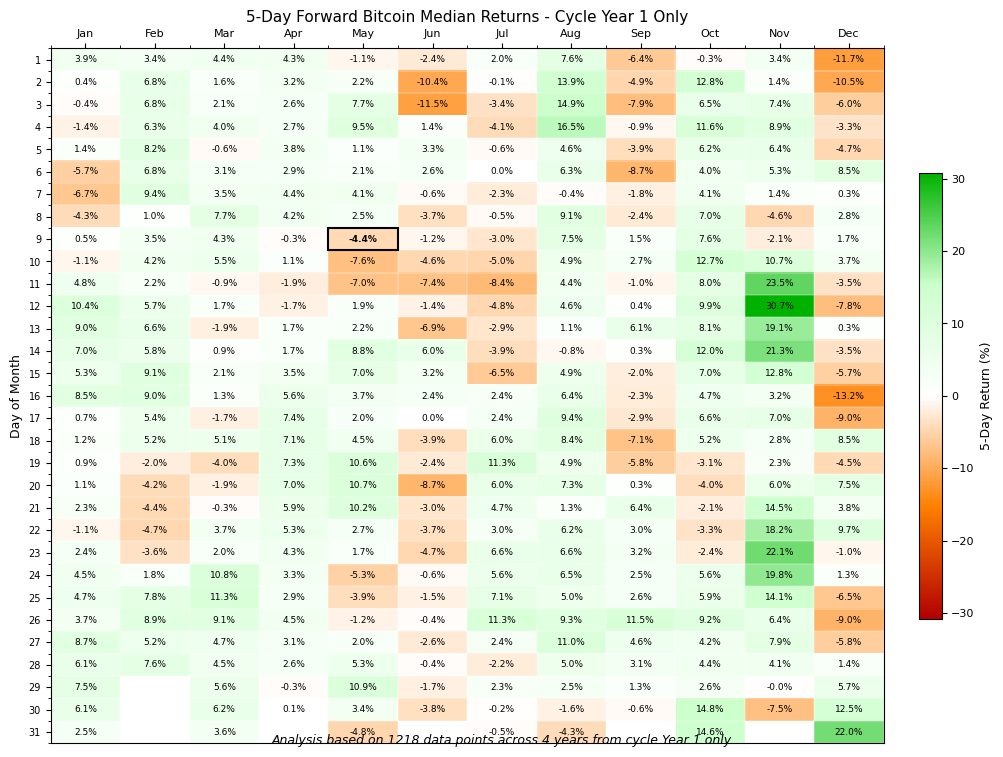

In [89]:
def analyze_calendar_day_returns_fixed(df, forward_days=5, highlight_today=True, use_average=True, cycle_year_filter=None):
    """
    Fixed version of analyze_calendar_day_returns that properly handles cycle year boundaries.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_full = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_full['time']):
        df_full['time'] = pd.to_datetime(df_full['time'])
    
    # Add year column
    df_full['year'] = df_full['time'].dt.year
    df_full['month'] = df_full['time'].dt.month
    df_full['day'] = df_full['time'].dt.day
    
    # Add cycle year column
    df_full['cycle_year'] = df_full['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Create a dataframe that we'll filter for entry dates only
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
        
        # Filter the entry dates dataframe
        df_entries = df_full[df_full['cycle_year'].isin(cycle_year_filter)].copy()
    else:
        df_entries = df_full.copy()
    
    # Sort both dataframes by time
    df_full = df_full.sort_values('time')
    df_entries = df_entries.sort_values('time')
    
    # Calculate forward returns - using df_entries for entry points but df_full for exit points
    result_data = []
    
    for idx, entry_row in df_entries.iterrows():
        entry_date = entry_row['time']
        entry_price = entry_row['close']
        
        # Calculate target exit date
        exit_date = entry_date + pd.Timedelta(days=forward_days)
        
        # Find the closest date to the exit date in the full dataframe
        future_data = df_full[df_full['time'] >= exit_date]
        
        # Skip if no future data available
        if future_data.empty:
            continue
        
        # Get the first available price after the forward period
        exit_row = future_data.iloc[0]
        exit_price = exit_row['close']
        
        # Calculate return
        forward_return = ((exit_price - entry_price) / entry_price) * 100
        
        # Ensure we're not calculating across a gap larger than 2x the forward_days
        # This prevents unreasonable date jumps in case of large gaps in the data
        actual_days = (exit_row['time'] - entry_date).days
        if actual_days > forward_days * 2:
            continue
        
        result_data.append({
            'date': entry_date,
            'day': entry_date.day,
            'month': entry_date.month,
            'year': entry_date.year,
            'cycle_year': 1 + ((entry_date.year - 2013) % 4),
            'forward_return': forward_return,
            'exit_date': exit_row['time'],
            'actual_days': actual_days
        })
    
    # Convert to dataframe
    result_df = pd.DataFrame(result_data)
    
    # Rest of the function remains the same as before
    # Calculate returns by day and month - either mean or median
    aggfunc = 'mean' if use_average else 'median'
    stat_type = 'Average' if use_average else 'Median'
    
    # Calculate counts for each cell for reference
    pivot_counts = result_df.pivot_table(
        index='day', 
        columns='month', 
        values='forward_return',
        aggfunc='count'
    )
    
    # Calculate mean or median returns
    pivot_table = result_df.pivot_table(
        index='day', 
        columns='month', 
        values='forward_return',
        aggfunc=aggfunc
    )
    
    # Ensure all days 1-31 are included
    all_days = pd.DataFrame(index=range(1, 32))
    pivot_table = all_days.join(pivot_table)
    pivot_counts = all_days.join(pivot_counts)
    
    # Month names mapping
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7.5))
    
    # Create custom colormap with amber included
    # Red -> Amber -> White -> Light Green -> Green
    max_abs_val = max(abs(pivot_table.min().min()), abs(pivot_table.max().max()))
    
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'red_amber_green', 
        [
            (0.7, 0, 0),         # Dark red (strongly negative)
            (1, 0.5, 0),         # Amber/orange (slightly negative)
            (1, 1, 1),           # White (neutral)
            (0.8, 1, 0.8),       # Light green (slightly positive)
            (0, 0.7, 0)          # Dark green (strongly positive)
        ], 
        N=256
    )
    norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)
    
    # Create heatmap
    im = ax.imshow(pivot_table.values, cmap=cmap, norm=norm, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.set_label(f'{forward_days}-Day Return (%)', fontsize=9, color='black')
    cbar.ax.tick_params(labelsize=8, color='black')
    cbar.ax.yaxis.set_tick_params(color='black')
    cbar.ax.yaxis.label.set_color('black')
    
    # Configure axes
    ax.set_yticks(np.arange(len(pivot_table.index)))
    ax.set_xticks(np.arange(len(pivot_table.columns)))
    ax.set_yticklabels(pivot_table.index, fontsize=7, color='black')
    ax.set_xticklabels([month_names[m] for m in pivot_table.columns], fontsize=8, color='black')
    
    # Move month labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Add thin gridlines
    ax.set_xticks(np.arange(-.5, len(pivot_table.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(pivot_table.index), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    
    # Get today's date for highlighting
    today = datetime.now()
    today_day = today.day
    today_month = today.month
    
    # Add value annotations with black text
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            value = pivot_table.iloc[i, j]
            is_today = (pivot_table.index[i] == today_day and pivot_table.columns[j] == today_month)
            
            if not np.isnan(value):
                # Highlight today's cell
                if highlight_today and is_today:
                    rect = plt.Rectangle(
                        (j-0.5, i-0.5), 1, 1, fill=False, 
                        edgecolor='black', linewidth=1.5, zorder=5
                    )
                    ax.add_patch(rect)
                
                # Add return value
                ax.text(j, i, f"{value:.1f}%", 
                       ha="center", va="center", 
                       color='black',
                       fontsize=6.5,
                       fontweight='bold' if is_today else 'normal')
    
    # Create title based on parameters
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        title = f'{forward_days}-Day Forward Bitcoin {stat_type} Returns - Cycle {cycle_years_str} Only'
    else:
        title = f'{forward_days}-Day Forward Bitcoin {stat_type} Returns'
    
    # Add title and labels
    ax.set_title(title, fontsize=11, pad=5, color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Day of Month', fontsize=9, color='black')
    
    # Set all ticks to black
    ax.tick_params(axis='both', colors='black')
    
    # Add footer with sample information
    total_samples = result_df.shape[0]
    years_included = result_df['year'].nunique()
    
    if cycle_year_filter is not None:
        cycle_info = f" from cycle {cycle_years_str} only"
    else:
        cycle_info = ""
    
    plt.figtext(0.5, 0.01, 
                f"Analysis based on {total_samples} data points across {years_included} years{cycle_info}",
                ha="center", fontsize=9, style='italic')
    
    # Tight layout
    plt.tight_layout(pad=0.6)
    plt.show()
    
    return pivot_table, pivot_counts, result_df

# Then fix the function call by using analyze_calendar_day_returns_fixed
calendar_returns = analyze_calendar_day_returns_fixed(df, forward_days=5, use_average=False)

# The rest of your code remains the same
returns, counts, result_data = analyze_calendar_day_returns_fixed(
    df,
    forward_days=5,
    use_average=False,  # Use mean instead of median
    cycle_year_filter=1  # Just Year 1 cycle
)

# Compare different forward periods for Cycle Year 4
# First, short-term (5 days)
#short_term, _, _ = analyze_calendar_day_returns_fixed(
#    df,
#    forward_days=5,
#    cycle_year_filter=4
#)

# Then, medium-term (14 days)
#medium_term, _, _ = analyze_calendar_day_returns_fixed(
#    df,
#    forward_days=14,
#    cycle_year_filter=4
#)

# Finally, long-term (30 days)
#long_term, _, _ = analyze_calendar_day_returns_fixed(
#    df,
#    forward_days=30,
#    cycle_year_filter=4
#)


Analyzing consecutive returns until sign change...
       Day  Return (%)  Cumulative ($)  Cumulative (%)
0    Day 1        -2.8       97.200000       -2.800000
1    Day 2        -1.2       96.033600       -3.966400
2    Day 3        -1.4       94.689130       -5.310870
3    Day 4        -1.6       93.174104       -6.825896
4    Day 5        -1.8       91.496970       -8.503030
5    Day 6        -0.7       90.856491       -9.143509
6  Summary        -9.5       90.856491       -9.143509


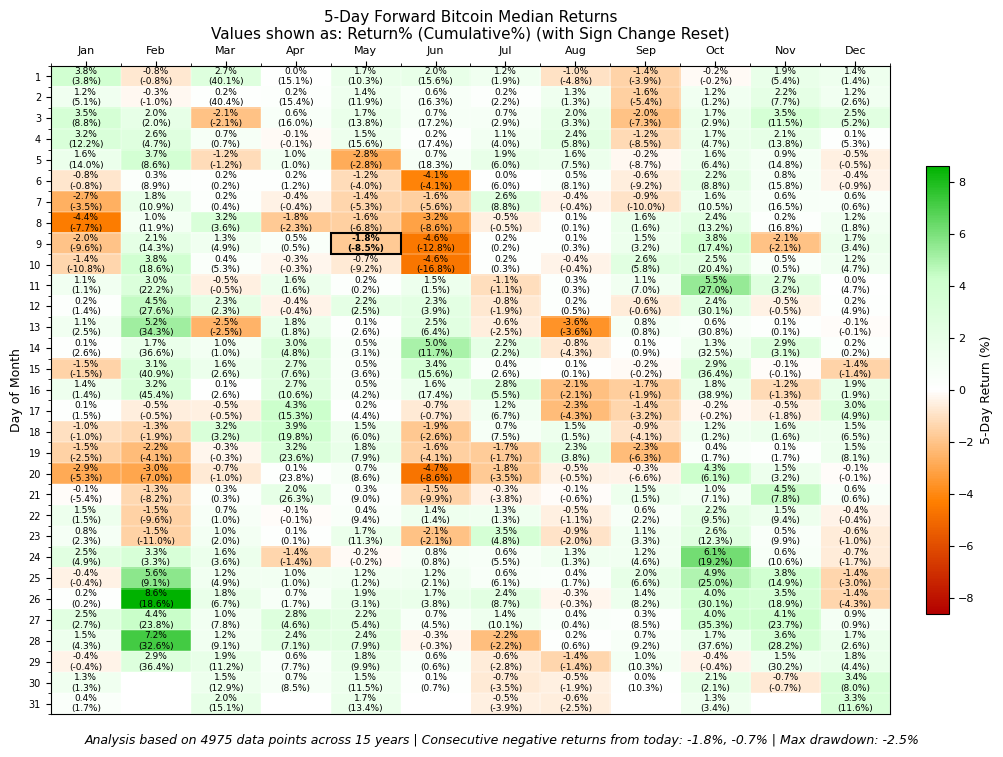

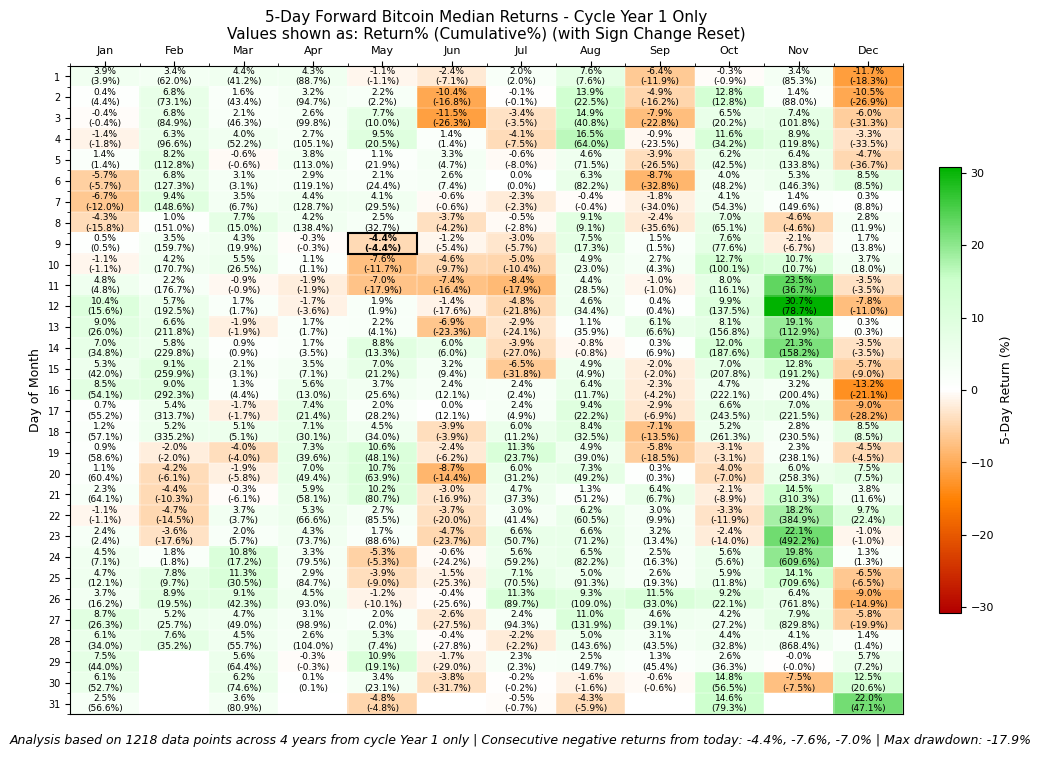


Consecutive returns from today until sign change:
       Day  Return (%)  Cumulative ($)  Cumulative (%)
0    Day 1   -4.430154       95.569846       -4.430154
1    Day 2   -7.591179       88.314968      -11.685032
2    Day 3   -7.004293       82.129129      -17.870871
3  Summary  -19.025626       82.129129      -17.870871


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime

def analyze_rolling_drawdowns(returns_series, reset_on_sign_change=True):
    """
    Calculate the rolling drawdowns and positive gains from a series of returns.
    The calculation resets when the return changes sign (from positive to negative or vice versa).
    
    Parameters:
    returns_series: Series or list of percentage returns
    reset_on_sign_change: If True, reset the compound return when the sign changes
    
    Returns:
    tuple of (rolling_returns, max_drawdown, max_gain)
    """
    if isinstance(returns_series, list):
        returns_series = pd.Series(returns_series)
    
    # Initialize variables
    rolling_returns = []
    current_compound = 100  # Start with $100
    max_drawdown = 0
    max_gain = 0
    peak = 100
    trough = 100
    
    # Track whether we're in a positive or negative streak
    last_sign = None
    
    for ret in returns_series:
        # Determine current sign
        current_sign = 1 if ret >= 0 else -1
        
        # Reset compound if sign changed and we're using reset mode
        if reset_on_sign_change and last_sign is not None and current_sign != last_sign:
            current_compound = 100
            peak = 100
            trough = 100
        
        # Update the compound value
        current_compound *= (1 + ret/100)
        rolling_returns.append(current_compound)
        
        # Update last sign
        last_sign = current_sign
        
        # Track peak and trough for this streak
        if current_sign == 1:  # Positive returns
            peak = max(peak, current_compound)
            max_gain = max(max_gain, (peak - 100))
        else:  # Negative returns
            trough = min(trough, current_compound)
            max_drawdown = min(max_drawdown, (trough - 100))
    
    return rolling_returns, max_drawdown, max_gain

def analyze_calendar_day_returns_fixed(df, forward_days=5, highlight_today=True, use_average=True, cycle_year_filter=None, reset_on_sign_change=True):
    """
    Fixed version of analyze_calendar_day_returns that properly handles cycle year boundaries
    and adds cumulative returns column.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_full = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_full['time']):
        df_full['time'] = pd.to_datetime(df_full['time'])
    
    # Add year column
    df_full['year'] = df_full['time'].dt.year
    df_full['month'] = df_full['time'].dt.month
    df_full['day'] = df_full['time'].dt.day
    
    # Add cycle year column
    df_full['cycle_year'] = df_full['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Create a dataframe that we'll filter for entry dates only
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
        
        # Filter the entry dates dataframe
        df_entries = df_full[df_full['cycle_year'].isin(cycle_year_filter)].copy()
    else:
        df_entries = df_full.copy()
    
    # Sort both dataframes by time
    df_full = df_full.sort_values('time')
    df_entries = df_entries.sort_values('time')
    
    # Calculate forward returns - using df_entries for entry points but df_full for exit points
    result_data = []
    
    for idx, entry_row in df_entries.iterrows():
        entry_date = entry_row['time']
        entry_price = entry_row['close']
        
        # Calculate target exit date
        exit_date = entry_date + pd.Timedelta(days=forward_days)
        
        # Find the closest date to the exit date in the full dataframe
        future_data = df_full[df_full['time'] >= exit_date]
        
        # Skip if no future data available
        if future_data.empty:
            continue
        
        # Get the first available price after the forward period
        exit_row = future_data.iloc[0]
        exit_price = exit_row['close']
        
        # Calculate return
        forward_return = ((exit_price - entry_price) / entry_price) * 100
        
        # Ensure we're not calculating across a gap larger than 2x the forward_days
        # This prevents unreasonable date jumps in case of large gaps in the data
        actual_days = (exit_row['time'] - entry_date).days
        if actual_days > forward_days * 2:
            continue
        
        result_data.append({
            'date': entry_date,
            'day': entry_date.day,
            'month': entry_date.month,
            'year': entry_date.year,
            'cycle_year': 1 + ((entry_date.year - 2013) % 4),
            'forward_return': forward_return,
            'exit_date': exit_row['time'],
            'actual_days': actual_days
        })
    
    # Convert to dataframe
    result_df = pd.DataFrame(result_data)
    
    # Rest of the function remains the same as before
    # Calculate returns by day and month - either mean or median
    aggfunc = 'mean' if use_average else 'median'
    stat_type = 'Average' if use_average else 'Median'
    
    # Calculate counts for each cell for reference
    pivot_counts = result_df.pivot_table(
        index='day', 
        columns='month', 
        values='forward_return',
        aggfunc='count'
    )
    
    # Calculate mean or median returns
    pivot_table = result_df.pivot_table(
        index='day', 
        columns='month', 
        values='forward_return',
        aggfunc=aggfunc
    )
    
    # Ensure all days 1-31 are included
    all_days = pd.DataFrame(index=range(1, 32))
    pivot_table = all_days.join(pivot_table)
    pivot_counts = all_days.join(pivot_counts)
    
    # Month names mapping
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    
    # Create the cumulative returns calculation
    # First, flatten the pivot table to a sequence of returns by day
    flat_returns = []
    flat_dates = []
    
    for month in range(1, 13):
        for day in range(1, 32):
            if day in pivot_table.index and month in pivot_table.columns:
                value = pivot_table.loc[day, month]
                if not np.isnan(value):
                    flat_returns.append(value)
                    flat_dates.append(f"{day:02d}-{month:02d}")
    
    # Calculate rolling drawdowns for the flat returns
    if flat_returns:
        rolling_returns, max_drawdown, max_gain = analyze_rolling_drawdowns(
            flat_returns, 
            reset_on_sign_change=reset_on_sign_change
        )
        
        # Convert to percentage change from $100
        cumulative_returns = [(r - 100) for r in rolling_returns]
        
        # Create a DataFrame to map dates back to cumulative returns
        cumulative_df = pd.DataFrame({
            'date_str': flat_dates,
            'cumulative_return': cumulative_returns
        })
        
        # Parse date strings to match with pivot table
        cumulative_df['day'] = cumulative_df['date_str'].apply(lambda x: int(x.split('-')[0]))
        cumulative_df['month'] = cumulative_df['date_str'].apply(lambda x: int(x.split('-')[1]))
        
        # Create a pivot table of cumulative returns
        cumulative_pivot = cumulative_df.pivot_table(
            index='day',
            columns='month',
            values='cumulative_return',
            aggfunc='first'  # Take the first value since there should only be one
        )
        
        # Ensure all days 1-31 are included in cumulative pivot
        cumulative_pivot = all_days.join(cumulative_pivot)
    else:
        cumulative_pivot = pd.DataFrame(index=range(1, 32), columns=range(1, 13))
        max_drawdown = 0
        max_gain = 0
    
    # Get today's date for highlighting and consecutive analysis
    today = datetime.now()
    today_day = today.day
    today_month = today.month
    
    # Find today's position in the pivot table
    if today_day in pivot_table.index and today_month in pivot_table.columns:
        today_value = pivot_table.loc[today_day, today_month]
        has_today = not np.isnan(today_value)
    else:
        today_value = np.nan
        has_today = False
    
    # Find consecutive returns of same sign starting from today
    consecutive_returns = []
    
    # Only analyze if today's value exists and is valid
    if has_today:
        today_sign = 1 if today_value >= 0 else -1
        consecutive_returns.append(today_value)
        
        # Loop through calendar days after today
        found_day = False
        for month in range(today_month, 13):
            # Start from the next day in the current month, or from day 1 in future months
            start_day = today_day + 1 if month == today_month else 1
            
            for day in range(start_day, 32):
                if day in pivot_table.index and month in pivot_table.columns:
                    value = pivot_table.loc[day, month]
                    if not np.isnan(value):
                        found_day = True
                        current_sign = 1 if value >= 0 else -1
                        if current_sign == today_sign:
                            consecutive_returns.append(value)
                        else:
                            # Stop if sign changes
                            break
            
            # If we found a day with opposite sign, stop looking in future months
            if found_day and len(consecutive_returns) > 1 and current_sign != today_sign:
                break
    
    # Calculate consecutive returns analysis if available
    if consecutive_returns:
        consec_rolling_returns, consec_max_dd, consec_max_gain = analyze_rolling_drawdowns(
            consecutive_returns, reset_on_sign_change=False
        )
        
        # Convert to percentage changes
        consec_cumulative = [(r - 100) for r in consec_rolling_returns]
    else:
        consec_rolling_returns = []
        consec_cumulative = []
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7.5))
    
    # Create custom colormap with amber included
    # Red -> Amber -> White -> Light Green -> Green
    max_abs_val = max(abs(pivot_table.min().min()), abs(pivot_table.max().max()))
    
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'red_amber_green', 
        [
            (0.7, 0, 0),         # Dark red (strongly negative)
            (1, 0.5, 0),         # Amber/orange (slightly negative)
            (1, 1, 1),           # White (neutral)
            (0.8, 1, 0.8),       # Light green (slightly positive)
            (0, 0.7, 0)          # Dark green (strongly positive)
        ], 
        N=256
    )
    norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)
    
    # Create heatmap
    im = ax.imshow(pivot_table.values, cmap=cmap, norm=norm, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.set_label(f'{forward_days}-Day Return (%)', fontsize=9, color='black')
    cbar.ax.tick_params(labelsize=8, color='black')
    cbar.ax.yaxis.set_tick_params(color='black')
    cbar.ax.yaxis.label.set_color('black')
    
    # Configure axes
    ax.set_yticks(np.arange(len(pivot_table.index)))
    ax.set_xticks(np.arange(len(pivot_table.columns)))
    ax.set_yticklabels(pivot_table.index, fontsize=7, color='black')
    ax.set_xticklabels([month_names[m] for m in pivot_table.columns], fontsize=8, color='black')
    
    # Move month labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Add thin gridlines
    ax.set_xticks(np.arange(-.5, len(pivot_table.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(pivot_table.index), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    
    # Add value annotations with black text
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            value = pivot_table.iloc[i, j]
            cumul_value = cumulative_pivot.iloc[i, j] if not cumulative_pivot.empty else np.nan
            is_today = (pivot_table.index[i] == today_day and pivot_table.columns[j] == today_month)
            
            if not np.isnan(value):
                # Highlight today's cell
                if highlight_today and is_today:
                    rect = plt.Rectangle(
                        (j-0.5, i-0.5), 1, 1, fill=False, 
                        edgecolor='black', linewidth=1.5, zorder=5
                    )
                    ax.add_patch(rect)
                
                # Create text with both values - return and cumulative
                if not np.isnan(cumul_value):
                    combined_text = f"{value:.1f}%\n({cumul_value:.1f}%)"
                else:
                    combined_text = f"{value:.1f}%"
                
                # Add return value
                ax.text(j, i, combined_text, 
                       ha="center", va="center", 
                       color='black',
                       fontsize=6.5,
                       fontweight='bold' if is_today else 'normal')
    
    # Create title based on parameters
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        title = f'{forward_days}-Day Forward Bitcoin {stat_type} Returns - Cycle {cycle_years_str} Only'
    else:
        title = f'{forward_days}-Day Forward Bitcoin {stat_type} Returns'
    
    reset_mode = " (with Sign Change Reset)" if reset_on_sign_change else " (Continuous Compound)"
    
    # Add title and labels
    ax.set_title(title + "\nValues shown as: Return% (Cumulative%)" + reset_mode, fontsize=11, pad=5, color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Day of Month', fontsize=9, color='black')
    
    # Set all ticks to black
    ax.tick_params(axis='both', colors='black')
    
    # Add footer with sample information
    total_samples = result_df.shape[0]
    years_included = result_df['year'].nunique()
    
    if cycle_year_filter is not None:
        cycle_info = f" from cycle {cycle_years_str} only"
    else:
        cycle_info = ""
    
    # Add footer text
    footer_text = f"Analysis based on {total_samples} data points across {years_included} years{cycle_info}"
    
    # Add consecutive returns information if available
    if consecutive_returns:
        today_sign_text = "negative" if today_value < 0 else "positive"
        consecutive_txt = f" | Consecutive {today_sign_text} returns from today: "
        consecutive_txt += ", ".join([f"{r:.1f}%" for r in consecutive_returns])
        
        # Add max drawdown/gain info
        if today_value < 0:
            consecutive_txt += f" | Max drawdown: {consec_cumulative[-1]:.1f}%"
        else:
            consecutive_txt += f" | Max gain: {consec_cumulative[-1]:.1f}%"
            
        footer_text += consecutive_txt
    
    plt.figtext(0.5, 0.01, footer_text, ha="center", fontsize=9, style='italic')
    
    # Tight layout
    plt.tight_layout(pad=0.6)
    plt.subplots_adjust(bottom=0.05)
    plt.show()
    
    # Create DataFrame for consecutive returns analysis
    if consecutive_returns:
        days_list = [f"Day {i+1}" for i in range(len(consecutive_returns))]
        consecutive_df = pd.DataFrame({
            'Day': days_list,
            'Return (%)': consecutive_returns,
            'Cumulative ($)': consec_rolling_returns,
            'Cumulative (%)': consec_cumulative
        })
        
        # Add summary row
        summary = {
            'Day': 'Summary',
            'Return (%)': sum(consecutive_returns),
            'Cumulative ($)': consec_rolling_returns[-1],
            'Cumulative (%)': consec_cumulative[-1]
        }
        consecutive_df = pd.concat([consecutive_df, pd.DataFrame([summary])], ignore_index=True)
    else:
        consecutive_df = pd.DataFrame()
    
    return pivot_table, cumulative_pivot, consecutive_df, result_df

def analyze_specific_consecutive_days(returns_list, days_list=None):
    """
    Analyze specific consecutive daily returns provided as a list,
    continuing until the sign changes.
    
    Parameters:
    returns_list: List of percentage returns for consecutive days
    days_list: Optional list of day labels
    
    Returns:
    DataFrame with the combined results
    """
    # Get the starting sign
    if not returns_list:
        return pd.DataFrame()
    
    start_sign = 1 if returns_list[0] >= 0 else -1
    
    # Find where the sign changes
    stop_idx = len(returns_list)
    for i in range(1, len(returns_list)):
        current_sign = 1 if returns_list[i] >= 0 else -1
        if current_sign != start_sign:
            stop_idx = i
            break
    
    # Get just the consecutive returns of the same sign
    consecutive_returns = returns_list[:stop_idx]
    
    # Create day labels if not provided
    if days_list is None:
        days_list = [f"Day {i+1}" for i in range(len(consecutive_returns))]
    else:
        days_list = days_list[:stop_idx]
    
    # Calculate rolling returns
    rolling_returns = []
    current_compound = 100
    
    for ret in consecutive_returns:
        current_compound *= (1 + ret/100)
        rolling_returns.append(current_compound)
    
    # Create a DataFrame with the combined results
    result_df = pd.DataFrame({
        'Day': days_list,
        'Return (%)': consecutive_returns,
        'Cumulative ($)': rolling_returns,
        'Cumulative (%)': [r - 100 for r in rolling_returns]
    })
    
    # Add summary row
    summary = {
        'Day': 'Summary',
        'Return (%)': sum(consecutive_returns),
        'Cumulative ($)': rolling_returns[-1],
        'Cumulative (%)': rolling_returns[-1] - 100
    }
    result_df = pd.concat([result_df, pd.DataFrame([summary])], ignore_index=True)
    
    return result_df

# Example usage:
if __name__ == "__main__":
    # Example: Analyzing specific consecutive returns until sign changes
    specific_returns = [-2.8, -1.2, -1.4, -1.6, -1.8, -0.7, 1.5, 2.0]  # Notice the sign change at index 6
    days_list = ["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8"]
    
    print("Analyzing consecutive returns until sign change...")
    results_df = analyze_specific_consecutive_days(specific_returns, days_list=days_list)
    print(results_df)  # This will only include the first 6 days (negative returns)
    
    # Example 2: With CSV data - uncomment to use
   
   
    
    # Get the calendar returns with cumulative column and consecutive analysis from today
    returns, cumulative, consecutive_analysis, data = analyze_calendar_day_returns_fixed(
        df,
        forward_days=5,
        use_average=False,  # Use median instead of mean
        #cycle_year_filter=1,  # Just Year 1 cycle
        reset_on_sign_change=True  # Reset when sign changes
    )

     # Get the calendar returns with cumulative column and consecutive analysis from today
    returns, cumulative, consecutive_analysis, data = analyze_calendar_day_returns_fixed(
        df,
        forward_days=5,
        use_average=False,  # Use median instead of mean
        cycle_year_filter=1,  # Just Year 2 cycle
        reset_on_sign_change=True  # Reset when sign changes
    )
    
    # Display the consecutive returns analysis from today
    if not consecutive_analysis.empty:
        print("\nConsecutive returns from today until sign change:")
        print(consecutive_analysis)
    else:
        print("\nNo data available for today's date")
  

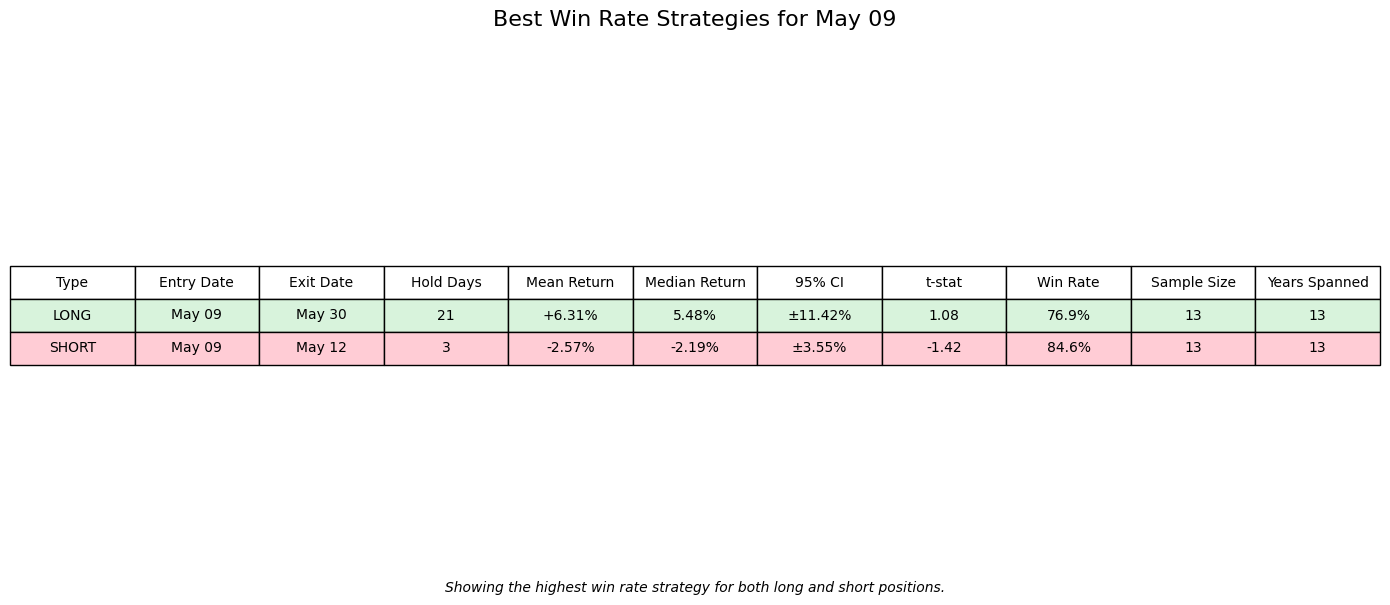


Best Win Rate Strategies for May 09:

LONG Position: Hold for 21 days until May 30
   Expected return: +6.31%, Win rate: 76.9%
   Based on 13 historical instances over 13 years

SHORT Position: Hold for 3 days until May 12
   Expected return: -2.57%, Win rate: 84.6% (for price going down)
   Based on 13 historical instances over 13 years



In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar

def find_todays_best_strategies(df, max_forward_days=30, min_occurrences=5, cycle_year_filter=None, show_highest_win_rate_only=True):
    """
    Identifies the best trading strategies starting from today's date.
    When show_highest_win_rate_only=True, it shows only the highest win rate strategy for both long and short.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Bitcoin price data with columns 'time', 'close'
    max_forward_days : int, default=30
        Maximum number of days to look forward for calculating returns
    min_occurrences : int, default=5
        Minimum number of occurrences required for a pattern to be considered statistically relevant
    cycle_year_filter : int or list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
    show_highest_win_rate_only : bool, default=True
        If True, only show the highest win rate strategy for both long and short
    """
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    # Get today's date
    today = datetime.now()
    current_month = today.month
    current_day = today.day
    
    # Add year and cycle year columns
    df['year'] = df['time'].dt.year
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Add month and day columns
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['month_name'] = df['time'].dt.strftime('%B')
    
    # Apply cycle year filter if specified
    if cycle_year_filter is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_year_filter, int):
            cycle_year_filter = [cycle_year_filter]
            
        # Validate cycle year filter
        for cy in cycle_year_filter:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
                
        # Filter the dataframe
        df = df[df['cycle_year'].isin(cycle_year_filter)].copy()
    
    # Find historical occurrences of today's date
    historical_entries = df[(df['month'] == current_month) & (df['day'] == current_day)]
    
    # Skip if no historical entries found
    if historical_entries.empty:
        print(f"No historical data found for today's date ({today.strftime('%B %d')}).")
        return None
    
    # Store results for different holding periods
    all_strategies = []
    
    # Test different holding periods
    for forward_days in range(1, max_forward_days + 1):
        # Calculate forward returns for this period
        result_data = []
        
        for _, entry_day in historical_entries.iterrows():
            entry_date = entry_day['time']
            entry_price = entry_day['close']
            entry_year = entry_day['year']
            
            # Calculate exit date
            exit_date = entry_date + pd.Timedelta(days=forward_days)
            
            # Find exit price (closest available data after exit date)
            future_data = df[df['time'] >= exit_date].sort_values('time')
            
            # Skip if no future data available
            if future_data.empty:
                continue
            
            # Get the first available price after the forward period
            exit_data = future_data.iloc[0]
            exit_price = exit_data['close']
            actual_exit_date = exit_data['time']
            
            # Calculate actual hold days and return
            actual_hold_days = (actual_exit_date - entry_date).days
            forward_return = ((exit_price - entry_price) / entry_price) * 100
            
            # Store the result
            result_data.append({
                'entry_date': entry_date,
                'exit_date': actual_exit_date,
                'year': entry_year,
                'cycle_year': 1 + ((entry_year - 2013) % 4),
                'forward_days': forward_days,
                'actual_hold_days': actual_hold_days,
                'forward_return': forward_return
            })
        
        # Skip if not enough data points
        if len(result_data) < min_occurrences:
            continue
            
        # Convert to dataframe
        strategy_df = pd.DataFrame(result_data)
        
        # Calculate statistics
        mean_return = strategy_df['forward_return'].mean()
        median_return = strategy_df['forward_return'].median()
        std_return = strategy_df['forward_return'].std()
        count = len(strategy_df)
        years_spanned = strategy_df['year'].nunique()
        
        # Calculate 95% confidence interval
        ci_95 = 1.96 * std_return / np.sqrt(count)
        
        # Calculate t-statistic (mean / standard error)
        t_stat = mean_return / (std_return / np.sqrt(count)) if std_return > 0 else 0
        t_stat_abs = abs(t_stat)
        
        # Calculate win rate (percentage of positive returns)
        win_rate = (strategy_df['forward_return'] > 0).mean() * 100
        
        # Calculate expected exit date for this year
        expected_exit_date = today + pd.Timedelta(days=forward_days)
        
        # Store the strategy
        all_strategies.append({
            'forward_days': forward_days,
            'mean_return': mean_return,
            'median_return': median_return,
            'std_return': std_return,
            'ci_95': ci_95,
            't_stat': t_stat,
            't_stat_abs': t_stat_abs,
            'count': count,
            'years_spanned': years_spanned,
            'win_rate': win_rate,
            'entry_date': today.strftime('%B %d'),
            'expected_exit_date': expected_exit_date.strftime('%B %d'),
            'strategy_type': 'positive' if mean_return > 0 else 'negative'
        })
    
    # Skip if no strategies found
    if not all_strategies:
        print(f"No viable strategies found for today's date ({today.strftime('%B %d')}) with the given parameters.")
        return None
    
    # Convert to dataframe
    strategies_df = pd.DataFrame(all_strategies)
    
    # Separate positive and negative strategies
    positive_strategies = strategies_df[strategies_df['strategy_type'] == 'positive'].copy()
    negative_strategies = strategies_df[strategies_df['strategy_type'] == 'negative'].copy()
    
    if show_highest_win_rate_only:
        # Get the highest win rate strategy for long (positive return)
        if not positive_strategies.empty:
            top_positive = positive_strategies.sort_values('win_rate', ascending=False).head(1)
        else:
            top_positive = pd.DataFrame()
            
        # Get the highest win rate strategy for short (negative return)
        if not negative_strategies.empty:
            # For shorting, higher win rate means more negative returns
            # Use .loc to properly set values on the dataframe
            negative_strategies.loc[:, 'short_win_rate'] = 100 - negative_strategies['win_rate']
            top_negative = negative_strategies.sort_values('short_win_rate', ascending=False).head(1)
        else:
            top_negative = pd.DataFrame()
    else:
        # Original behavior - sort by t-statistic
        top_positive = positive_strategies.sort_values('t_stat', ascending=False)
        top_negative = negative_strategies.sort_values('t_stat', ascending=True)
    
    # Visualize the results
    visualize_todays_strategies(top_positive, top_negative, today, cycle_year_filter, show_highest_win_rate_only)
    
    return top_positive, top_negative

def visualize_todays_strategies(top_positive, top_negative, today, cycle_year_filter=None, show_highest_win_rate_only=True):
    """
    Visualize the top strategies for today's date.
    
    Parameters:
    -----------
    top_positive : pandas DataFrame
        DataFrame containing top positive strategies
    top_negative : pandas DataFrame
        DataFrame containing top negative strategies
    today : datetime
        Current date
    cycle_year_filter : int or list, optional
        Filter used for cycle years
    show_highest_win_rate_only : bool, default=True
        If True, only show the highest win rate strategy for both long and short
    """
    # Skip if no strategies found
    if top_positive.empty and top_negative.empty:
        return
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    
    # Create table data
    table_data = []
    
    # Add positive strategies
    if not top_positive.empty:
        for _, strategy in top_positive.iterrows():
            table_data.append([
                'LONG',
                f"{strategy['entry_date']}",
                f"{strategy['expected_exit_date']}",
                f"{int(strategy['forward_days'])}",
                f"+{strategy['mean_return']:.2f}%",
                f"{strategy['median_return']:.2f}%",
                f"±{strategy['ci_95']:.2f}%",
                f"{strategy['t_stat']:.2f}",
                f"{strategy['win_rate']:.1f}%",
                f"{int(strategy['count'])}",
                f"{int(strategy['years_spanned'])}"
            ])
    
    # Add negative strategies
    if not top_negative.empty:
        for _, strategy in top_negative.iterrows():
            # For short, highlight the 'short win rate' which is 100 - win_rate
            short_win_rate = 100 - strategy['win_rate'] if 'short_win_rate' not in strategy else strategy['short_win_rate']
            
            table_data.append([
                'SHORT',
                f"{strategy['entry_date']}",
                f"{strategy['expected_exit_date']}",
                f"{int(strategy['forward_days'])}",
                f"{strategy['mean_return']:.2f}%",
                f"{strategy['median_return']:.2f}%",
                f"±{strategy['ci_95']:.2f}%",
                f"{strategy['t_stat']:.2f}",
                f"{short_win_rate:.1f}%",  # Show short win rate
                f"{int(strategy['count'])}",
                f"{int(strategy['years_spanned'])}"
            ])
    
    # Sort by win rate if showing highest win rate only, otherwise by t-statistic
    if show_highest_win_rate_only:
        # No need to sort, as we're only showing one of each type
        pass
    else:
        # Original behavior - sort by absolute t-statistic
        table_data.sort(key=lambda x: abs(float(x[7])), reverse=True)
    
    # Column headers
    cols = [
        "Type", "Entry Date", "Exit Date", "Hold Days", 
        "Mean Return", "Median Return", "95% CI", "t-stat", 
        "Win Rate", "Sample Size", "Years Spanned"
    ]
    
    # Create table
    table = ax.table(
        cellText=table_data,
        colLabels=cols,
        loc='center',
        cellLoc='center'
    )
    
    # Set table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.7)
    
    # Color rows based on strategy type
    for i, row_data in enumerate(table_data):
        strategy_type = row_data[0]
        for j in range(len(cols)):
            cell = table[i+1, j]
            if strategy_type == 'LONG':
                cell.set_facecolor('#d8f3dc')  # Light green
            else:
                cell.set_facecolor('#ffccd5')  # Light red
    
    # Create title
    title = f"Best Win Rate Strategies for {today.strftime('%B %d')}" if show_highest_win_rate_only else f"Top Trading Strategies for {today.strftime('%B %d')}"
    
    if cycle_year_filter is not None:
        if isinstance(cycle_year_filter, list):
            cycle_years_str = ", ".join([f"Year {cy}" for cy in cycle_year_filter])
        else:
            cycle_years_str = f"Year {cycle_year_filter}"
        title += f" (Bitcoin Cycle {cycle_years_str} Only)"
    
    plt.suptitle(title, fontsize=16)
    
    # Add subtitle
    if show_highest_win_rate_only:
        subtitle = "Showing the highest win rate strategy for both long and short positions."
    else:
        subtitle = "Strategies ranked by statistical significance (t-statistic). Higher absolute values indicate stronger statistical evidence."
    
    plt.figtext(0.5, 0.01, subtitle, ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print(f"\n{title}:\n")
    
    # Print descriptions of the strategies
    for i, row_data in enumerate(table_data):
        strategy_type = row_data[0]
        hold_days = row_data[3]
        exit_date = row_data[2]
        mean_return = row_data[4]
        win_rate = row_data[8]
        samples = row_data[9]
        years = row_data[10]
        
        if strategy_type == 'LONG':
            print(f"LONG Position: Hold for {hold_days} days until {exit_date}")
            print(f"   Expected return: {mean_return}, Win rate: {win_rate}")
            print(f"   Based on {samples} historical instances over {years} years\n")
        else:
            print(f"SHORT Position: Hold for {hold_days} days until {exit_date}")
            print(f"   Expected return: {mean_return}, Win rate: {win_rate} (for price going down)")
            print(f"   Based on {samples} historical instances over {years} years\n")

# Example usage:
# df = pd.read_csv("BITSTAMP_BTCUSD, 1D.csv")
# df['time'] = pd.to_datetime(df['time'], unit='s')

# Show only the highest win rate strategy for both long and short
top_positive, top_negative = find_todays_best_strategies(df, max_forward_days=30, min_occurrences=5)

# Find best strategies for today with cycle year 1 only
#top_positive, top_negative = find_todays_best_strategies(df, max_forward_days=30, min_occurrences=5, cycle_year_filter=1)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate
from colorama import Fore, Back, Style, init

# Initialize colorama
init(autoreset=True)

def analyze_period_performance_tables(df, include_current_cycle=True, cycle_years=None, sort_by='median'):
    """
    Analyzes the performance of Bitcoin across different time periods and displays results in colored tables.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Bitcoin price data with columns 'time', 'close'
    include_current_cycle : bool, default=True
        If True, include the current cycle in the analysis
    cycle_years : list, optional
        Filter to only include specific cycle years (1, 2, 3, or 4)
    sort_by : str, default='median'
        Metric to sort results by. Options: 'median', 'mean', 'success_rate'
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    # Sort data by time to ensure correct order
    df = df.sort_values('time')
    
    # Add year and cycle year columns
    df['year'] = df['time'].dt.year
    df['cycle_year'] = df['year'].apply(lambda y: 1 + ((y - 2013) % 4))
    
    # Get current period information
    current_date = datetime.now()
    current_year = current_date.year
    current_cycle_year = 1 + ((current_year - 2013) % 4)
    current_month = current_date.month
    
    # Print analysis parameters
    print(f"Bitcoin Period Performance Analysis")
    print(f"Current date: {current_date.strftime('%Y-%m-%d')}")
    print(f"Current cycle year: {current_cycle_year}")
    
    if cycle_years:
        cycle_str = ", ".join([f"Year {cy}" for cy in sorted(cycle_years)])
        print(f"Filtering to cycle years: {cycle_str}")
    else:
        print("Using all cycle years")
    
    print(f"Including current cycle: {include_current_cycle}")
    print(f"Sorting by: {sort_by}")
    print("\n" + "="*50 + "\n")
    
    # Apply cycle year filter if specified
    if cycle_years is not None:
        # Convert to list if it's a single integer
        if isinstance(cycle_years, int):
            cycle_years = [cycle_years]
            
        # Validate cycle year filter
        for cy in cycle_years:
            if cy not in [1, 2, 3, 4]:
                raise ValueError("Cycle year filter must be 1, 2, 3, or 4")
                
        # Filter the dataframe
        df = df[df['cycle_year'].isin(cycle_years)].copy()
    
    # If not including current cycle, filter it out
    if not include_current_cycle:
        if cycle_years is not None and current_cycle_year in cycle_years:
            df = df[~((df['cycle_year'] == current_cycle_year) & (df['year'] == current_year))].copy()
    
    # Add month
    df['month'] = df['time'].dt.month
    df['month_name'] = df['time'].dt.strftime('%B')
    
    # Calculate monthly returns (end of month / beginning of month - 1)
    df['month_year'] = df['time'].dt.strftime('%Y-%m')
    monthly_returns = df.groupby('month_year').agg({
        'close': ['first', 'last'],
        'month': 'first',
        'year': 'first',
        'cycle_year': 'first'
    })
    
    monthly_returns.columns = ['open', 'close', 'month', 'year', 'cycle_year']
    monthly_returns['return'] = (monthly_returns['close'] / monthly_returns['open']) - 1
    monthly_returns['month_name'] = monthly_returns['month'].apply(lambda m: calendar.month_name[m])
    
    # Define all 12 months for wrapping
    all_months = list(range(1, 13))
    
    # Define the periods to analyze with wrapping allowed
    periods = {
        '1-Month': [
            (f"{calendar.month_name[m]}", [m]) for m in all_months
        ],
        '2-Month': [
            (f"{calendar.month_name[m]}-{calendar.month_name[(m % 12) + 1]}", 
             [m, (m % 12) + 1]) 
            for m in all_months
        ],
        '3-Month': [],
        '6-Month': []
    }
    
    # Correctly generate 3-month periods (consecutive months)
    for m in all_months:
        # Calculate the next two months with proper wrapping
        month2 = (m % 12) + 1
        month3 = (month2 % 12) + 1
        
        # Create period name using the calendar month names
        period_name = f"{calendar.month_name[m]}-{calendar.month_name[month2]}-{calendar.month_name[month3]}"
        
        # Add to the periods dictionary
        periods['3-Month'].append((period_name, [m, month2, month3]))
    
    # Correctly generate 6-month periods (consecutive months)
    for m in all_months:
        # Calculate the next five months with proper wrapping
        months = [m]
        for i in range(1, 6):
            next_month = (months[i-1] % 12) + 1
            months.append(next_month)
        
        # Create period name using first and last month
        period_name = f"{calendar.month_name[months[0]]}-{calendar.month_name[months[5]]}"
        
        # Add to the periods dictionary
        periods['6-Month'].append((period_name, months))
    
    # Analyze each period length
    results_dict = {}
    
    for period_length, period_list in periods.items():
        period_results = []
        
        for period_name, months in period_list:
            # Handle year wrapping for periods that span December-January
            spans_year = 1 in months and 12 in months
            
            # Filter data for this specific period across all years
            period_data = []
            
            for start_year in df['year'].unique():
                # Skip the last year if we need a complete period
                if start_year == df['year'].max() and spans_year:
                    continue
                
                # Calculate end year based on whether period spans years
                end_year = start_year + 1 if spans_year else start_year
                
                # Create date ranges
                period_months = []
                for i, m in enumerate(months):
                    # If this month is less than the start month and spans_year is True,
                    # it means this month is in the next year
                    year = end_year if spans_year and m < months[0] else start_year
                    period_months.append((year, m))
                
                # Sort by year and month
                period_months.sort()
                
                # Extract start and end dates
                if period_months:
                    start_year, start_month = period_months[0]
                    end_year, end_month = period_months[-1]
                    
                    start_date = datetime(start_year, start_month, 1)
                    end_date = datetime(end_year, end_month, calendar.monthrange(end_year, end_month)[1])
                    
                    # Find prices at start and end
                    try:
                        start_df = df[(df['time'] >= start_date) & (df['time'] < start_date + timedelta(days=7))]
                        end_df = df[(df['time'] <= end_date) & (df['time'] > end_date - timedelta(days=7))]
                        
                        if not start_df.empty and not end_df.empty:
                            start_price = start_df['close'].iloc[0]
                            end_price = end_df['close'].iloc[-1]
                            
                            period_return = (end_price / start_price) - 1
                            
                            # Determine cycle year based on start date
                            cycle_year = 1 + ((start_year - 2013) % 4)
                            
                            period_data.append({
                                'start_year': start_year,
                                'end_year': end_year,
                                'cycle_year': cycle_year,
                                'return': period_return,
                                'start_price': start_price,
                                'end_price': end_price
                            })
                    except (IndexError, KeyError):
                        # Skip if we can't calculate return for this period
                        continue
            
            # Calculate statistics for this period
            if period_data:
                period_df = pd.DataFrame(period_data)
                
                # Calculate stats by cycle year if we have enough data
                cycle_stats = {}
                for cy in range(1, 5):
                    cy_data = period_df[period_df['cycle_year'] == cy]
                    if len(cy_data) > 0:
                        cycle_stats[cy] = {
                            'mean': cy_data['return'].mean(),
                            'median': cy_data['return'].median(),
                            'min': cy_data['return'].min(),
                            'max': cy_data['return'].max(),
                            'count': len(cy_data),
                            'positive': (cy_data['return'] > 0).sum(),
                            'positive_rate': (cy_data['return'] > 0).sum() / len(cy_data)
                        }
                
                # Overall stats
                overall_mean = period_df['return'].mean()
                overall_median = period_df['return'].median()
                positive_years = (period_df['return'] > 0).sum()
                total_years = len(period_df)
                success_rate = positive_years / total_years if total_years > 0 else 0
                
                # Calculate statistics for cycle years
                c1_mean = cycle_stats.get(1, {}).get('mean', None)
                c2_mean = cycle_stats.get(2, {}).get('mean', None)
                c3_mean = cycle_stats.get(3, {}).get('mean', None)
                c4_mean = cycle_stats.get(4, {}).get('mean', None)
                
                # Determine if this is the current period:
                # For all period types: if the current month is the first month (starting month)
                is_current = False
                if months[0] == current_month:
                    is_current = True
                
                # Store results
                period_results.append({
                    'period': period_name,
                    'months': months,
                    'overall_mean': overall_mean,
                    'overall_median': overall_median,
                    'success_rate': success_rate,
                    'total_years': total_years,
                    'positive_years': positive_years,
                    'cycle_stats': cycle_stats,
                    'is_current': is_current,
                    'c1_mean': c1_mean,
                    'c2_mean': c2_mean,
                    'c3_mean': c3_mean,
                    'c4_mean': c4_mean
                })
        
        # Sort periods by the specified metric
        if sort_by == 'mean':
            period_results = sorted(period_results, key=lambda x: x['overall_mean'], reverse=True)
        elif sort_by == 'success_rate':
            period_results = sorted(period_results, key=lambda x: x['success_rate'], reverse=True)
        else:  # Default to median
            period_results = sorted(period_results, key=lambda x: x['overall_median'], reverse=True)
        
        # Add ranks
        for i, period in enumerate(period_results):
            period['rank'] = i + 1
        
        results_dict[period_length] = period_results
    
    # Display results as colored tables
    display_colored_tables(results_dict)
    
    # Return None to avoid printing raw data
    return None

def display_colored_tables(results_dict):
    """
    Displays performance results in tabular format with color-coding for values.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with performance results for different period lengths
    """
    # Function to get color for returns
    def get_return_color(value):
        if value >= 20:
            return '\033[92m'  # Bright green
        elif value >= 10:
            return '\033[32m'  # Green
        elif value > 0:
            return '\033[36m'  # Cyan
        elif value > -10:
            return '\033[33m'  # Yellow
        elif value > -20:
            return '\033[31m'  # Red
        else:
            return '\033[91m'  # Bright red
    
    # Function to get color for success rate
    def get_success_color(value):
        if value >= 80:
            return '\033[92m'  # Bright green
        elif value >= 65:
            return '\033[32m'  # Green
        elif value >= 50:
            return '\033[36m'  # Cyan
        elif value >= 35:
            return '\033[33m'  # Yellow
        elif value >= 20:
            return '\033[31m'  # Red
        else:
            return '\033[91m'  # Bright red
    
    # Reset color code
    reset = '\033[0m'
    
    for period_length, period_results in results_dict.items():
        if not period_results:
            print(f"No data available for {period_length} periods.")
            continue
        
        print(f"\n{period_length} Period Performance Rankings:")
        
        # Create table headers
        headers = [f"{period_length} Period", "Average % Change", "Median % Change", "% Higher", "Current"]
        
        # Add cycle headers if available
        if any(p['c1_mean'] is not None for p in period_results):
            headers.extend(["C1 Avg", "C2 Avg", "C3 Avg", "C4 Avg"])
        
        # Create colored table data
        table_data = []
        
        for p in period_results:
            # Format data
            mean_val = p['overall_mean'] * 100
            median_val = p['overall_median'] * 100
            success_val = p['success_rate'] * 100
            
            # Apply colors
            mean_color = get_return_color(mean_val)
            median_color = get_return_color(median_val)
            success_color = get_success_color(success_val)
            
            # Format strings with colors
            avg_change = f"{mean_color}{mean_val:.1f}%{reset}"
            median_change = f"{median_color}{median_val:.1f}%{reset}"
            percent_higher = f"{success_color}{success_val:.1f}%{reset}"
            
            # Current period indicator
            current_indicator = "✓" if p['is_current'] else ""
            
            # Basic row
            row = [
                p['period'],
                avg_change,
                median_change,
                percent_higher,
                current_indicator
            ]
            
            # Add cycle data if available
            if 'c1_mean' in p and p['c1_mean'] is not None:
                for cy_mean in [p['c1_mean'], p['c2_mean'], p['c3_mean'], p['c4_mean']]:
                    if cy_mean is not None:
                        cy_val = cy_mean * 100
                        cy_color = get_return_color(cy_val)
                        row.append(f"{cy_color}{cy_val:.1f}%{reset}")
                    else:
                        row.append("N/A")
            
            table_data.append(row)
        
        # Print table
        print(tabulate(table_data, headers=headers, tablefmt="pipe"))
        print("\n" + "-" * 50)
        print("Color Key:")
        print(f"{get_return_color(25)}≥ 20%{reset} {get_return_color(15)}≥ 10%{reset} {get_return_color(5)}> 0%{reset} {get_return_color(-5)}> -10%{reset} {get_return_color(-15)}> -20%{reset} {get_return_color(-25)}≤ -20%{reset}")
        print("\n")

# Example usage:
# df = pd.read_csv("bitcoin_price_data.csv")
# df['time'] = pd.to_datetime(df['time'])
# 
# # Basic usage
analyze_period_performance_tables(df)
# 
# # Filtering to specific cycle years (e.g., only years 1 and 4)
# analyze_period_performance_tables(df, cycle_years=[1, 4])
# 
# # Sorting by success rate instead of median
# analyze_period_performance_tables(df, sort_by='success_rate')

Bitcoin Period Performance Analysis
Current date: 2025-05-08
Current cycle year: 1
Using all cycle years
Including current cycle: True
Sorting by: median



1-Month Period Performance Rankings:
| 1-Month Period   | Average % Change   | Median % Change   | % Higher   | Current   | C1 Avg   | C2 Avg   | C3 Avg   | C4 Avg   |
|:-----------------|:-------------------|:------------------|:-----------|:----------|:---------|:---------|:---------|:---------|
| July             | 11.9%              | 16.3%             | 69.2%      |           | 19.4%    | 11.4%    | 0.4%     | 15.2%    |
| October          | 14.7%              | 14.6%             | 71.4%      |           | 44.7%    | -3.4%    | 8.1%     | 12.5%    |
| February         | 10.9%              | 11.6%             | 64.3%      |           | 26.1%    | -2.1%    | 6.5%     | 8.7%     |
| November         | 39.7%              | 10.5%             | 64.3%      |           | 165.0%   | -12.5%   | -0.1%    | 24.7%    |
| May              |

Using synthetic data for demonstration


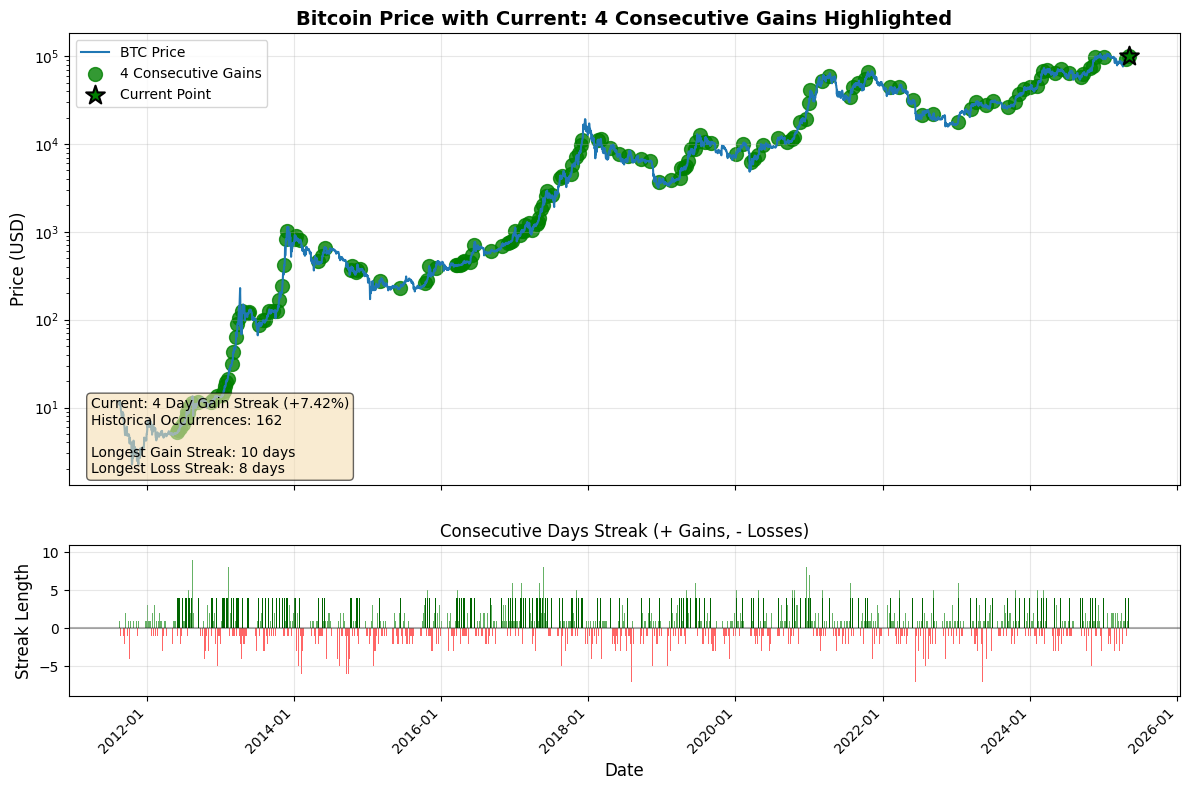

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

def plot_btc_matching_streaks(df):
    """
    Plot Bitcoin price chart highlighting all instances of streaks that match the current streak length.
    
    Parameters:
    df: DataFrame containing 'time' and 'close' columns
    
    Returns:
    fig: matplotlib Figure object
    """
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(data['time']):
        data['time'] = pd.to_datetime(data['time'])
    
    # Sort by time
    data = data.sort_values('time')
    
    # Calculate daily returns
    data['daily_return'] = data['close'].pct_change()
    
    # Identify positive and negative return days
    data['is_gain'] = data['daily_return'] > 0
    data['is_loss'] = data['daily_return'] < 0
    
    # Initialize consecutive gains and losses counters
    data['consec_gains'] = 0
    data['consec_losses'] = 0
    
    # Calculate consecutive gains
    current_gain_streak = 0
    for i in range(len(data)):
        if data['is_gain'].iloc[i]:
            current_gain_streak += 1
            data.iloc[i, data.columns.get_loc('consec_gains')] = current_gain_streak
        else:
            current_gain_streak = 0
    
    # Calculate consecutive losses
    current_loss_streak = 0
    for i in range(len(data)):
        if data['is_loss'].iloc[i]:
            current_loss_streak += 1
            data.iloc[i, data.columns.get_loc('consec_losses')] = current_loss_streak
        else:
            current_loss_streak = 0
    
    # Get the current streak (from the most recent data point)
    last_idx = len(data) - 1
    current_gain_streak = data['consec_gains'].iloc[last_idx]
    current_loss_streak = data['consec_losses'].iloc[last_idx]
    
    # Create a combined streak indicator (positive for gains, negative for losses)
    data['streak'] = data['consec_gains'] - data['consec_losses']
    
    # Create figure with two subplots (price chart and indicator)
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1])
    
    # Price chart
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(data['time'], data['close'], color='#1f77b4', label='BTC Price')
    
    # Determine what kind of streak we have currently
    if current_gain_streak > 0:
        current_streak_type = "gain"
        current_streak_length = current_gain_streak
        current_streak_color = "green"
    elif current_loss_streak > 0:
        current_streak_type = "loss"
        current_streak_length = current_loss_streak
        current_streak_color = "red"
    else:
        current_streak_type = "none"
        current_streak_length = 0
        current_streak_color = "gray"
    
    # Create label describing the current streak
    if current_streak_type == "gain":
        streak_label = f"Current: {current_streak_length} Consecutive Gains"
    elif current_streak_type == "loss":
        streak_label = f"Current: {current_streak_length} Consecutive Losses"
    else:
        streak_label = "No Current Streak"
    
    # Highlight all matching streaks in the price chart
    if current_streak_type == "gain" and current_streak_length > 0:
        # Find all points where the streak matches the current streak length
        matching_points = data[data['consec_gains'] == current_streak_length]
        
        if not matching_points.empty:
            ax1.scatter(
                matching_points['time'],
                matching_points['close'],
                color=current_streak_color,
                s=100,  # Fixed size for visibility
                alpha=0.8,
                label=f"{current_streak_length} Consecutive Gains"
            )
    
    elif current_streak_type == "loss" and current_streak_length > 0:
        # Find all points where the streak matches the current streak length
        matching_points = data[data['consec_losses'] == current_streak_length]
        
        if not matching_points.empty:
            ax1.scatter(
                matching_points['time'],
                matching_points['close'],
                color=current_streak_color,
                s=100,  # Fixed size for visibility
                alpha=0.8,
                label=f"{current_streak_length} Consecutive Losses"
            )
    
    # Highlight the current streak with a different marker
    current_date = data['time'].iloc[last_idx]
    current_price = data['close'].iloc[last_idx]
    
    if current_streak_length > 0:
        ax1.scatter(
            [current_date], 
            [current_price],
            color=current_streak_color,
            s=200,  # Larger size for the current point
            marker='*',
            edgecolor='black',
            linewidth=1.5,
            zorder=10,
            label="Current Point"
        )
    
    # Format the price chart
    ax1.set_title(f'Bitcoin Price with {streak_label} Highlighted', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Apply log scale if the price range is wide
    price_range_ratio = data['close'].max() / data['close'].min()
    if price_range_ratio > 10:
        ax1.set_yscale('log')
    
    # Consecutive streak indicator chart
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Plot bars with color based on streak direction
    colors = ['red' if x < 0 else 'green' for x in data['streak']]
    ax2.bar(data['time'], data['streak'], color=colors, alpha=0.6)
    
    # Highlight all streaks of matching length in the indicator chart
    if current_streak_type == "gain" and current_streak_length > 0:
        matching_dates = data[data['consec_gains'] == current_streak_length]['time']
        matching_values = data[data['consec_gains'] == current_streak_length]['consec_gains']
        
        if not matching_dates.empty:
            ax2.bar(
                matching_dates,
                matching_values,
                color='darkgreen',
                alpha=1.0,
                width=5
            )
    
    elif current_streak_type == "loss" and current_streak_length > 0:
        matching_dates = data[data['consec_losses'] == current_streak_length]['time']
        matching_values = -data[data['consec_losses'] == current_streak_length]['consec_losses']
        
        if not matching_dates.empty:
            ax2.bar(
                matching_dates,
                matching_values,
                color='darkred',
                alpha=1.0,
                width=5
            )
    
    # Format the indicator chart
    ax2.set_title('Consecutive Days Streak (+ Gains, - Losses)', fontsize=12)
    ax2.set_ylabel('Streak Length', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Set x-axis date formatter
    date_format = mdates.DateFormatter('%Y-%m')
    ax2.xaxis.set_major_formatter(date_format)
    
    # Rotate date labels
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Hide x ticks on the price chart
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # Add a statistics box
    max_gain_streak = data['consec_gains'].max()
    max_loss_streak = data['consec_losses'].max()
    
    # Count occurrences of the current streak length
    if current_streak_type == "gain" and current_streak_length > 0:
        matching_streaks_count = (data['consec_gains'] == current_streak_length).sum()
    elif current_streak_type == "loss" and current_streak_length > 0:
        matching_streaks_count = (data['consec_losses'] == current_streak_length).sum()
    else:
        matching_streaks_count = 0
    
    # Calculate percentage change during current streak
    if current_streak_length > 0:
        start_idx = last_idx - (current_streak_length - 1)
        start_price = data['close'].iloc[start_idx - 1] if start_idx > 0 else data['close'].iloc[start_idx]
        current_streak_change = (current_price / start_price - 1) * 100
        
        if current_streak_type == "gain":
            change_text = f"+{current_streak_change:.2f}%"
        else:
            change_text = f"{current_streak_change:.2f}%"
    else:
        change_text = "0.00%"
    
    # Information about current streak and historical occurrences
    if current_streak_length > 0:
        title_text = f"Current: {current_streak_length} Day {current_streak_type.capitalize()} Streak ({change_text})"
        occurrences_text = f"Historical Occurrences: {matching_streaks_count}"
    else:
        title_text = "No Current Streak"
        occurrences_text = ""
    
    stats_text = (
        f"{title_text}\n"
        f"{occurrences_text}\n\n"
        f"Longest Gain Streak: {max_gain_streak} days\n"
        f"Longest Loss Streak: {max_loss_streak} days"
    )
    
    # Add text box with stats
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    
    return fig

# Example usage with synthetic data
def create_sample_data():
    """Create synthetic Bitcoin price data with realistic streaks"""
    np.random.seed(42)
    n_days = 250
    dates = pd.date_range(start='2020-01-01', periods=n_days, freq='D')
    
    # Generate price data
    price = 10000  # Starting price
    close_prices = [price]
    
    # Add patterns with specific streaks
    for i in range(1, n_days):
        # Create some 3-day gain streaks throughout the data
        if i % 30 == 5 or i % 30 == 6 or i % 30 == 7:
            change = np.random.uniform(0.01, 0.04)  # 3-day gain streak
        # Create some 3-day loss streaks
        elif i % 30 == 15 or i % 30 == 16 or i % 30 == 17:
            change = np.random.uniform(-0.04, -0.01)  # 3-day loss streak
        # Create a 5-day gain streak
        elif i >= 100 and i <= 104:
            change = np.random.uniform(0.01, 0.05)  # 5-day gain streak
        # Create a 5-day loss streak
        elif i >= 150 and i <= 154:
            change = np.random.uniform(-0.05, -0.01)  # 5-day loss streak
        # Random days
        else:
            change = np.random.normal(0.001, 0.02)
            
        price *= (1 + change)
        close_prices.append(price)
    
    # Create a simple dataframe
    df = pd.DataFrame({
        'time': dates,
        'close': close_prices
    })
    
    # End with a specific streak for demonstration (5-day gain streak)
    # This ensures we have a visible current streak to highlight
    last_idx = len(df) - 1
    df.loc[df.index[last_idx-4:last_idx+1], 'close'] = [
        df.loc[df.index[last_idx-4], 'close'],
        df.loc[df.index[last_idx-4], 'close'] * 1.02,
        df.loc[df.index[last_idx-4], 'close'] * 1.04,
        df.loc[df.index[last_idx-4], 'close'] * 1.07,
        df.loc[df.index[last_idx-4], 'close'] * 1.09
    ]
    
    return df

if __name__ == "__main__":
    # Either load real data or use synthetic data
    try:
        # Load Bitcoin data from a CSV file
        df = pd.read_csv("BITSTAMP_BTCUSD_1D.csv")
        
        # If time is in Unix timestamp format, convert it
        if 'time' in df.columns and np.issubdtype(df['time'].dtype, np.integer):
            df['time'] = pd.to_datetime(df['time'], unit='s')
    except:
        # If no data file is available, use synthetic data
        print("Using synthetic data for demonstration")
        #df = create_sample_data()
    
    # Plot the data
    fig = plot_btc_matching_streaks(df)
    plt.show()

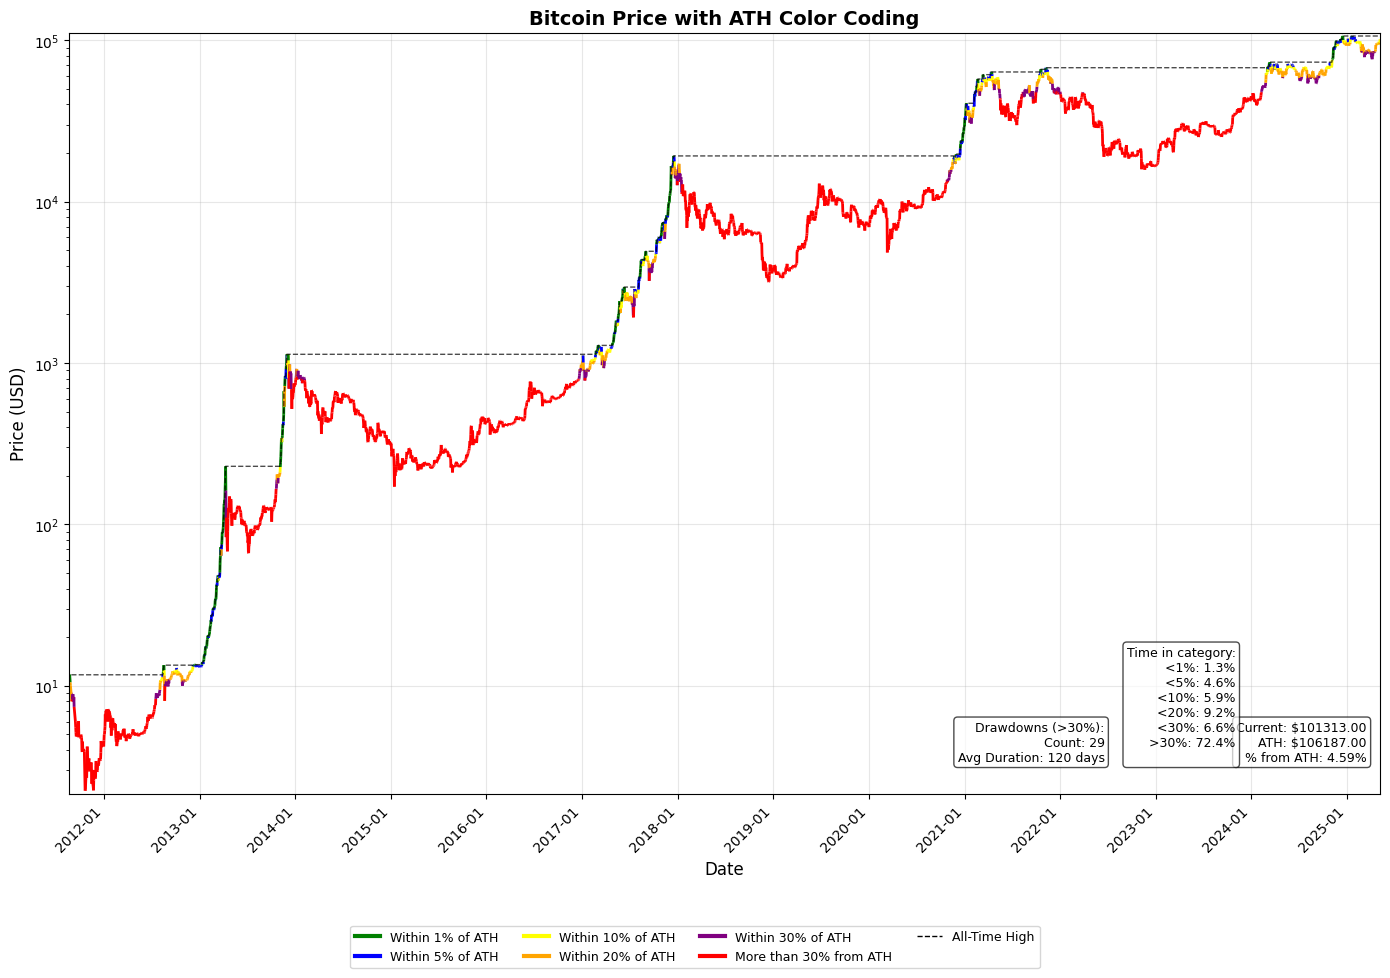

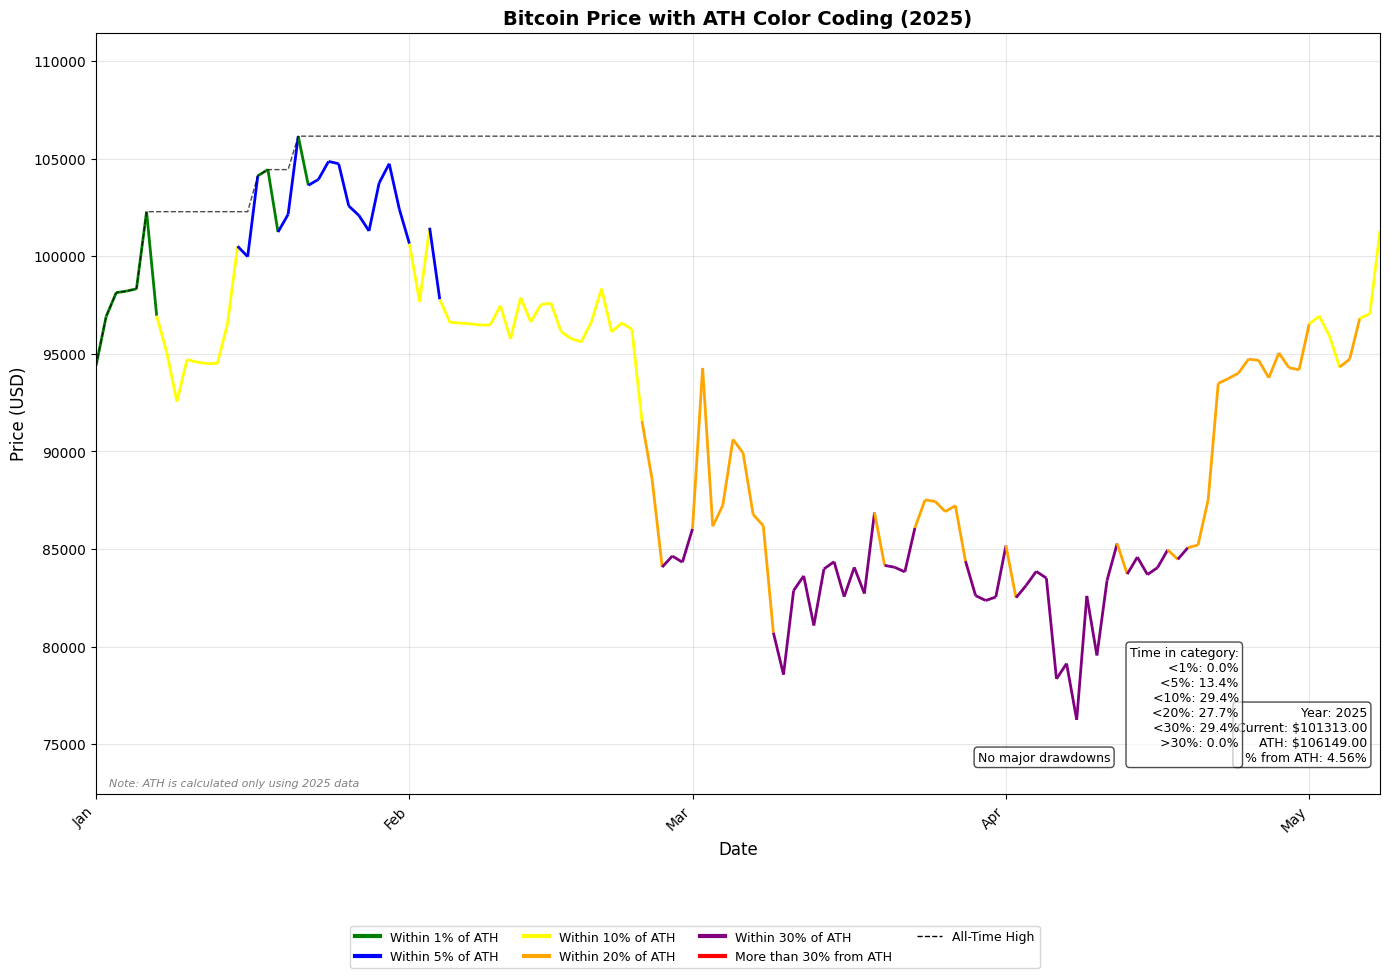

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_btc_ath_color_coded(df, year=None):
    """
    Plot Bitcoin price chart with color coding based on proximity to All-Time High (ATH).
    All text boxes are placed in a row at the bottom right.
    
    Color coding:
    - Green: Within 1% of ATH
    - Blue: Within 5% of ATH
    - Yellow: Within 10% of ATH
    - Orange: Within 20% of ATH
    - Purple: Within 30% of ATH
    - Red: More than 30% from ATH
    
    Parameters:
    df: DataFrame with 'time' and 'close' columns for Bitcoin price data
    year: Specific year to display (int, optional). If None, all data is shown.
    
    Returns:
    fig: matplotlib Figure object
    """
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(data['time']):
        data['time'] = pd.to_datetime(data['time'])
    
    # Sort by time
    data = data.sort_values('time')
    
    # Add year column for filtering
    data['year'] = data['time'].dt.year
    
    # Filter by year if specified
    if year is not None:
        data_filtered = data[data['year'] == year].copy()
        # Check if we have data for the specified year
        if len(data_filtered) == 0:
            raise ValueError(f"No data available for year {year}")
        
        # For year-specific view, calculate ATH based only on that year's data
        data_filtered['ath'] = data_filtered['close'].expanding().max()
        
        # Use the filtered data for the visualization
        data_for_display = data_filtered
        
        # Title suffix for the specified year
        title_suffix = f" ({year})"
    else:
        # Calculate expanding maximum (ATH) using all data
        data['ath'] = data['close'].expanding().max()
        
        # Use all data for visualization
        data_for_display = data
        
        # No year suffix for the title
        title_suffix = ""
    
    # Calculate percentage from ATH
    data_for_display['pct_from_ath'] = (data_for_display['ath'] - data_for_display['close']) / data_for_display['ath'] * 100
    
    # Create a new column for color-coding based on percentage from ATH
    data_for_display['color_code'] = pd.cut(
        data_for_display['pct_from_ath'],
        bins=[0, 1, 5, 10, 20, 30, float('inf')],
        labels=['green', 'blue', 'yellow', 'orange', 'purple', 'red']
    )
    
    # Create figure and axis with more space at the bottom
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Convert dates to numeric for line collection
    dates = mdates.date2num(data_for_display['time'])
    
    # Create segments for the line
    points = np.array([dates, data_for_display['close']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Define color map based on our categories
    cmap = ListedColormap(['green', 'blue', 'yellow', 'orange', 'purple', 'red'])
    
    # Convert color codes to numeric values for norm
    color_values = pd.Categorical(data_for_display['color_code']).codes
    
    # Create a line collection
    norm = BoundaryNorm(np.arange(-0.5, 6), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(color_values[:-1])  # Set colors for each segment
    lc.set_linewidth(2)
    
    # Add line collection to the plot
    line = ax.add_collection(lc)
    
    # Set plot limits
    ax.set_xlim(dates.min(), dates.max())
    ax.set_ylim(data_for_display['close'].min() * 0.95, data_for_display['close'].max() * 1.05)
    
    # Add the ATH line
    ax.plot(data_for_display['time'], data_for_display['ath'], 'k--', alpha=0.7, linewidth=1, label='All-Time High')
    
    # Format the plot
    ax.set_title(f'Bitcoin Price with ATH Color Coding{title_suffix}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (USD)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Apply log scale if the price range is wide
    price_range_ratio = data_for_display['close'].max() / data_for_display['close'].min()
    if price_range_ratio > 10:
        ax.set_yscale('log')
    
    # Format the date axis - adjust based on whether we're showing a full year or all data
    if year is not None:
        # For a single year, show months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    else:
        # For all data, show year-month
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        # Set locator based on data span
        data_span_years = (data['time'].max() - data['time'].min()).days / 365.25
        if data_span_years > 5:
            ax.xaxis.set_major_locator(mdates.YearLocator())
        else:
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color='green', linewidth=3, label='Within 1% of ATH'),
        Line2D([0], [0], color='blue', linewidth=3, label='Within 5% of ATH'),
        Line2D([0], [0], color='yellow', linewidth=3, label='Within 10% of ATH'),
        Line2D([0], [0], color='orange', linewidth=3, label='Within 20% of ATH'),
        Line2D([0], [0], color='purple', linewidth=3, label='Within 30% of ATH'),
        Line2D([0], [0], color='red', linewidth=3, label='More than 30% from ATH'),
        Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='All-Time High')
    ]
    
    # Add legend directly to the figure instead of the axis
    # This places it outside the main plot area
    legend = fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
                       bbox_to_anchor=(0.5, 0.02), fontsize=9)
    
    # Add statistics
    current_close = data_for_display['close'].iloc[-1]
    current_ath = data_for_display['ath'].iloc[-1]
    current_pct = data_for_display['pct_from_ath'].iloc[-1]
    
    # Count the percentage of time spent in each category
    category_counts = data_for_display['color_code'].value_counts(normalize=True) * 100
    
    # Prepare combined stats for a single row text
    stats_text = (
        f"Current: ${current_close:.2f}\n"
        f"ATH: ${current_ath:.2f}\n"
        f"% from ATH: {current_pct:.2f}%"
    )
    
    # Add year information if specified
    if year is not None:
        stats_text = f"Year: {year}\n" + stats_text
    
    # Add stats text box in bottom right
    box1_props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    box1 = ax.text(0.99, 0.04, stats_text, transform=ax.transAxes, fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right', bbox=box1_props)
    
    # Prepare category percentages for the middle box
    category_text = "Time in category:\n"
    for category, color in zip(
        ['<1%', '<5%', '<10%', '<20%', '<30%', '>30%'],
        ['green', 'blue', 'yellow', 'orange', 'purple', 'red']
    ):
        if color in category_counts:
            category_text += f"{category}: {category_counts[color]:.1f}%\n"
        else:
            category_text += f"{category}: 0.0%\n"
    
    # Add the category percentages text box to the left of the first box
    box2_props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    box2 = ax.text(0.89, 0.04, category_text, transform=ax.transAxes, fontsize=9,
                  verticalalignment='bottom', horizontalalignment='right', bbox=box2_props)
    
    # Add drawdown statistics
    drawdown_periods = {}
    in_drawdown = False
    drawdown_start = None
    threshold = 30  # 30% for significant drawdown
    
    for i, row in data_for_display.iterrows():
        if row['pct_from_ath'] >= threshold and not in_drawdown:
            # Start of significant drawdown
            in_drawdown = True
            drawdown_start = row['time']
        elif row['pct_from_ath'] < threshold and in_drawdown:
            # End of significant drawdown
            in_drawdown = False
            drawdown_periods[drawdown_start] = row['time']
    
    # If still in drawdown at the end of data
    if in_drawdown:
        drawdown_periods[drawdown_start] = data_for_display['time'].iloc[-1]
    
    # Count significant drawdowns
    num_drawdowns = len(drawdown_periods)
    
    # Calculate average duration of significant drawdowns
    if num_drawdowns > 0:
        avg_duration = sum((end - start).days for start, end in drawdown_periods.items()) / num_drawdowns
        drawdown_text = (
            f"Drawdowns (>30%):\n"
            f"Count: {num_drawdowns}\n"
            f"Avg Duration: {avg_duration:.0f} days"
        )
    else:
        drawdown_text = "No major drawdowns"
    
    # Add the drawdown text box to the left of the second box
    box3_props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    box3 = ax.text(0.79, 0.04, drawdown_text, transform=ax.transAxes, fontsize=9,
                  verticalalignment='bottom', horizontalalignment='right', bbox=box3_props)
    
    # Add a note about ATH calculation method when a specific year is selected
    if year is not None:
        note_text = f"Note: ATH is calculated only using {year} data"
        ax.text(0.01, 0.01, note_text, transform=ax.transAxes, fontsize=8, 
                style='italic', color='gray')
    
    # Adjust layout with extra space at the bottom for the legend and text boxes
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    return fig

# Example of how to use the function with your existing df:

# Assuming you already have a dataframe called df with 'time' and 'close' columns

# To view all data:
fig = plot_btc_ath_color_coded(df)
plt.show()

# To view a specific year (e.g., 2021):
fig = plot_btc_ath_color_coded(df, year=2025)
plt.show()


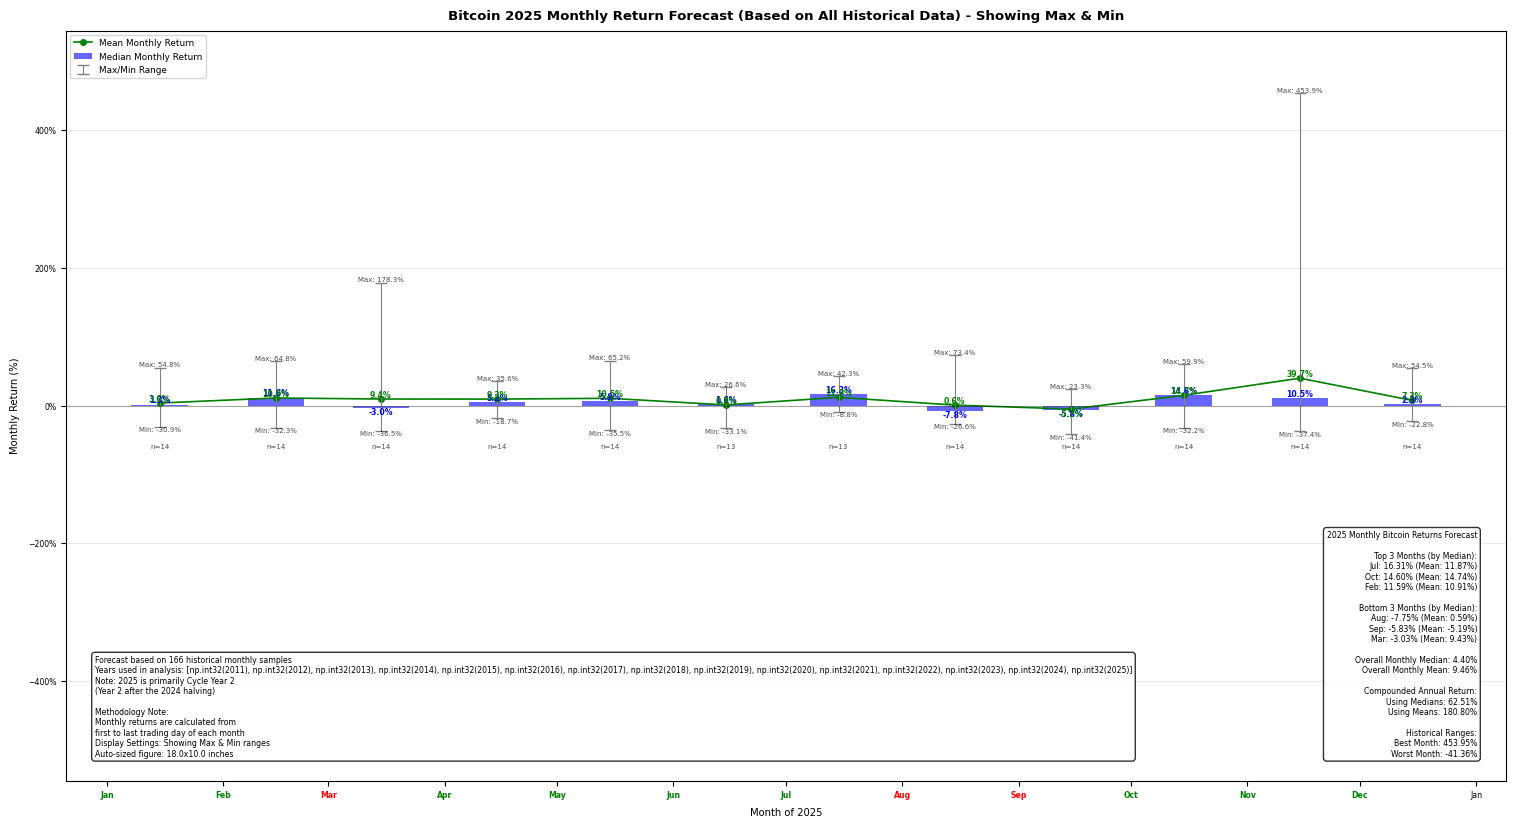

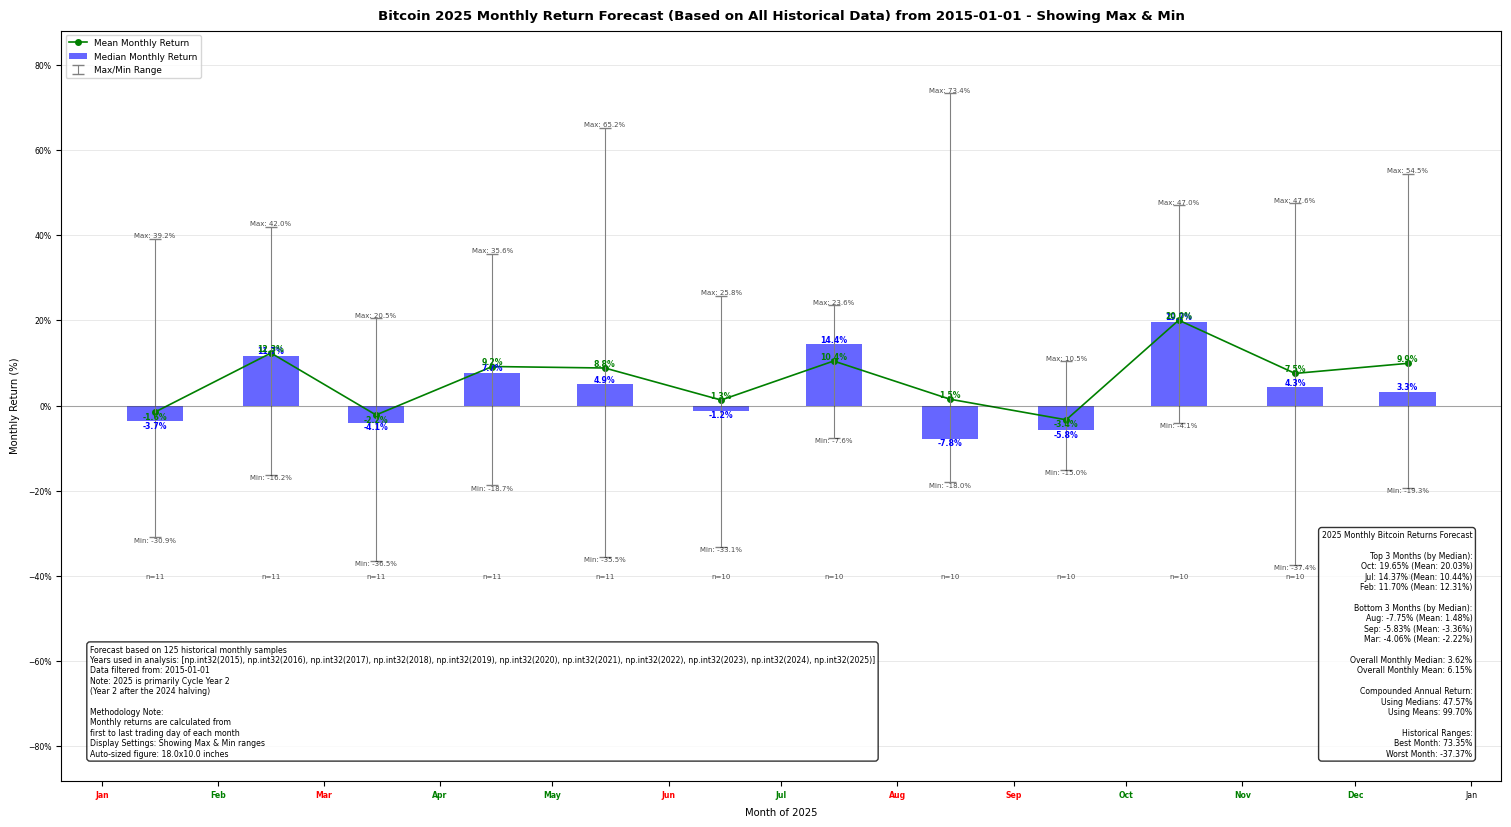

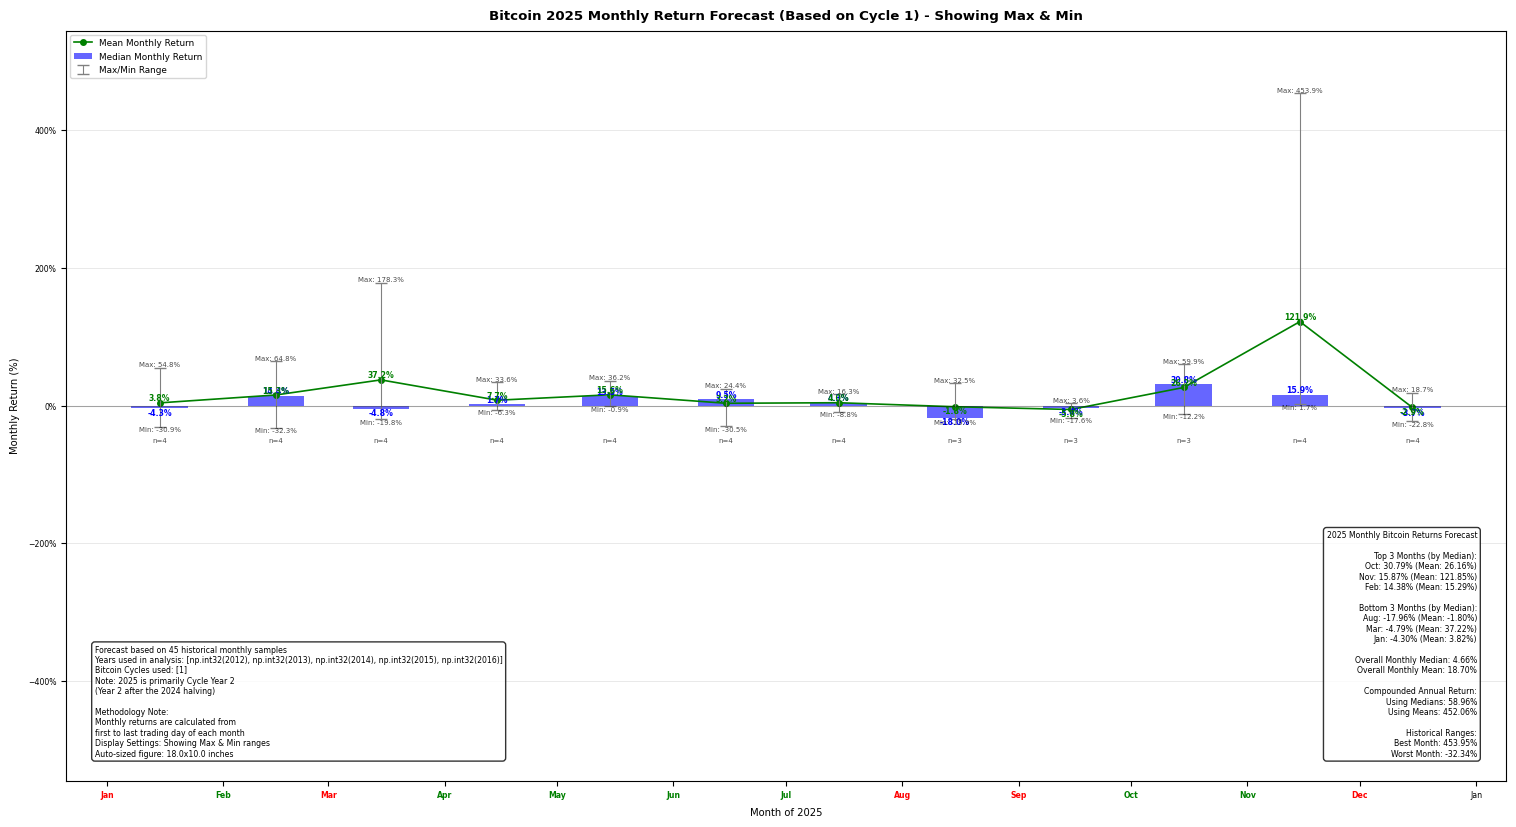

In [108]:
def plot_btc_monthly_forecast(df, target_year=2025, cycle_year=None, cycles=None, similar_years=None, 
                             figsize=None, show_max=True, show_min=True, auto_size=True, start_date=None):
    """
    Plot Bitcoin monthly return forecast showing median, average, max and min returns.
    Uses actual monthly returns (not daily).
    
    Parameters:
    df: DataFrame with 'time' and 'close' columns for Bitcoin price data
    target_year: Year to forecast (default: 2025)
    cycle_year: Filter data to specific cycle year (1-4) or None for all cycle years
    cycles: Filter data to specific cycles (list of integers, e.g. [1, 2]) or None for all cycles
    similar_years: List of specific years to base analysis on (e.g., [2017, 2021]) or None
    figsize: Size of the figure (width, height) in inches. If None, calculated automatically based on data
    show_max: Whether to display maximum values (default: True)
    show_min: Whether to display minimum values (default: True)
    auto_size: Whether to automatically adjust figure size based on data complexity (default: True)
    start_date: Filter data to only include dates on or after this date (str 'YYYY-MM-DD' or datetime)
    
    Returns:
    fig: matplotlib Figure object
    """
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Ensure time is datetime
    if not pd.api.types.is_datetime64_any_dtype(data['time']):
        data['time'] = pd.to_datetime(data['time'])
    
    # Filter by start_date if specified
    if start_date is not None:
        # Convert start_date to datetime if it's a string
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        
        # Filter dataframe
        data = data[data['time'] >= start_date]
        
        if len(data) == 0:
            raise ValueError(f"No data found after start date {start_date}")
    
    # Sort by time
    data = data.sort_values('time')
    
    # Add year and month columns
    data['year'] = data['time'].dt.year
    data['month'] = data['time'].dt.month
    data['year_month'] = data['time'].dt.strftime('%Y-%m')
    
    # Calculate Bitcoin halving cycles (approximate)
    # 1st halving: 2012-11-28, 2nd: 2016-07-09, 3rd: 2020-05-11, 4th: 2024-04-19 (estimate)
    halving_dates = [
        pd.Timestamp('2012-11-28'),
        pd.Timestamp('2016-07-09'),
        pd.Timestamp('2020-05-11'),
        pd.Timestamp('2024-04-19')  # 4th halving
    ]
    
    # Assign cycle years (1-4) based on halvings
    data['cycle_year'] = 0
    data['cycle'] = 0  # Add the cycle number
    
    for i, date in enumerate(halving_dates[:-1]):
        next_date = halving_dates[i + 1]
        cycle_num = i + 1  # 1st, 2nd, 3rd cycle
        
        # For all dates in this range, calculate how many years since halving
        mask = (data['time'] >= date) & (data['time'] < next_date)
        data.loc[mask, 'days_since_halving'] = (data.loc[mask, 'time'] - date).dt.days
        data.loc[mask, 'years_since_halving'] = data.loc[mask, 'days_since_halving'] / 365.25
        data.loc[mask, 'cycle_year'] = data.loc[mask, 'years_since_halving'].apply(lambda x: min(4, int(x) + 1))
        data.loc[mask, 'cycle'] = cycle_num
    
    # For dates after the last known halving
    mask = data['time'] >= halving_dates[-1]
    if mask.any():
        data.loc[mask, 'days_since_halving'] = (data.loc[mask, 'time'] - halving_dates[-1]).dt.days
        data.loc[mask, 'years_since_halving'] = data.loc[mask, 'days_since_halving'] / 365.25
        data.loc[mask, 'cycle_year'] = data.loc[mask, 'years_since_halving'].apply(lambda x: min(4, int(x) + 1))
        data.loc[mask, 'cycle'] = len(halving_dates)  # Current cycle
    
    # Determine cycle year for target year
    if cycle_year is not None:
        # User explicitly specified a cycle year filter
        target_cycle_year = cycle_year
    else:
        # No explicit cycle_year parameter - don't default to cycle year 2
        target_cycle_year = None
    
    # Filter data based on specified parameters
    filtered_data = data.copy()
    
    if similar_years is not None:
        if not isinstance(similar_years, list):
            similar_years = [similar_years]
        filtered_data = filtered_data[filtered_data['year'].isin(similar_years)]
    elif cycles is not None:
        # Filter by specific cycles
        if not isinstance(cycles, list):
            cycles = [cycles]
        filtered_data = filtered_data[filtered_data['cycle'].isin(cycles)]
    elif target_cycle_year is not None:
        # Use data from the same cycle year
        filtered_data = filtered_data[filtered_data['cycle_year'] == target_cycle_year]
    # If none of the filters are specified, we use all data
    
    # Ensure we have enough data
    if len(filtered_data) < 30:
        print(f"Warning: Limited data available for analysis ({len(filtered_data)} data points)")
        
    if len(filtered_data) == 0:
        if similar_years is not None:
            raise ValueError(f"No data available for years {similar_years}")
        elif cycles is not None:
            raise ValueError(f"No data available for cycles {cycles}")
        elif target_cycle_year is not None:
            matching_years = sorted(data[data['cycle_year'] == target_cycle_year]['year'].unique())
            raise ValueError(f"No data available for cycle year {target_cycle_year}. "
                           f"Try using similar_years={matching_years} instead.")
    
    # Calculate monthly returns
    # First, get the first and last price for each month
    monthly_prices = filtered_data.groupby('year_month').agg(
        month_start=('close', 'first'),
        month_end=('close', 'last'),
        month=('month', 'first'),
        year=('year', 'first')
    )
    
    # Calculate monthly return (from first to last day of month)
    monthly_prices['monthly_return'] = ((monthly_prices['month_end'] / monthly_prices['month_start']) - 1) * 100
    
    # Group by month to get statistics across years
    monthly_stats = monthly_prices.groupby('month')['monthly_return'].agg([
        ('median', 'median'),
        ('mean', 'mean'),
        ('max', 'max'),
        ('min', 'min'),
        ('count', 'count')
    ]).reset_index()
    
    # Make sure we have data for all 12 months
    all_months = pd.DataFrame({'month': range(1, 13)})
    monthly_stats = all_months.merge(monthly_stats, on='month', how='left')
    
    # Add month names
    monthly_stats['month_name'] = monthly_stats['month'].apply(lambda m: calendar.month_abbr[m])
    
    # Create x-axis for target year dates
    months_target_year = [pd.Timestamp(f"{target_year}-{month:02d}-15") for month in range(1, 13)]
    
    # AUTO-SIZE FIGURE BASED ON DATA COMPLEXITY
    if auto_size:
        # Set default base size
        base_width = 14
        base_height = 8
        
        # Adjust based on data complexity
        additional_width = 0
        additional_height = 0
        
        # More data points → larger figure
        data_points = len(monthly_stats.dropna())
        if data_points > 6:
            additional_width += 2
            additional_height += 1
        
        # More display elements → larger figure
        if show_max and show_min:
            additional_width += 2
            additional_height += 1
        
        # If multiple data sources are being combined → larger figure
        if cycles is not None and len(cycles) > 1:
            additional_width += len(cycles)
            additional_height += 0.5 * len(cycles)
        elif similar_years is not None and len(similar_years) > 2:
            additional_width += len(similar_years) * 0.5
            additional_height += 0.5
            
        # Set the figure size
        if figsize is None:  # Only auto-calculate if user didn't specify
            figsize = (base_width + additional_width, base_height + additional_height)
    
    # Create figure with properly calculated or user-provided size
    if figsize is None:
        figsize = (28, 16)  # Default if not auto-sized or user-provided
        
    fig, ax = plt.subplots(figsize=figsize)
    
    # Adjust font sizes based on figure size
    width, height = figsize
    base_fontsize = min(width, height) * 0.8  # Scale font size with figure size
    
    title_fontsize = base_fontsize * 1.2
    axis_label_fontsize = base_fontsize * 0.9
    tick_fontsize = base_fontsize * 0.7
    annotation_fontsize = base_fontsize * 0.7
    legend_fontsize = base_fontsize * 0.8
    stats_fontsize = base_fontsize * 0.7
    
    # Plot each statistic
    width = 15  # Width in days for the bars
    
    # Bar for median return
    median_bars = ax.bar(
        months_target_year,
        monthly_stats['median'],
        width=pd.Timedelta(days=width),
        color='blue',
        alpha=0.6,
        label='Median Monthly Return'
    )
    
    # Line for mean return
    ax.plot(
        months_target_year,
        monthly_stats['mean'],
        marker='o',
        markersize=min(12, base_fontsize * 0.5),  # Scale marker size
        color='green',
        linewidth=min(3, base_fontsize * 0.15),  # Scale line width
        label='Mean Monthly Return'
    )
    
    # Add error bars for max and min, based on user preferences
    if show_max and show_min:
        # Show both max and min error bars
        yerr = [monthly_stats['median'] - monthly_stats['min'], monthly_stats['max'] - monthly_stats['median']]
        ax.errorbar(
            months_target_year,
            monthly_stats['median'],
            yerr=yerr,
            fmt='none',
            color='gray',
            capsize=min(10, base_fontsize * 0.5),  # Scale cap size
            linewidth=min(2, base_fontsize * 0.1),  # Scale line width
            label='Max/Min Range'
        )
    elif show_max:
        # Show only max errors (above the median)
        yerr = [np.zeros_like(monthly_stats['median']), monthly_stats['max'] - monthly_stats['median']]
        ax.errorbar(
            months_target_year,
            monthly_stats['median'],
            yerr=yerr,
            fmt='none',
            color='gray',
            capsize=min(10, base_fontsize * 0.5),
            linewidth=min(2, base_fontsize * 0.1),
            label='Max Range'
        )
    elif show_min:
        # Show only min errors (below the median)
        yerr = [monthly_stats['median'] - monthly_stats['min'], np.zeros_like(monthly_stats['median'])]
        ax.errorbar(
            months_target_year,
            monthly_stats['median'],
            yerr=yerr,
            fmt='none',
            color='gray',
            capsize=min(10, base_fontsize * 0.5),
            linewidth=min(2, base_fontsize * 0.1),
            label='Min Range'
        )
    
    # Add text labels for the values - with scaled font sizes
    for i, month in enumerate(months_target_year):
        # Only add labels for months with data
        if not np.isnan(monthly_stats['median'].iloc[i]):
            # Median value
            ax.text(
                month,
                monthly_stats['median'].iloc[i],
                f"{monthly_stats['median'].iloc[i]:.1f}%",
                ha='center',
                va='bottom' if monthly_stats['median'].iloc[i] >= 0 else 'top',
                fontsize=annotation_fontsize,
                fontweight='bold',
                color='blue'
            )
            
            # Mean value
            ax.text(
                month,
                monthly_stats['mean'].iloc[i],
                f"{monthly_stats['mean'].iloc[i]:.1f}%",
                ha='center',
                va='bottom' if monthly_stats['mean'].iloc[i] >= 0 else 'top',
                fontsize=annotation_fontsize,
                fontweight='bold',
                color='green'
            )
            
            # Max value (above the error bar) - ONLY SHOW IF REQUESTED
            if show_max and not np.isnan(monthly_stats['max'].iloc[i]):
                ax.text(
                    month,
                    monthly_stats['max'].iloc[i],
                    f"Max: {monthly_stats['max'].iloc[i]:.1f}%",
                    ha='center',
                    va='bottom',
                    fontsize=annotation_fontsize * 0.9,
                    alpha=0.7
                )
            
            # Min value (below the error bar) - ONLY SHOW IF REQUESTED
            if show_min and not np.isnan(monthly_stats['min'].iloc[i]):
                ax.text(
                    month,
                    monthly_stats['min'].iloc[i],
                    f"Min: {monthly_stats['min'].iloc[i]:.1f}%",
                    ha='center',
                    va='top',
                    fontsize=annotation_fontsize * 0.9,
                    alpha=0.7
                )
            
            # Sample count
            if not np.isnan(monthly_stats['count'].iloc[i]):
                ax.text(
                    month,
                    ax.get_ylim()[0] + 2,  # Place near bottom
                    f"n={int(monthly_stats['count'].iloc[i])}",
                    ha='center',
                    va='bottom',
                    fontsize=annotation_fontsize * 0.9,
                    alpha=0.7
                )
    
    # Add a horizontal line at zero
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=min(2, base_fontsize * 0.1))
    
    # Format y-axis as percentage - SCALED FONT SIZES
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    
    # Format x-axis to show months - SCALED FONT SIZES
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    
    # Set y-axis limits with margin
    y_data = pd.concat([
        monthly_stats['median'].dropna(),
        monthly_stats['mean'].dropna(),
    ])
    
    # Only include max or min in y-axis scaling if they're being displayed
    if show_max:
        y_data = pd.concat([y_data, monthly_stats['max'].dropna()])
    if show_min:
        y_data = pd.concat([y_data, monthly_stats['min'].dropna()])
    
    if not y_data.empty:
        max_abs_val = max(abs(y_data.min()), abs(y_data.max()))
        y_margin = max_abs_val * 0.2  # 20% margin
        ax.set_ylim(-max_abs_val - y_margin, max_abs_val + y_margin)
    
    # Add grid for better readability
    ax.grid(True, axis='y', alpha=0.3, linewidth=min(1.5, base_fontsize * 0.08))
    
    # Create title with proper cycle/year information
    if similar_years is not None:
        title = f"Bitcoin {target_year} Monthly Return Forecast (Based on Years {similar_years})"
    elif cycles is not None:
        cycle_names = [f"Cycle {c}" for c in cycles]
        title = f"Bitcoin {target_year} Monthly Return Forecast (Based on {', '.join(cycle_names)})"
    elif target_cycle_year is not None:
        title = f"Bitcoin {target_year} Monthly Return Forecast (Based on Cycle Year {target_cycle_year} Data)"
    else:
        title = f"Bitcoin {target_year} Monthly Return Forecast (Based on All Historical Data)"
    
    # Add start date to title if specified
    if start_date is not None:
        start_date_str = start_date.strftime('%Y-%m-%d') if isinstance(start_date, pd.Timestamp) else start_date
        title += f" from {start_date_str}"
    
    # Add min/max display status to title
    display_info = []
    if show_max:
        display_info.append("Max")
    if show_min:
        display_info.append("Min")
    
    if display_info:
        title += f" - Showing {' & '.join(display_info)}"
    else:
        title += " - No Min/Max"
    
    ax.set_title(title, fontsize=title_fontsize, fontweight='bold', pad=min(20, base_fontsize))
    ax.set_xlabel(f'Month of {target_year}', fontsize=axis_label_fontsize, labelpad=min(15, base_fontsize * 0.7))
    ax.set_ylabel('Monthly Return (%)', fontsize=axis_label_fontsize, labelpad=min(15, base_fontsize * 0.7))
    
    # Add legend with scaled font size
    ax.legend(loc='upper left', fontsize=legend_fontsize, framealpha=0.8, frameon=True)
    
    # Add color coding to month labels based on median returns
    for i, label in enumerate(ax.get_xticklabels()):
        month_idx = i
        if month_idx < len(monthly_stats) and not np.isnan(monthly_stats['median'].iloc[month_idx]):
            if monthly_stats['median'].iloc[month_idx] > 0:
                label.set_color('green')
                label.set_fontweight('bold')
            elif monthly_stats['median'].iloc[month_idx] < 0:
                label.set_color('red')
                label.set_fontweight('bold')
    
    # Add a summary text box with scaled font size
    stats_text = f"{target_year} Monthly Bitcoin Returns Forecast\n\n"
    
    # Best months by median
    best_months = monthly_stats.dropna().sort_values('median', ascending=False).head(3)
    stats_text += "Top 3 Months (by Median):\n"
    for _, row in best_months.iterrows():
        stats_text += f"{row['month_name']}: {row['median']:.2f}% (Mean: {row['mean']:.2f}%)\n"
    
    # Worst months by median
    worst_months = monthly_stats.dropna().sort_values('median').head(3)
    stats_text += "\nBottom 3 Months (by Median):\n"
    for _, row in worst_months.iterrows():
        stats_text += f"{row['month_name']}: {row['median']:.2f}% (Mean: {row['mean']:.2f}%)\n"
    
    # Overall average
    overall_median = monthly_stats['median'].mean()
    overall_mean = monthly_stats['mean'].mean()
    stats_text += f"\nOverall Monthly Median: {overall_median:.2f}%\n"
    stats_text += f"Overall Monthly Mean: {overall_mean:.2f}%"
    
    # Calculate compound effects
    median_compound = (1 + monthly_stats['median'].dropna() / 100).prod() * 100 - 100
    mean_compound = (1 + monthly_stats['mean'].dropna() / 100).prod() * 100 - 100
    stats_text += f"\n\nCompounded Annual Return:\n"
    stats_text += f"Using Medians: {median_compound:.2f}%\n"
    stats_text += f"Using Means: {mean_compound:.2f}%"
    
    # Add min/max range info only if showing those values
    if show_max and show_min:
        max_monthly = monthly_stats['max'].max()
        min_monthly = monthly_stats['min'].min()
        stats_text += f"\n\nHistorical Ranges:\n"
        stats_text += f"Best Month: {max_monthly:.2f}%\n"
        stats_text += f"Worst Month: {min_monthly:.2f}%"
    elif show_max:
        max_monthly = monthly_stats['max'].max()
        stats_text += f"\n\nHistorical Best: {max_monthly:.2f}%"
    elif show_min:
        min_monthly = monthly_stats['min'].min()
        stats_text += f"\n\nHistorical Worst: {min_monthly:.2f}%"

    # Add text box with stats - SCALED FONT AND BOX
    box_pad = min(1.0, base_fontsize * 0.05)  # Scale the padding
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, pad=box_pad)
    ax.text(0.98, 0.03, stats_text, transform=ax.transAxes, fontsize=stats_fontsize,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add data source information - SCALED FONT
    if similar_years is not None:
        years_used = similar_years
    elif cycles is not None:
        years_used = sorted(filtered_data['year'].unique())
        cycles_used = cycles
    elif target_cycle_year is not None:
        years_used = sorted(filtered_data['year'].unique())
    else:
        years_used = sorted(filtered_data['year'].unique())
    
    # Count the number of complete month samples
    month_samples = monthly_prices.shape[0]
    
    source_text = f"Forecast based on {month_samples} historical monthly samples\n"
    source_text += f"Years used in analysis: {years_used}\n"
    
    # Add start date information
    if start_date is not None:
        start_date_str = start_date.strftime('%Y-%m-%d') if isinstance(start_date, pd.Timestamp) else start_date
        source_text += f"Data filtered from: {start_date_str}\n"
    
    # Add cycle information
    if cycles is not None:
        source_text += f"Bitcoin Cycles used: {cycles_used}\n"
    
    if target_cycle_year is not None:
        source_text += f"{target_year} is primarily Cycle Year {target_cycle_year}\n"
        source_text += f"(Year {target_cycle_year} after the 2024 halving)"
    else:
        # Find what cycle year 2025 would be
        for i, date in enumerate(halving_dates):
            if i < len(halving_dates) - 1:
                next_date = halving_dates[i + 1]
                target_date = pd.Timestamp(f"{target_year}-06-15")  # Midpoint of target year
                if date <= target_date < next_date:
                    days_since = (target_date - date).days
                    years_since = days_since / 365.25
                    cycle_year_of_target = min(4, int(years_since) + 1)
                    source_text += f"Note: {target_year} is primarily Cycle Year {cycle_year_of_target}\n"
                    source_text += f"(Year {cycle_year_of_target} after the {date.year} halving)"
                    break
            else:
                # For latest halving
                target_date = pd.Timestamp(f"{target_year}-06-15")
                days_since = (target_date - date).days
                years_since = days_since / 365.25
                cycle_year_of_target = min(4, int(years_since) + 1)
                source_text += f"Note: {target_year} is primarily Cycle Year {cycle_year_of_target}\n"
                source_text += f"(Year {cycle_year_of_target} after the {date.year} halving)"
    
    # Add methodology note
    source_text += f"\n\nMethodology Note:\n"
    source_text += f"Monthly returns are calculated from\n"
    source_text += f"first to last trading day of each month"
    
    # Add display settings note
    display_note = "\nDisplay Settings: "
    if show_max and show_min:
        display_note += "Showing Max & Min ranges"
    elif show_max:
        display_note += "Showing Max values only"
    elif show_min:
        display_note += "Showing Min values only"
    else:
        display_note += "No Min/Max values shown"
    source_text += display_note
    
    # Add figure size info
    if auto_size:
        source_text += f"\nAuto-sized figure: {figsize[0]:.1f}x{figsize[1]:.1f} inches"
    
    # Add data source box - SCALED FONT AND BOX
    props2 = dict(boxstyle='round', facecolor='white', alpha=0.8, pad=box_pad)
    ax.text(0.02, 0.03, source_text, transform=ax.transAxes, fontsize=stats_fontsize,
            verticalalignment='bottom', horizontalalignment='left', bbox=props2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.9)  # Adjust margins
    
    return fig

# Basic forecast with a start date
fig = plot_btc_monthly_forecast(df, target_year=2025)
plt.show()

# Use start_date with other parameters
fig = plot_btc_monthly_forecast(
    df, 
    target_year=2025, 
    start_date='2015-01-01',  # Start from January 2020
    #cycles=[1],              # Only use data from cycle 3
    show_max=True, 
    show_min=True
)
plt.show()

# Use start_date with other parameters
fig = plot_btc_monthly_forecast(
    df, 
    target_year=2025, 
    #start_date='2015-01-01',  # Start from January 2020
    cycles=[1],              # Only use data from cycle 3
    show_max=True, 
    show_min=True
)
plt.show()



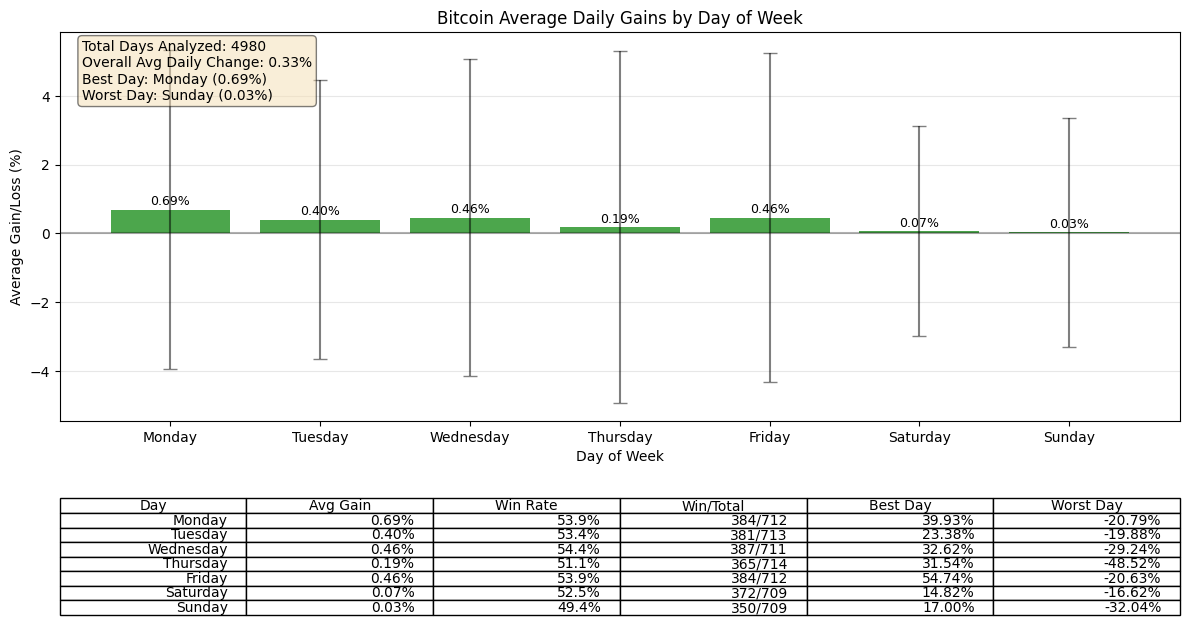

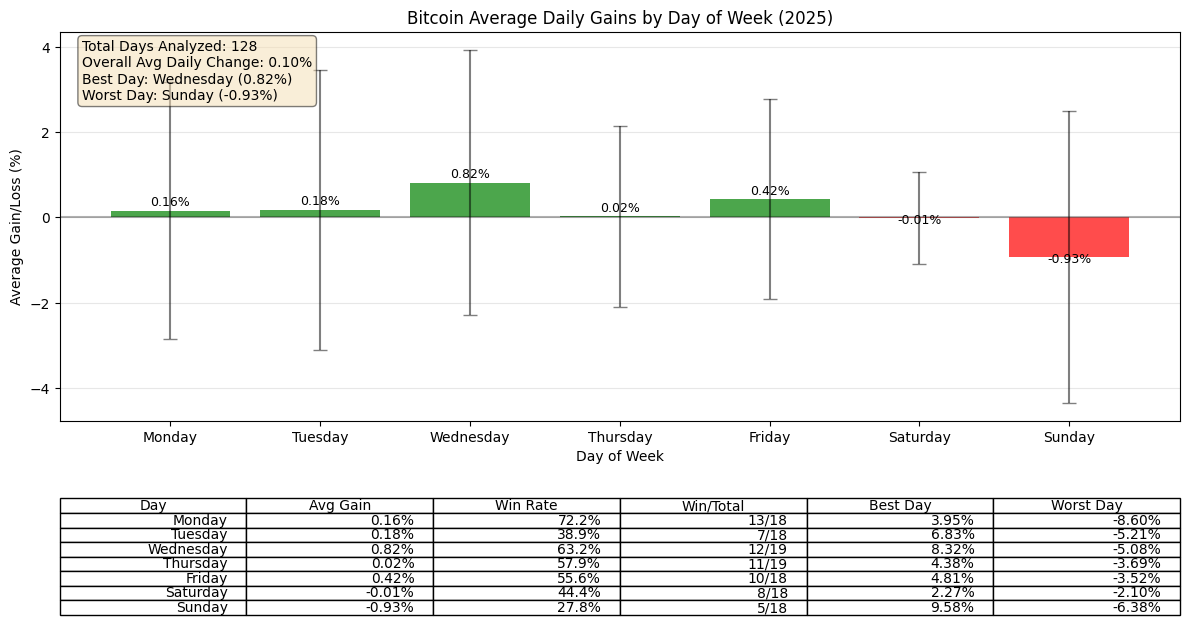

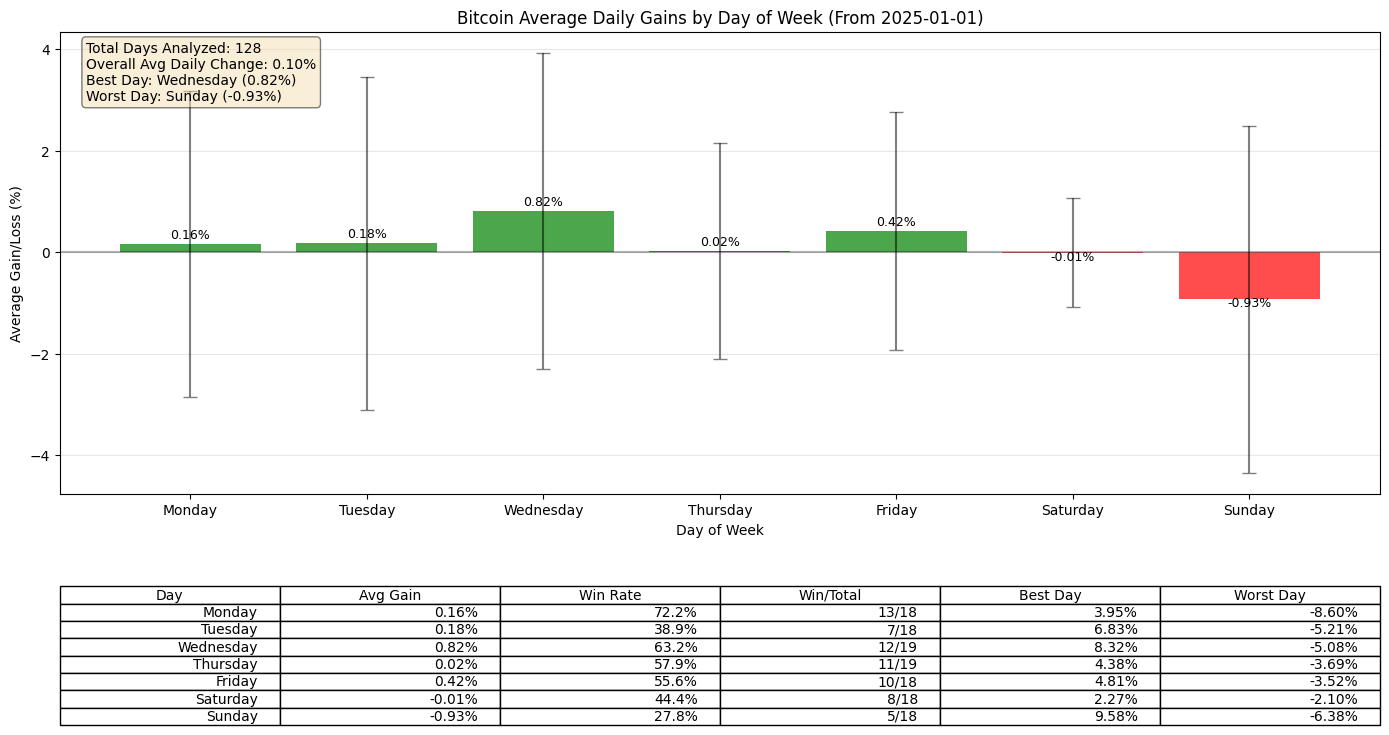

   weekday weekday_name  avg_gain_pct  std_gain_pct  total_days  \
0        0       Monday      0.159972      3.017335          18   
1        1      Tuesday      0.176436      3.284206          18   
2        2    Wednesday      0.816494      3.114258          19   
3        3     Thursday      0.022047      2.125880          19   
4        4       Friday      0.419640      2.343664          18   
5        5     Saturday     -0.012305      1.070807          18   
6        6       Sunday     -0.933299      3.418637          18   

   positive_days  negative_days  pct_positive_days  min_gain_pct  max_gain_pct  
0             13              5          72.222222     -8.604888      3.954710  
1              7             11          38.888889     -5.213242      6.829324  
2             12              7          63.157895     -5.082813      8.318470  
3             11              8          57.894737     -3.693973      4.382901  
4             10              8          55.555556     -3.

In [83]:
def plot_weekday_gains(df, price_open_col='open', price_close_col='close', date_col='time', figsize=(12, 6), year=None, start_date=None):
    """
    Group data by day of week, calculate average gains, and display as a sorted bar chart.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing Bitcoin price data
    price_open_col : str, default 'open'
        Column name for the opening price data
    price_close_col : str, default 'close'
        Column name for the closing price data
    date_col : str, default 'time'
        Column name for the date data
    figsize : tuple, default (12, 6)
        Figure size for the plot
    year : int or None, default None
        If provided, filters data to only show the specified year
    start_date : str or datetime or None, default None
        If provided, only calculates and displays data from this date onwards
        Format: 'YYYY-MM-DD' or datetime object
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    pandas.DataFrame
        The dataframe with weekday gains statistics
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from datetime import datetime
    
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Convert date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_copy[date_col]):
        df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    
    # Filter by start_date if specified
    if start_date is not None:
        # Convert start_date to datetime if it's a string
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        
        # Filter dataframe
        df_copy = df_copy[df_copy[date_col] >= start_date]
        
        if len(df_copy) == 0:
            raise ValueError(f"No data found after start date {start_date}")
    
    # Filter by year if specified
    if year is not None:
        df_copy = df_copy[df_copy[date_col].dt.year == year]
        if len(df_copy) == 0:
            raise ValueError(f"No data found for year {year}")
    
    # Add date as a separate column (without time) for grouping
    df_copy['date_only'] = df_copy[date_col].dt.date
    
    # Add day of week (as integer 0-6, where 0 is Monday)
    df_copy['weekday'] = df_copy[date_col].dt.weekday
    
    # Add day name for better labels
    df_copy['weekday_name'] = df_copy[date_col].dt.day_name()
    
    # Group by day and get first/last values for each day
    daily_data = df_copy.groupby('date_only').agg({
        price_open_col: 'first',
        price_close_col: 'last',
        'weekday': 'first',
        'weekday_name': 'first'
    }).reset_index()
    
    # Calculate daily percentage gain/loss
    daily_data['gain_pct'] = ((daily_data[price_close_col] - daily_data[price_open_col]) / 
                              daily_data[price_open_col]) * 100
    
    # Group by weekday and calculate statistics
    weekday_stats = daily_data.groupby(['weekday', 'weekday_name']).agg({
        'gain_pct': ['mean', 'std', 'count', 
                     lambda x: (x > 0).sum(),  # Count of positive days
                     lambda x: (x < 0).sum(),  # Count of negative days
                     lambda x: (x > 0).mean() * 100,  # Percentage of positive days
                     'min', 'max']
    }).reset_index()
    
    # Flatten the multi-index columns
    weekday_stats.columns = ['weekday', 'weekday_name', 'avg_gain_pct', 'std_gain_pct', 
                            'total_days', 'positive_days', 'negative_days', 
                            'pct_positive_days', 'min_gain_pct', 'max_gain_pct']
    
    # Sort by weekday to ensure Monday to Sunday order
    weekday_stats = weekday_stats.sort_values('weekday')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generate bar colors (green for positive, red for negative)
    colors = ['green' if gain >= 0 else 'red' for gain in weekday_stats['avg_gain_pct']]
    
    # Create bar chart for average gains by weekday
    bars = ax.bar(weekday_stats['weekday_name'], weekday_stats['avg_gain_pct'], color=colors, alpha=0.7)
    
    # Add thin horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Create title text with filters
    if year is not None and start_date is not None:
        filter_text = f" ({year}, from {start_date.strftime('%Y-%m-%d') if isinstance(start_date, datetime) else start_date})"
    elif year is not None:
        filter_text = f" ({year})"
    elif start_date is not None:
        filter_text = f" (From {start_date.strftime('%Y-%m-%d') if isinstance(start_date, datetime) else start_date})"
    else:
        filter_text = ""
    
    # Set title and labels
    ax.set_title(f'Bitcoin Average Daily Gains by Day of Week{filter_text}')
    ax.set_ylabel('Average Gain/Loss (%)')
    ax.set_xlabel('Day of Week')
    
    # Calculate and display overall statistics
    total_days = weekday_stats['total_days'].sum()
    avg_overall_gain = daily_data['gain_pct'].mean()
    best_weekday = weekday_stats.loc[weekday_stats['avg_gain_pct'].idxmax(), 'weekday_name']
    worst_weekday = weekday_stats.loc[weekday_stats['avg_gain_pct'].idxmin(), 'weekday_name']
    
    # Format the information text
    stats_text = (
        f"Total Days Analyzed: {total_days}\n"
        f"Overall Avg Daily Change: {avg_overall_gain:.2f}%\n"
        f"Best Day: {best_weekday} ({weekday_stats['avg_gain_pct'].max():.2f}%)\n"
        f"Worst Day: {worst_weekday} ({weekday_stats['avg_gain_pct'].min():.2f}%)"
    )
    
    # Add text box with statistics
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Add horizontal grid
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        value_text = f"{height:.2f}%"
        text_color = 'black'
        y_pos = height + 0.05 if height >= 0 else height - 0.2
        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                value_text, ha='center', va='bottom', color=text_color, fontsize=9)
    
    # Add error bars to show standard deviation
    yerr = weekday_stats['std_gain_pct']
    ax.errorbar(weekday_stats['weekday_name'], weekday_stats['avg_gain_pct'], 
                yerr=yerr, fmt='none', color='black', capsize=5, alpha=0.5)
    
    # Create a detailed table to show with the chart
    table_data = []
    for _, row in weekday_stats.iterrows():
        weekday = row['weekday_name']
        avg_gain = f"{row['avg_gain_pct']:.2f}%"
        win_rate = f"{row['pct_positive_days']:.1f}%"
        days = f"{row['positive_days']}/{row['total_days']}"
        max_gain = f"{row['max_gain_pct']:.2f}%"
        max_loss = f"{row['min_gain_pct']:.2f}%"
        table_data.append([weekday, avg_gain, win_rate, days, max_gain, max_loss])
    
    # Create the table (optional - you can comment this out if you don't want the table)
    table = plt.table(cellText=table_data,
                     colLabels=['Day', 'Avg Gain', 'Win Rate', 'Win/Total', 'Best Day', 'Worst Day'],
                     loc='bottom',
                     bbox=[0, -0.50, 1, 0.30])  # Adjust these values to position the table
    
    # Adjust bottom margin to make room for the table
    plt.subplots_adjust(bottom=0.35)
    
    plt.tight_layout()
    
    return fig, weekday_stats


# Basic usage: Show average gains by day of week
fig, weekday_stats = plot_weekday_gains(df)
plt.show()

# Filter by year
fig, weekday_stats = plot_weekday_gains(
    df,
    year=2025,  # Show only 2023 data
    price_open_col='open',
    price_close_col='close',
    date_col='time'
)
plt.show()

# Filter by start date
fig, weekday_stats = plot_weekday_gains(
    df,
    start_date='2025-01-01',  # Start from January 2022
    figsize=(14, 7)  # Larger figure size
)
plt.show()

# Print the full statistics dataframe
print(weekday_stats)